# Cell 1 — Imports
Bu hücre, not defterinde kullanılacak ana kütüphaneleri içe aktarır. `ultralytics.YOLO` sınıfı buradan sağlanır.

In [6]:
# Açıklama: Bu hücre 'ultralytics' YOLO sınıfını içe aktarır.
# Kullanım: Notebook içindeki tüm YOLO model yüklemeleri bu sınıfı kullanır.
from ultralytics import YOLO


# Cell 2 — Setup ve yardımcı kütüphaneler
Bu hücre, ek yardımcı kütüphaneleri yükler ve dosya/yol işlemleri için temel ayarları yapar (OpenCV, PIL, matplotlib vb.).

In [3]:
# Gerekli kütüphaneleri import et
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from IPython.display import Image as IPImage, display
import shutil
import glob

# Cell 3 — Görsel test ve model doğrulama
Bu hücre, eğitimli modeli bir test görselinde çalıştırarak hızlı doğrulama yapar; çıktı görselleri kaydeder ve temel kontrol amaçlıdır.

🖼️ Görsel testi başlatılıyor...

image 1/1 C:\Users\User\Desktop\kort\tk.PNG: 384x640 2 Players, 43.5ms
Speed: 1.8ms preprocess, 43.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\Users\User\runs\detect\predict3
image 1/1 C:\Users\User\Desktop\kort\tk.PNG: 384x640 2 Players, 43.5ms
Speed: 1.8ms preprocess, 43.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\Users\User\runs\detect\predict3


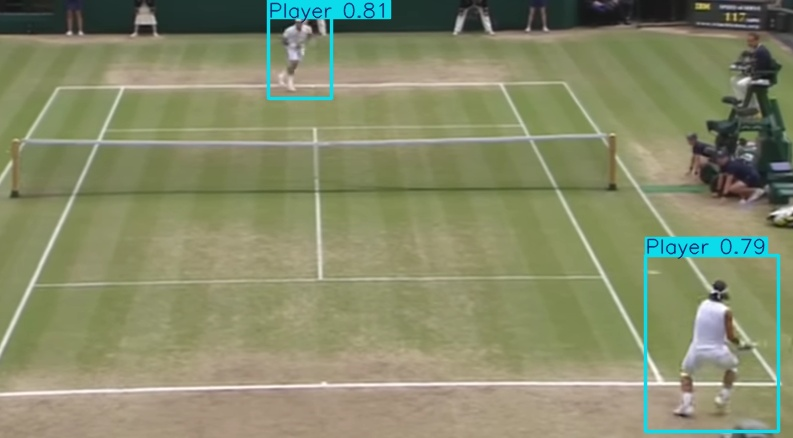


✅ Görsel testi tamamlandı!
✅ Tespit edilen nesne sayısı: 2
✅ Sonuç kaydedildi: C:\Users\User\Desktop\kort\test_result1.jpg


In [8]:
# Görsel ile test
print("🖼️ Görsel testi başlatılıyor...")

# Model ve görsel yolları
model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
test_image_path = r'C:\Users\User\Desktop\kort\tk.PNG'
output_path = r'C:\Users\User\Desktop\kort\test_result1.jpg'

# Model yükle ve tahmin yap
model_test = YOLO(model_path)
results = model_test.predict(test_image_path, save=True, conf=0.25)

# İlk sonucu göster ve kaydet
if results:
    result = results[0]
    result.save(filename=output_path)
    
    # Jupyter'de göster
    display(IPImage(filename=output_path))
    
    # Tespit edilen nesneleri göster
    boxes = result.boxes
    print(f"\n✅ Görsel testi tamamlandı!")
    print(f"✅ Tespit edilen nesne sayısı: {len(boxes)}")
    print(f"✅ Sonuç kaydedildi: {output_path}")
else:
    print("❌ Tahmin yapılamadı")

# Cell 4 — Veri önizleme / küçük testler
Bu hücrede küçük görsel testleri, dosya yolları ve model çıktılarının örnek kaydını yapar; deneme amaçlıdır.

In [7]:
# DeepSORT kütüphanesini kurulum
# Installing DeepSORT library
!pip install deep-sort-realtime

# Cell 5 — Kısa not / yardımcı işlem
Bu hücre küçük yardımcı işlemler veya kısa çıktı yazdırmaları içerir; notebook akışını kontrol etmeye yarar.

In [10]:
# Video üzerinde DeepSORT ile nesne takibi
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np

print("🎥 Video takibi başlatılıyor...")

# Model ve video yolları
model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_path = r'C:\Users\User\Desktop\kort\nadal_tracked.mp4'

# Model yükle
model = YOLO(model_path)

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Video okuma
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"📹 Video: {width}x{height}, {fps} FPS, {total_frames} frame")

# Video yazma
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Renk tanımlamaları (BGR formatında)
PLAYER_COLOR = (0, 255, 0)    # Yeşil - Oyuncular
BALL_COLOR = (0, 0, 255)       # Kırmızı - Top
TEXT_COLOR = (255, 255, 255)   # Beyaz - Metin

frame_count = 0
sample_frame = None
sample_frame_num = total_frames // 2  # Ortadaki frame'i kaydedelim

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    # YOLOv8 ile tespit (düşük threshold ile tüm tespitler)
    results = model(frame, conf=0.15, verbose=False)
    
    # Tespit sonuçlarını DeepSORT formatına çevir
    detections = []
    ball_detections = []
    
    # Farklı threshold değerleri
    PLAYER_THRESHOLD = 0.5  # Oyuncular için yüksek threshold
    BALL_THRESHOLD = 0.15   # Top için düşük threshold
    
    if len(results) > 0:
        boxes = results[0].boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            
            # Bbox formatı: (x1, y1, w, h)
            bbox = [x1, y1, x2-x1, y2-y1]
            
            # Class isimlerini al
            class_name = model.names[cls] if hasattr(model, 'names') else str(cls)
            
            # Top ayrı tutulacak
            if 'ball' in class_name.lower() or cls == 0:  # Top class'ı
                if conf >= BALL_THRESHOLD:
                    ball_detections.append((bbox, conf, class_name))
            else:
                # Oyuncular için yüksek threshold
                if conf >= PLAYER_THRESHOLD:
                    detections.append((bbox, conf, cls))
    
    # DeepSORT ile tracking (sadece oyuncular için)
    tracks = tracker.update_tracks(detections, frame=frame)
    
    # Tracking sonuçlarını çiz
    for track in tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        ltrb = track.to_ltrb()
        
        x1, y1, x2, y2 = map(int, ltrb)
        
        # Oyuncu için yeşil kutu
        cv2.rectangle(frame, (x1, y1), (x2, y2), PLAYER_COLOR, 2)
        cv2.putText(frame, f'ID: {track_id}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, PLAYER_COLOR, 2)
    
    # Topları ayrı renkte çiz (tracking olmadan)
    for (bbox, conf, class_name) in ball_detections:
        x1, y1, w, h = bbox
        x1, y1, x2, y2 = int(x1), int(y1), int(x1+w), int(y1+h)
        
        # Top için kırmızı kutu
        cv2.rectangle(frame, (x1, y1), (x2, y2), BALL_COLOR, 2)
        cv2.putText(frame, f'Ball {conf:.2f}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, BALL_COLOR, 2)
    
    # Frame sayısını ekle
    cv2.putText(frame, f'Frame: {frame_count}/{total_frames}', (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 2)
    
    # Video'ya yaz
    out.write(frame)
    
    # Örnek frame kaydet
    if frame_count == sample_frame_num:
        sample_frame = frame.copy()
    
    # İlerleme göster
    if frame_count % 30 == 0:
        print(f"⏳ İşlenen: {frame_count}/{total_frames} frame ({frame_count*100//total_frames}%)")

cap.release()
out.release()

print(f"\n✅ Video takibi tamamlandı!")
print(f"✅ Çıktı: {output_path}")

# Örnek frame'i göster
if sample_frame is not None:
    print(f"\n📸 Örnek frame (Frame {sample_frame_num}):")
    
    # Frame'i kaydet
    sample_path = r'C:\Users\User\Desktop\kort\sample_frame.jpg'
    cv2.imwrite(sample_path, sample_frame)
    
    # Jupyter'de göster
    sample_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(sample_rgb)
    plt.axis('off')
    plt.title(f'Tracking Sonucu - Frame {sample_frame_num}')
    plt.tight_layout()
    plt.savefig(r'C:\Users\User\Desktop\kort\tracking_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Örnek frame kaydedildi: {sample_path}")
    print(f"✅ Plot kaydedildi: C:\\Users\\User\\Desktop\\kort\\tracking_result.png")

🎥 Video takibi başlatılıyor...
📹 Video: 1280x720, 30 FPS, 497 frame
📹 Video: 1280x720, 30 FPS, 497 frame
⏳ İşlenen: 30/497 frame (6%)
⏳ İşlenen: 30/497 frame (6%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 60/497 frame (12%)


KeyboardInterrupt: 

# Cell 6 — Video işleme ve temel pipeline
Bu hücre video okuma, başlangıç pipeline adımları ve temel işleme döngüsünün tanımlarını içerir (OpenCV ile video açma vb.).

In [ ]:
# MobileSAM ve bağımlılıklarını kurulum
!pip install timm
!pip install git+https://github.com/ChaoningZhang/MobileSAM.git

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   -------------------- ------------------- 1.3/2.5 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 8.4 MB/s  0:00:00


# Cell 7 — Ayarlar / sabitler
Bu hücre eşiği değerleri, renk tanımları ve diğer sabit değişkenleri tanımlar (thresholdlar, renk paletleri vb.).

c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
C:\Users\User\Desktop\MobileSAM\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m

🎥 MobileSAM ile Video Segmentasyon ve Takip başlatılıyor...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
📹 Video: 1280x720, 30 FPS, 497 frame
✅ MobileSAM yüklendi (cpu)
📹 Video: 1280x720, 30 FPS, 497 frame
⏳ İşlenen: 30/497 frame (6%)
⏳ İşlenen: 30/497 frame (6%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 90/497 frame (18%)
⏳ İşlenen: 90/497 frame (18%)
⏳ İşlenen: 120/497 frame (24%)
⏳ İşlenen: 120/497 frame (24%)
⏳ İşlenen: 150/497 frame (30%)
⏳ İşlenen: 150/497 frame (30%)
⏳ İşlenen: 180/497 frame (36%)
⏳ İşlenen: 180/497 frame (36%)
⏳ İşlenen: 210/497 frame (42%)
⏳ İşlenen: 210/497 frame (42%)
⏳ İşlenen: 240/497 frame (48%)
⏳ İşlenen: 240/497 frame (48%)
⏳ İşlenen: 270/497 frame (54%)
⏳ İşlenen: 270/497 frame (54%)
⏳ İşlenen: 300/497 frame (60%)
⏳ İşlenen: 300/497 frame (60%)
⏳ İşlenen: 330/497 frame (66%)
⏳ İşlenen: 330/497 frame (66%)
⏳ İşlenen: 360/497 frame (72%)
⏳ İşlenen: 360/497 frame (72%)
⏳ İşlenen: 390/497 frame (78%)
⏳ İşlenen: 390/497 

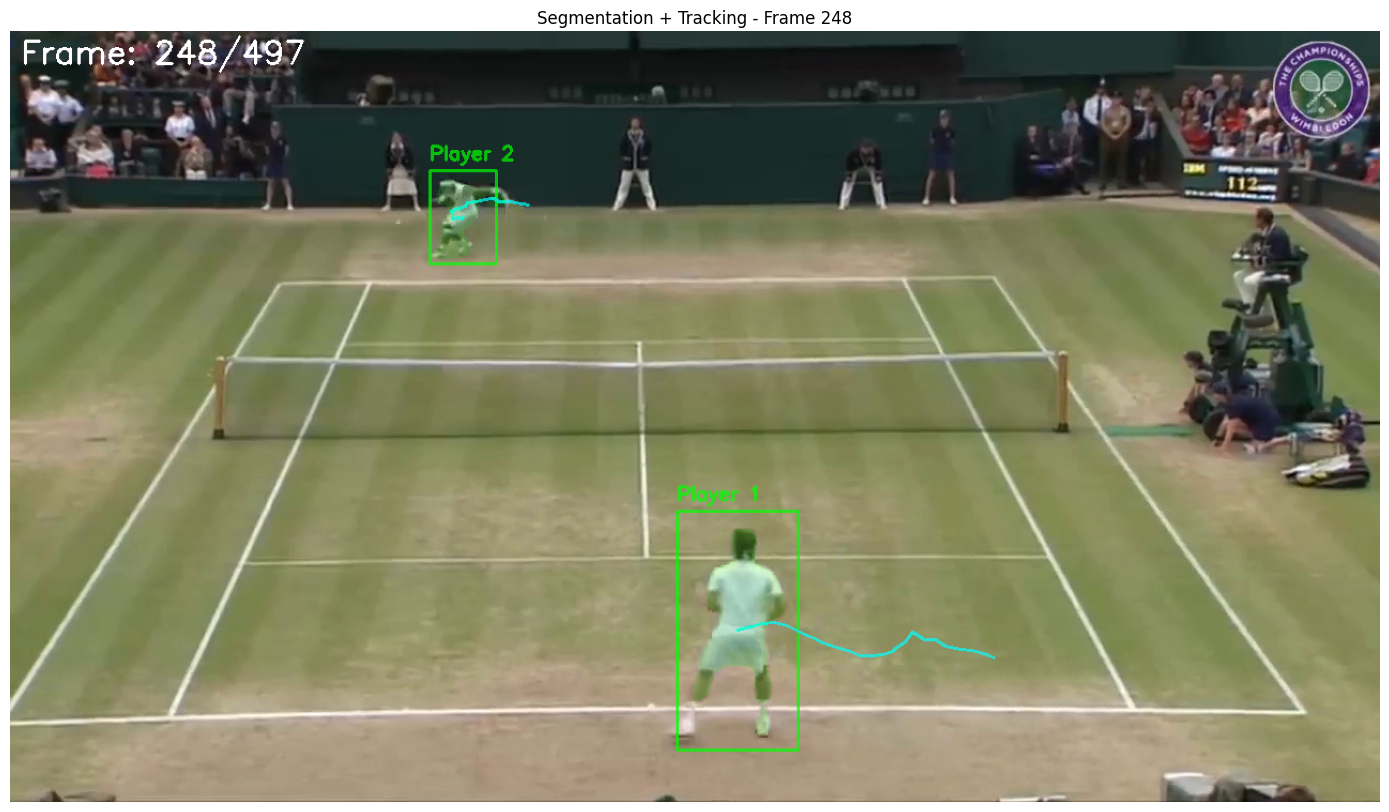

✅ Örnek frame kaydedildi: C:\Users\User\Desktop\kort\sample_segmented.jpg
✅ Plot kaydedildi: C:\Users\User\Desktop\kort\segmented_tracking_result.png


In [13]:
# Video üzerinde MobileSAM Segmentasyon ve DeepSORT Takip
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
from collections import defaultdict
import torch
from mobile_sam import sam_model_registry, SamPredictor

print("🎥 MobileSAM ile Video Segmentasyon ve Takip başlatılıyor...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_path = r'C:\Users\User\Desktop\kort\nadal_segmented_tracked.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Takip çizgileri için geçmiş pozisyonları sakla
track_history = defaultdict(lambda: [])
ball_history = []

# Video okuma
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"📹 Video: {width}x{height}, {fps} FPS, {total_frames} frame")

# Video yazma
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Renk tanımlamaları (BGR formatında)
PLAYER_COLOR = (0, 255, 0)      # Yeşil - Oyuncular
BALL_COLOR = (0, 0, 255)         # Kırmızı - Top
TRACK_COLOR = (255, 255, 0)      # Cyan - Takip çizgisi (oyuncular)
BALL_TRACK_COLOR = (255, 0, 255) # Magenta - Top takip çizgisi
TEXT_COLOR = (255, 255, 255)     # Beyaz - Metin

# Threshold değerleri
PLAYER_THRESHOLD = 0.5
BALL_THRESHOLD = 0.15

frame_count = 0
sample_frame = None
sample_frame_num = total_frames // 2

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    # SAM için frame hazırla
    sam_predictor.set_image(frame)
    
    # YOLOv8 ile tespit
    results = yolo_model(frame, conf=0.15, verbose=False)
    
    detections = []
    ball_detections = []
    
    if len(results) > 0:
        boxes = results[0].boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            
            bbox = [x1, y1, x2-x1, y2-y1]
            class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
            
            if 'ball' in class_name.lower() or cls == 0:
                if conf >= BALL_THRESHOLD:
                    ball_detections.append((bbox, conf, class_name, [x1, y1, x2, y2]))
            else:
                if conf >= PLAYER_THRESHOLD:
                    detections.append((bbox, conf, cls))
    
    # DeepSORT ile tracking (oyuncular)
    tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
    
    # Overlay için alfa kanalı
    overlay = frame.copy()
    
    # Oyuncu tracking ve segmentasyon
    for track in tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        
        # Merkez noktayı hesapla (takip çizgisi için)
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        # Takip geçmişine ekle
        track_history[track_id].append((center_x, center_y))
        if len(track_history[track_id]) > 30:  # Son 30 frame
            track_history[track_id].pop(0)
        
        # MobileSAM ile segmentasyon
        try:
            input_box = np.array([x1, y1, x2, y2])
            masks, _, _ = sam_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
            
            # Maskeyi overlay'e uygula
            mask = masks[0]
            overlay[mask] = overlay[mask] * 0.5 + np.array(PLAYER_COLOR) * 0.5
        except:
            pass
        
        # Bbox çiz
        cv2.rectangle(frame, (x1, y1), (x2, y2), PLAYER_COLOR, 2)
        cv2.putText(frame, f'Player {track_id}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, PLAYER_COLOR, 2)
        
        # Takip çizgisini çiz
        if len(track_history[track_id]) > 1:
            points = np.array(track_history[track_id], dtype=np.int32)
            cv2.polylines(frame, [points], False, TRACK_COLOR, 2)
    
    # Top segmentasyon ve takip çizgisi
    for (bbox, conf, class_name, xyxy) in ball_detections:
        x1, y1, x2, y2 = map(int, xyxy)
        
        # Merkez noktayı hesapla
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        # Top geçmişine ekle
        ball_history.append((center_x, center_y))
        if len(ball_history) > 50:  # Son 50 frame
            ball_history.pop(0)
        
        # MobileSAM ile top segmentasyonu
        try:
            input_box = np.array([x1, y1, x2, y2])
            masks, _, _ = sam_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
            
            mask = masks[0]
            overlay[mask] = overlay[mask] * 0.5 + np.array(BALL_COLOR) * 0.5
        except:
            pass
        
        # Bbox çiz
        cv2.rectangle(frame, (x1, y1), (x2, y2), BALL_COLOR, 2)
        cv2.putText(frame, f'Ball {conf:.2f}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, BALL_COLOR, 2)
        
        # Top takip çizgisini çiz
        if len(ball_history) > 1:
            points = np.array(ball_history, dtype=np.int32)
            cv2.polylines(frame, [points], False, BALL_TRACK_COLOR, 2)
    
    # Overlay'i frame ile birleştir
    frame = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)
    
    # Frame sayısını ekle
    cv2.putText(frame, f'Frame: {frame_count}/{total_frames}', (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 2)
    
    # Video'ya yaz
    out.write(frame)
    
    # Örnek frame kaydet
    if frame_count == sample_frame_num:
        sample_frame = frame.copy()
    
    # İlerleme göster
    if frame_count % 30 == 0:
        print(f"⏳ İşlenen: {frame_count}/{total_frames} frame ({frame_count*100//total_frames}%)")

cap.release()
out.release()

print(f"\n✅ Video segmentasyon ve takip tamamlandı!")
print(f"✅ Çıktı: {output_path}")

# Örnek frame'i göster
if sample_frame is not None:
    print(f"\n📸 Örnek frame (Frame {sample_frame_num}):")
    
    sample_path = r'C:\Users\User\Desktop\kort\sample_segmented.jpg'
    cv2.imwrite(sample_path, sample_frame)
    
    sample_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 9))
    plt.imshow(sample_rgb)
    plt.axis('off')
    plt.title(f'Segmentation + Tracking - Frame {sample_frame_num}')
    plt.tight_layout()
    plt.savefig(r'C:\Users\User\Desktop\kort\segmented_tracking_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Örnek frame kaydedildi: {sample_path}")
    print(f"✅ Plot kaydedildi: C:\\Users\\User\\Desktop\\kort\\segmented_tracking_result.png")

# Cell 8 — Model yükleme ve konfigürasyon
Bu hücre modellerin (YOLO, MobileSAM) yüklenmesi, cihaz seçimi (CPU/GPU) ve ön ayarları yapar.

🎥 MobileSAM ile Video Segmentasyon ve Takip başlatılıyor...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
📹 Video: 1280x720, 30 FPS, 497 frame
✅ MobileSAM yüklendi (cpu)
📹 Video: 1280x720, 30 FPS, 497 frame
⏳ İşlenen: 30/497 frame (6%)
⏳ İşlenen: 30/497 frame (6%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 90/497 frame (18%)
⏳ İşlenen: 90/497 frame (18%)
⏳ İşlenen: 120/497 frame (24%)
⏳ İşlenen: 120/497 frame (24%)
⏳ İşlenen: 150/497 frame (30%)
⏳ İşlenen: 150/497 frame (30%)
⏳ İşlenen: 180/497 frame (36%)
⏳ İşlenen: 180/497 frame (36%)
⏳ İşlenen: 210/497 frame (42%)
⏳ İşlenen: 210/497 frame (42%)
⏳ İşlenen: 240/497 frame (48%)
⏳ İşlenen: 240/497 frame (48%)
⏳ İşlenen: 270/497 frame (54%)
⏳ İşlenen: 270/497 frame (54%)
⏳ İşlenen: 300/497 frame (60%)
⏳ İşlenen: 300/497 frame (60%)
⏳ İşlenen: 330/497 frame (66%)
⏳ İşlenen: 330/497 frame (66%)
⏳ İşlenen: 360/497 frame (72%)
⏳ İşlenen: 360/497 frame (72%)
⏳ İşlenen: 390/497 frame (78%)
⏳ İşlenen: 390/497 

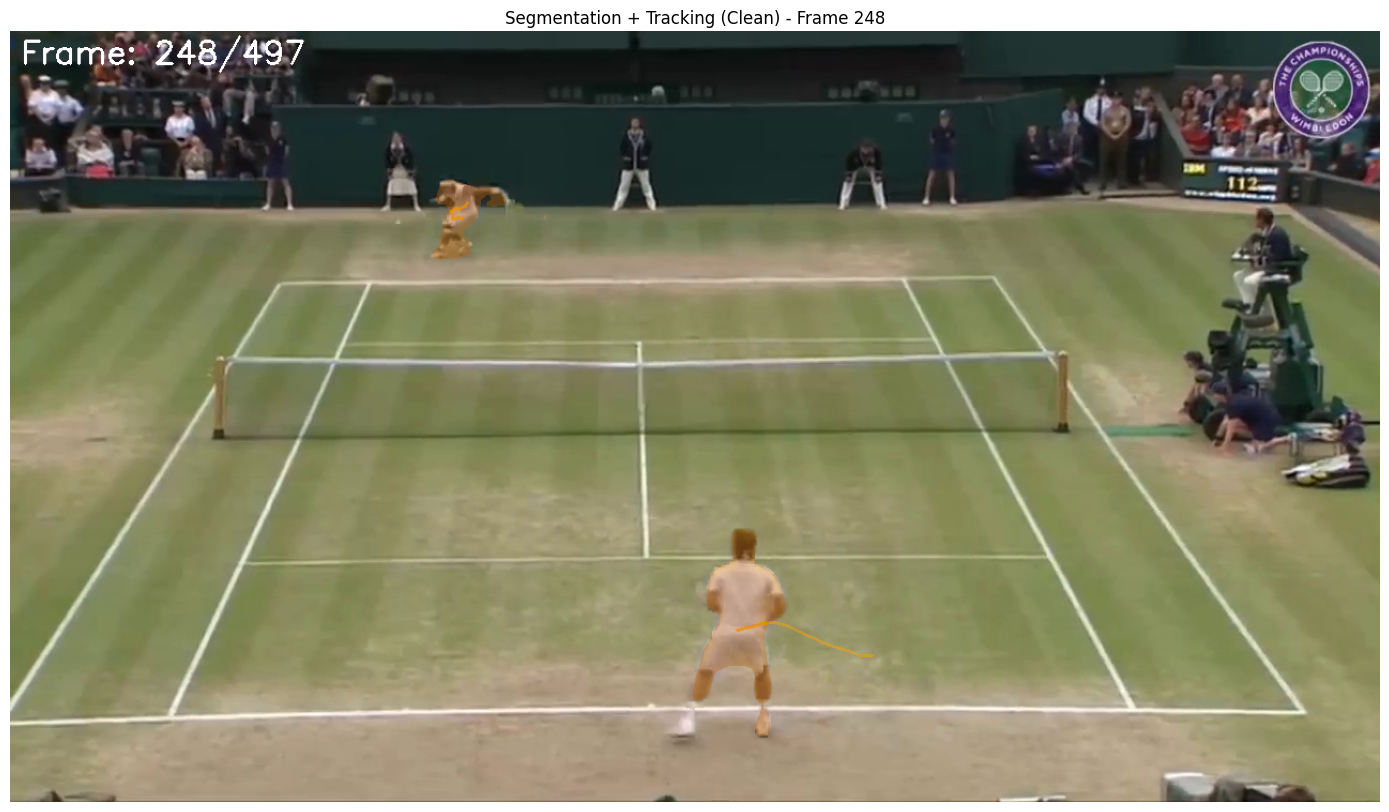

✅ Örnek frame kaydedildi: C:\Users\User\Desktop\kort\sample_segmented_clean.jpg
✅ Plot kaydedildi: C:\Users\User\Desktop\kort\segmented_tracking_result_clean.png


In [14]:
# Video üzerinde MobileSAM Segmentasyon ve DeepSORT Takip (Sadece Segmentasyon ve İzler)
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
from collections import defaultdict
import torch
from mobile_sam import sam_model_registry, SamPredictor

print("🎥 MobileSAM ile Video Segmentasyon ve Takip başlatılıyor...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_path = r'C:\Users\User\Desktop\kort\nadal_segmented_tracked_clean.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Takip çizgileri için geçmiş pozisyonları sakla
track_history = defaultdict(lambda: [])
ball_history = []

# Video okuma
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"📹 Video: {width}x{height}, {fps} FPS, {total_frames} frame")

# Video yazma
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Renk tanımlamaları (BGR formatında) - Daha koyu turuncu tonları
PLAYER_COLOR = (0, 100, 200)     # Turuncu - Oyuncular (koyu)
BALL_COLOR = (0, 69, 255)         # Turuncu/Kırmızı - Top
TRACK_COLOR = (0, 165, 255)       # Açık turuncu - Takip çizgisi (oyuncular)
BALL_TRACK_COLOR = (0, 140, 255)  # Turuncu - Top takip çizgisi
TEXT_COLOR = (255, 255, 255)      # Beyaz - Metin

# Threshold değerleri
PLAYER_THRESHOLD = 0.5
BALL_THRESHOLD = 0.15

frame_count = 0
sample_frame = None
sample_frame_num = total_frames // 2

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    # SAM için frame hazırla
    sam_predictor.set_image(frame)
    
    # YOLOv8 ile tespit
    results = yolo_model(frame, conf=0.15, verbose=False)
    
    detections = []
    ball_detections = []
    
    if len(results) > 0:
        boxes = results[0].boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            
            bbox = [x1, y1, x2-x1, y2-y1]
            class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
            
            if 'ball' in class_name.lower() or cls == 0:
                if conf >= BALL_THRESHOLD:
                    ball_detections.append((bbox, conf, class_name, [x1, y1, x2, y2]))
            else:
                if conf >= PLAYER_THRESHOLD:
                    detections.append((bbox, conf, cls))
    
    # DeepSORT ile tracking (oyuncular)
    tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
    
    # Overlay için alfa kanalı
    overlay = frame.copy()
    
    # Oyuncu tracking ve segmentasyon
    for track in tracks:
        if not track.is_confirmed():
            continue
        
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        
        # Merkez noktayı hesapla (takip çizgisi için)
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        # Takip geçmişine ekle - KISALTILMIŞ (15 frame)
        track_history[track_id].append((center_x, center_y))
        if len(track_history[track_id]) > 15:
            track_history[track_id].pop(0)
        
        # MobileSAM ile segmentasyon
        try:
            input_box = np.array([x1, y1, x2, y2])
            masks, _, _ = sam_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
            
            # Maskeyi overlay'e uygula - DAHA KOYU (0.7 oranında)
            mask = masks[0]
            overlay[mask] = overlay[mask] * 0.3 + np.array(PLAYER_COLOR) * 0.7
        except:
            pass
        
        # Takip çizgisini çiz
        if len(track_history[track_id]) > 1:
            points = np.array(track_history[track_id], dtype=np.int32)
            cv2.polylines(frame, [points], False, TRACK_COLOR, 2)
    
    # Top segmentasyon ve takip çizgisi
    for (bbox, conf, class_name, xyxy) in ball_detections:
        x1, y1, x2, y2 = map(int, xyxy)
        
        # Merkez noktayı hesapla
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        
        # Top geçmişine ekle - KISALTILMIŞ (25 frame)
        ball_history.append((center_x, center_y))
        if len(ball_history) > 25:
            ball_history.pop(0)
        
        # MobileSAM ile top segmentasyonu
        try:
            input_box = np.array([x1, y1, x2, y2])
            masks, _, _ = sam_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
            
            # DAHA KOYU segmentasyon
            mask = masks[0]
            overlay[mask] = overlay[mask] * 0.3 + np.array(BALL_COLOR) * 0.7
        except:
            pass
        
        # Top takip çizgisini çiz
        if len(ball_history) > 1:
            points = np.array(ball_history, dtype=np.int32)
            cv2.polylines(frame, [points], False, BALL_TRACK_COLOR, 2)
    
    # Overlay'i frame ile birleştir
    frame = cv2.addWeighted(frame, 0.5, overlay, 0.5, 0)
    
    # Frame sayısını ekle
    cv2.putText(frame, f'Frame: {frame_count}/{total_frames}', (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 2)
    
    # Video'ya yaz
    out.write(frame)
    
    # Örnek frame kaydet
    if frame_count == sample_frame_num:
        sample_frame = frame.copy()
    
    # İlerleme göster
    if frame_count % 30 == 0:
        print(f"⏳ İşlenen: {frame_count}/{total_frames} frame ({frame_count*100//total_frames}%)")

cap.release()
out.release()

print(f"\n✅ Video segmentasyon ve takip tamamlandı!")
print(f"✅ Çıktı: {output_path}")

# Örnek frame'i göster
if sample_frame is not None:
    print(f"\n📸 Örnek frame (Frame {sample_frame_num}):")
    
    sample_path = r'C:\Users\User\Desktop\kort\sample_segmented_clean.jpg'
    cv2.imwrite(sample_path, sample_frame)
    
    sample_rgb = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 9))
    plt.imshow(sample_rgb)
    plt.axis('off')
    plt.title(f'Segmentation + Tracking (Clean) - Frame {sample_frame_num}')
    plt.tight_layout()
    plt.savefig(r'C:\Users\User\Desktop\kort\segmented_tracking_result_clean.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Örnek frame kaydedildi: {sample_path}")
    print(f"✅ Plot kaydedildi: C:\\Users\\User\\Desktop\\kort\\segmented_tracking_result_clean.png")

# Cell 9 — Görselleştirme yardımcı fonksiyonları
Bu hücre, kortun kuşbakışı dönüşümleri, yardımcı çizim fonksiyonları ve görselleştirme parçalarını tanımlar.

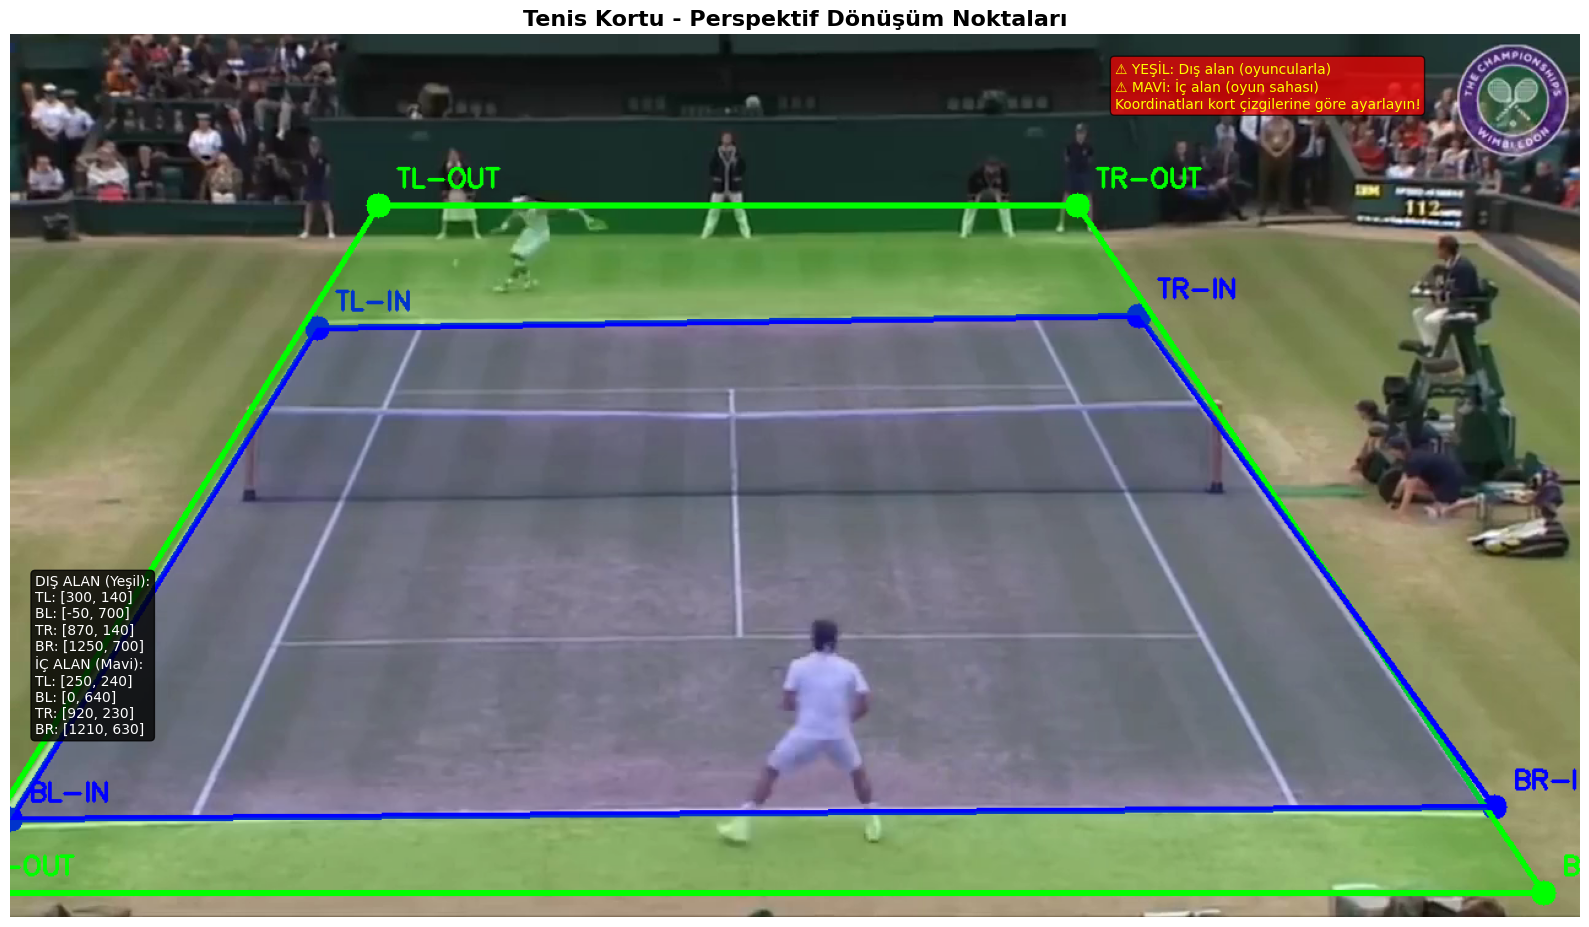

✅ Frame görüntülendi ve kaydedildi!
📁 Kayıt yeri: C:\Users\User\Desktop\kort\court_coordinates.png

📍 DIŞ ALAN Koordinatları (Yeşil):
  Top-Left Outer: [300, 140]
  Bottom-Left Outer: [-50, 700]
  Top-Right Outer: [870, 140]
  Bottom-Right Outer: [1250, 700]

📍 İÇ ALAN Koordinatları (Mavi):
  Top-Left Inner: [250, 240]
  Bottom-Left Inner: [0, 640]
  Top-Right Inner: [920, 230]
  Bottom-Right Inner: [1210, 630]

⚠️ NOT: 
  - YEŞİL: Dış alan koordinatları (oyuncuların bulunduğu geniş alan)
  - MAVİ: İç alan koordinatları (asıl oyun sahası çizgileri)
  - Bu koordinatları videonuzdaki tenis kortunun çizgilerine göre düzenleyin!
  - Düzenlemek için yukarıdaki hücredeki koordinat değerlerini değiştirin.


In [1]:
# Frame Koordinat Görselleştirme - Alan Çizimi için
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Video dosyasını aç
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
vidcap = cv2.VideoCapture(video_path)

# Video dosyasının açıldığını kontrol et
if not vidcap.isOpened():
    print(f"❌ Hata: Video dosyası açılamadı! '{video_path}' dosyasının mevcut olduğundan emin olun.")
else:
    # Belirli bir frame'e git (örnek: 250. frame)
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, 250)
    success, image = vidcap.read()
    
    if success and image is not None:
        # Frame'i kopyala (orijinal boyutta)
        frame = image.copy()
        
        # DIŞ ALAN - Tenis kortu DIŞ çizgiler (oyuncuların olduğu alan)
        # Videonuzda tenis kortunun dış sınırlarını bulun
        tl_outer = [300, 140]   # Top-Left Outer (Dış sol üst)
        bl_outer = [-50, 700]   # Bottom-Left Outer (Dış sol alt)
        tr_outer = [870, 140]   # Top-Right Outer (Dış sağ üst)
        br_outer = [1250, 700]  # Bottom-Right Outer (Dış sağ alt)
        
        # İÇ ALAN - Tenis kortu İÇ çizgiler (asıl oyun alanı)
        # Bu koordinatları korttun iç beyaz çizgilerine göre ayarlayın
        tl_inner = [250, 240]   # Top-Left Inner (İç sol üst)
        bl_inner = [0, 640]    # Bottom-Left Inner (İç sol alt)
        tr_inner = [920, 230]   # Top-Right Inner (İç sağ üst)
        br_inner = [1210, 630]  # Bottom-Right Inner (İç sağ alt)
        
        # DIŞ ALAN koordinatlarını işaretle (Yeşil)
        cv2.circle(frame, tl_outer, 10, (0, 255, 0), -1)
        cv2.circle(frame, bl_outer, 10, (0, 255, 0), -1)
        cv2.circle(frame, tr_outer, 10, (0, 255, 0), -1)
        cv2.circle(frame, br_outer, 10, (0, 255, 0), -1)
        
        # İÇ ALAN koordinatlarını işaretle (Mavi)
        cv2.circle(frame, tl_inner, 10, (255, 0, 0), -1)
        cv2.circle(frame, bl_inner, 10, (255, 0, 0), -1)
        cv2.circle(frame, tr_inner, 10, (255, 0, 0), -1)
        cv2.circle(frame, br_inner, 10, (255, 0, 0), -1)
        
        # Nokta isimlerini ekle - DIŞ (Yeşil)
        cv2.putText(frame, 'TL-OUT', (tl_outer[0]+15, tl_outer[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, 'BL-OUT', (bl_outer[0]+15, bl_outer[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, 'TR-OUT', (tr_outer[0]+15, tr_outer[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, 'BR-OUT', (br_outer[0]+15, br_outer[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Nokta isimlerini ekle - İÇ (Mavi)
        cv2.putText(frame, 'TL-IN', (tl_inner[0]+15, tl_inner[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(frame, 'BL-IN', (bl_inner[0]+15, bl_inner[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(frame, 'TR-IN', (tr_inner[0]+15, tr_inner[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(frame, 'BR-IN', (br_inner[0]+15, br_inner[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        # DIŞ ALAN çokgeni
        points_outer = np.array([tl_outer, bl_outer, br_outer, tr_outer], np.int32)
        points_outer = points_outer.reshape((-1, 1, 2))
        
        # İÇ ALAN çokgeni
        points_inner = np.array([tl_inner, bl_inner, br_inner, tr_inner], np.int32)
        points_inner = points_inner.reshape((-1, 1, 2))

        # Çokgenlerin kenarlarını çiz
        cv2.polylines(frame, [points_outer], isClosed=True, color=(0, 255, 0), thickness=3)
        cv2.polylines(frame, [points_inner], isClosed=True, color=(255, 0, 0), thickness=3)

        # Çokgenlerin içini doldur (yarı saydam)
        overlay = frame.copy()
        cv2.fillPoly(overlay, [points_outer], color=(0, 255, 0))  # Yeşil - Dış alan
        cv2.fillPoly(overlay, [points_inner], color=(255, 0, 0))  # Mavi - İç alan
        alpha = 0.2  # saydamlık seviyesi
        frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
        
        # BGR'den RGB'ye çevir (matplotlib için)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Matplotlib ile göster
        plt.figure(figsize=(16, 10))
        plt.imshow(frame_rgb)
        plt.title('Tenis Kortu - Perspektif Dönüşüm Noktaları', fontsize=16, fontweight='bold')
        plt.axis('off')
        
        # Koordinatları göster
        coord_text_outer = f"DIŞ ALAN (Yeşil):\nTL: {tl_outer}\nBL: {bl_outer}\nTR: {tr_outer}\nBR: {br_outer}"
        coord_text_inner = f"\nİÇ ALAN (Mavi):\nTL: {tl_inner}\nBL: {bl_inner}\nTR: {tr_inner}\nBR: {br_inner}"
        coord_text = coord_text_outer + coord_text_inner
        plt.text(20, frame.shape[0]-150, coord_text, fontsize=10, color='white', 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
        
        # Kullanım talimatı
        instruction_text = "⚠️ YEŞİL: Dış alan (oyuncularla)\n⚠️ MAVİ: İç alan (oyun sahası)\nKoordinatları kort çizgilerine göre ayarlayın!"
        plt.text(frame.shape[1]-380, 60, instruction_text, fontsize=10, color='yellow', 
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
        
        plt.tight_layout()
        
        # Görseli kaydet
        output_path = r'C:\Users\User\Desktop\kort\court_coordinates.png'
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✅ Frame görüntülendi ve kaydedildi!")
        print(f"📁 Kayıt yeri: {output_path}")
        print(f"\n📍 DIŞ ALAN Koordinatları (Yeşil):")
        print(f"  Top-Left Outer: {tl_outer}")
        print(f"  Bottom-Left Outer: {bl_outer}")
        print(f"  Top-Right Outer: {tr_outer}")
        print(f"  Bottom-Right Outer: {br_outer}")
        print(f"\n📍 İÇ ALAN Koordinatları (Mavi):")
        print(f"  Top-Left Inner: {tl_inner}")
        print(f"  Bottom-Left Inner: {bl_inner}")
        print(f"  Top-Right Inner: {tr_inner}")
        print(f"  Bottom-Right Inner: {br_inner}")
        print(f"\n⚠️ NOT: ")
        print(f"  - YEŞİL: Dış alan koordinatları (oyuncuların bulunduğu geniş alan)")
        print(f"  - MAVİ: İç alan koordinatları (asıl oyun sahası çizgileri)")
        print(f"  - Bu koordinatları videonuzdaki tenis kortunun çizgilerine göre düzenleyin!")
        print(f"  - Düzenlemek için yukarıdaki hücredeki koordinat değerlerini değiştirin.")
    else:
        print("❌ Frame okunamadı!")
    
    # Kaynakları temizle
    vidcap.release()

# Cell 10 — Perspektif dönüşümü ve koordinat sistemi
Bu hücre, saha köşe noktalarını, perspektif dönüşüm matrislerini ve sahaya eşlemeyi tanımlar.

🎾 Tek Frame Analizi Başlatılıyor...
📦 MobileSAM yükleniyor...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
✅ MobileSAM yüklendi (cpu)


C:\Users\User\AppData\Local\Temp\ipykernel_11392\3559581482.py:328: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_11392\3559581482.py:328: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_11392\3559581482.py:328: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_11392\3559581482.py:328: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_11392\3559581482.py:332: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  plt.savefig(output_image, dpi=150, bbox_inches='tight')
C:\Users\User\AppData\Local\Temp\ipykernel_11392\3559581482.py:332: Use

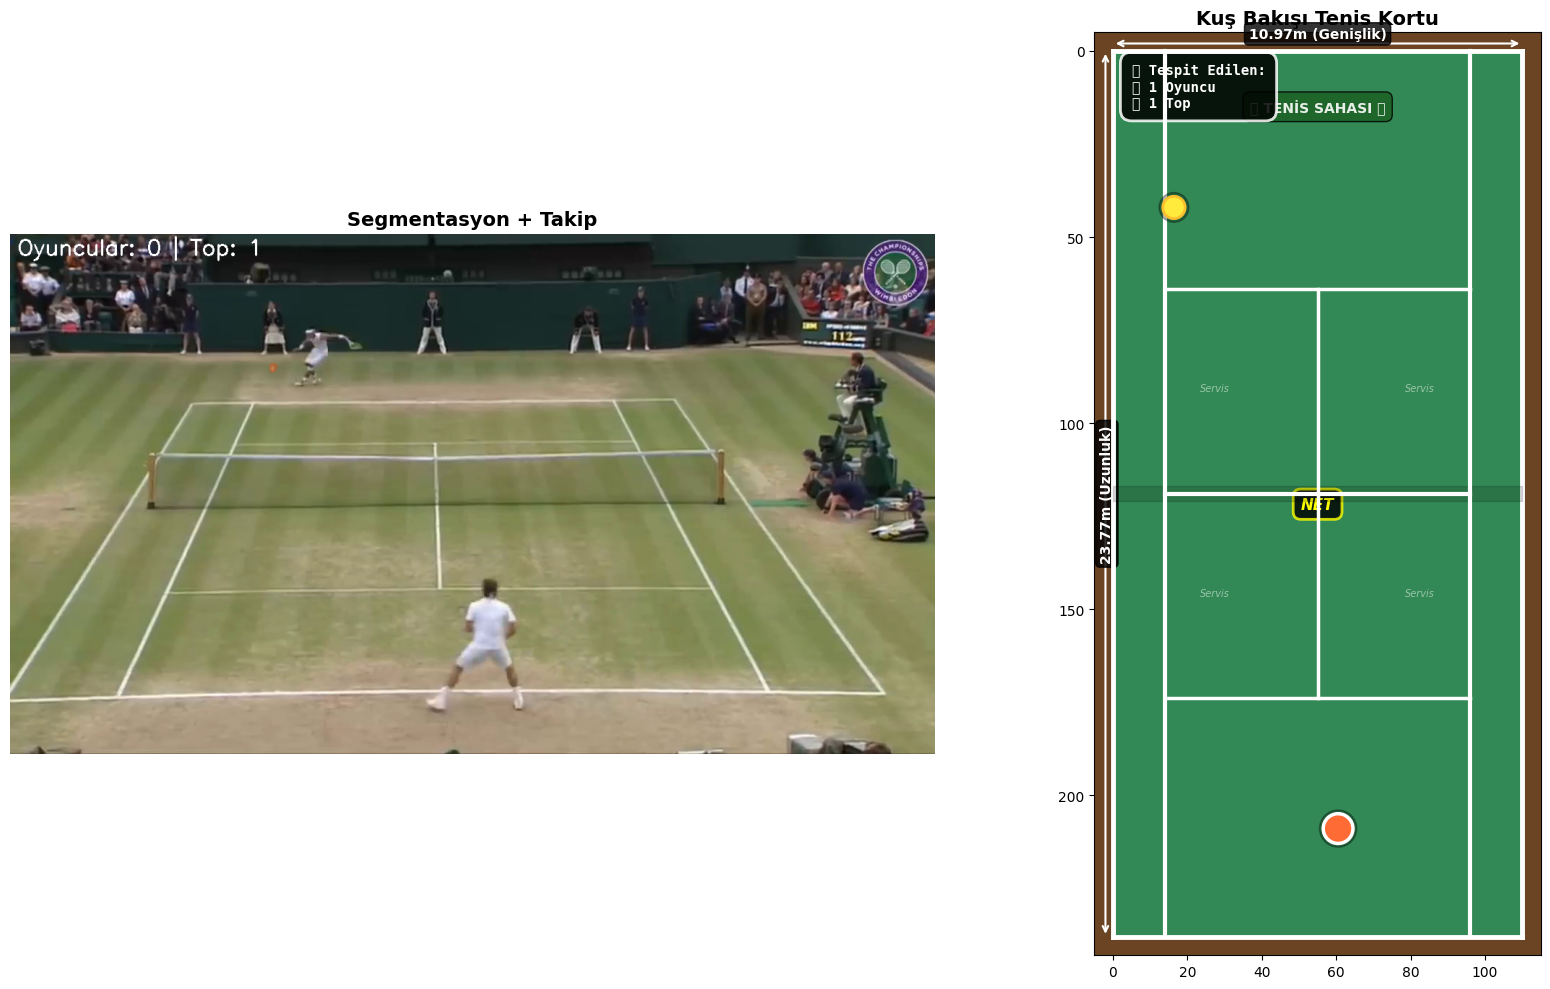

✅ Görsel kaydedildi: C:\Users\User\Desktop\kort\tenis_court_view.png

✅ Tek frame görselleştirme tamamlandı!
Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Tenis Kortu
Kort boyutları: 23.77m x 10.97m

📍 Kullanılan Koordinatlar:
  DIŞ ALAN (Kahverengi): TL[300, 140], BL[-50, 700], TR[870, 140], BR[1250, 700]
  İÇ ALAN (Yeşil Saha): TL[250, 240], BL[0, 640], TR[920, 230], BR[1210, 630]
  Perspektif dönüşüm: DIŞ alan koordinatları kullanılıyor (oyuncular için)
  Yeşil saha: İÇ alan koordinatları ile çiziliyor (görselleştirme)


In [4]:
# Tek Frame ile Tenis Sahası Kuş Bakışı Görünüm
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
from collections import defaultdict
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches

print("🎾 Tek Frame Analizi Başlatılıyor...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Video aç ve bir frame al
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Belirli bir frame'e git (örnek: 250. frame)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 250)
    ret, frame = cap.read()
    
    if ret:
        frame_height, frame_width = frame.shape[:2]
        original_frame = frame.copy()
        
        # Tenis sahası için perspektif dönüşüm noktaları
        # DIŞ ALAN koordinatları (Oyuncular + Saha)
        tl_outer = [300, 140]   # Top-Left Outer (Dış sol üst)
        bl_outer = [-50, 700]   # Bottom-Left Outer (Dış sol alt)
        tr_outer = [870, 140]   # Top-Right Outer (Dış sağ üst)
        br_outer = [1250, 700]  # Bottom-Right Outer (Dış sağ alt)
        
        # İÇ ALAN koordinatları (Sadece Tenis Sahası)
        tl_inner = [250, 240]   # Top-Left Inner (İç sol üst)
        bl_inner = [0, 640]     # Bottom-Left Inner (İç sol alt)
        tr_inner = [920, 230]   # Top-Right Inner (İç sağ üst)
        br_inner = [1210, 630]  # Bottom-Right Inner (İç sağ alt)
        
        # Perspektif dönüşüm için DIŞ ALAN koordinatlarını kullan (oyuncular burada)
        pts_src = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
        # Tenis kortu: 23.77m x 10.97m (tek maç için) - 238px x 110px (1m=10px)
        pts_dst = np.float32([[0, 0], [0, 238], [110, 238], [110, 0]])
        matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
        
        # SAM için frame hazırla
        sam_predictor.set_image(frame)
        
        # YOLOv8 ile tespit
        results = yolo_model(frame, conf=0.15, verbose=False)
        
        detections = []
        ball_detections = []
        player_boxes = []
        ball_boxes = []
        player_centers = []
        ball_centers = []
        
        # Threshold değerleri
        PLAYER_THRESHOLD = 0.5
        BALL_THRESHOLD = 0.15
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                
                # Merkez hesapla
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_detections.append((bbox, conf, class_name, [x1, y1, x2, y2]))
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        player_centers.append((cx, cy))
        
        # DeepSORT ile tracking (oyuncular)
        tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
        
        # Renk tanımlamaları
        PLAYER_COLOR = (0, 100, 200)     # Turuncu - Oyuncular
        BALL_COLOR = (0, 69, 255)         # Turuncu/Kırmızı - Top
        TEXT_COLOR = (255, 255, 255)      # Beyaz
        
        # Overlay oluştur
        overlay = frame.copy()
        display_frame = frame.copy()
        
        # SAM segmentasyon
        all_boxes = player_boxes + ball_boxes
        
        if len(all_boxes) > 0:
            # Oyuncu maskeleri
            for i, track in enumerate([t for t in tracks if t.is_confirmed()]):
                if i < len(player_boxes):
                    try:
                        input_box = np.array(player_boxes[i])
                        masks, _, _ = sam_predictor.predict(
                            point_coords=None,
                            point_labels=None,
                            box=input_box[None, :],
                            multimask_output=False,
                        )
                        
                        mask = masks[0]
                        overlay[mask] = overlay[mask] * 0.3 + np.array(PLAYER_COLOR) * 0.7
                    except:
                        pass
            
            # Top maskeleri
            for ball_box in ball_boxes:
                try:
                    input_box = np.array(ball_box)
                    masks, _, _ = sam_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )
                    
                    mask = masks[0]
                    overlay[mask] = overlay[mask] * 0.3 + np.array(BALL_COLOR) * 0.7
                except:
                    pass
        
        # Overlay'i frame ile birleştir
        display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)
        
        # Bilgi metni
        player_count = len([t for t in tracks if t.is_confirmed()])
        ball_count = len(ball_boxes)
        info_text = f'Oyuncular: {player_count} | Top: {ball_count}'
        cv2.putText(display_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 2)
        
        # Perspektif dönüşümü - Oyuncular ve top için (dış alan koordinatları kullanılıyor)
        transformed_players = []
        for px, py in player_centers:
            point = np.array([[[px, py]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_players.append((transformed[0][0][0], transformed[0][0][1]))
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # İç alan koordinatlarını dönüştür (görselleştirme için - yeşil saha)
        matrix_inner = cv2.getPerspectiveTransform(
            np.float32([tl_inner, bl_inner, br_inner, tr_inner]),
            np.float32([[0, 0], [0, 238], [110, 238], [110, 0]])
        )
        
        # İç alan köşelerini dönüştür
        inner_corners = []
        for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
            point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
            transformed_corner = cv2.perspectiveTransform(point, matrix_inner)
            inner_corners.append((transformed_corner[0][0][0], transformed_corner[0][0][1]))
        
        # Görselleştirme - Yan yana
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Segmentasyon + Takip', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı (23.77m x 10.97m - tenis kortu)
        # Görüntü sınırları - standart kort boyutu
        ax2.set_xlim(-5, 115)
        ax2.set_ylim(243, -5)
        
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Tenis Kortu', fontsize=14, fontweight='bold')
        
        # ========== KORT ÇİZİMİ - 2 KATMAN ==========
        
        # 0. EN DIŞ ALAN - Tüm kort (kahverengi zemin)
        dis_alan = patches.Rectangle((0, 0), 110, 238, linewidth=0, 
                                      facecolor='#8B6F47', alpha=0.85, zorder=1)
        ax2.add_patch(dis_alan)
        
        # 1. İÇ ALAN - Perspektif dönüştürülmüş yeşil saha (oyun alanı)
        if len(inner_corners) == 4:
            inner_poly = patches.Polygon(inner_corners, linewidth=0, 
                                         facecolor='#2E8B57', alpha=0.95, zorder=2)
            ax2.add_patch(inner_poly)
        else:
            # Fallback: standart dikdörtgen
            ic_saha = patches.Rectangle((0, 0), 110, 238, linewidth=0, 
                                        facecolor='#2E8B57', alpha=0.95, zorder=2)
            ax2.add_patch(ic_saha)
        
        # ========== BEYAZ ÇİZGİLER ==========
        
        # Ana dış çizgiler (Çift maç sınırları)
        ax2.plot([0, 110], [0, 0], 'white', linewidth=3.5, zorder=4)
        ax2.plot([0, 110], [238, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([0, 0], [0, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([110, 110], [0, 238], 'white', linewidth=3.5, zorder=4)
        
        # Tek maç yan çizgileri (1.37m = 14px içten)
        ax2.plot([14, 14], [0, 238], 'white', linewidth=3, zorder=5)
        ax2.plot([96, 96], [0, 238], 'white', linewidth=3, zorder=5)
        
        # Servis çizgileri (6.4m = 64px her yandan)
        ax2.plot([14, 96], [64, 64], 'white', linewidth=2.5, zorder=5)
        ax2.plot([14, 96], [174, 174], 'white', linewidth=2.5, zorder=5)
        
        # Orta servis çizgisi
        ax2.plot([55, 55], [64, 174], 'white', linewidth=2.5, zorder=5)
        
        # Orta çizgi (Net konumu) - Kalın
        ax2.plot([14, 96], [119, 119], 'white', linewidth=3, zorder=5)
        
        # Net gölgesi (3D efekt)
        ax2.fill_between([0, 110], 117, 121, color='black', alpha=0.15, zorder=4)
        
        # ========== OYUNCULAR VE TOP ==========
        
        # Oyuncular - Turuncu daireler
        for tx, ty in transformed_players:
            if 0 <= tx <= 110 and 0 <= ty <= 238:
                # Dış halka (gölge efekti)
                circle_shadow = patches.Circle((tx, ty), 5, color='black', alpha=0.3, zorder=9)
                ax2.add_patch(circle_shadow)
                # Ana daire
                circle = patches.Circle((tx, ty), 4, color='#FF6B35', ec='white', 
                                       linewidth=2.5, zorder=10)
                ax2.add_patch(circle)
        
        # Top - Sarı parlak daire
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 110 and 0 <= tby <= 238:
                # Gölge
                ball_shadow = patches.Circle((tbx, tby), 4, color='black', alpha=0.3, zorder=11)
                ax2.add_patch(ball_shadow)
                # Ana top
                circle = patches.Circle((tbx, tby), 3, color='#FFEB3B', ec='#FBC02D', 
                                       linewidth=2, zorder=12)
                ax2.add_patch(circle)
        
        # ========== ARKA PLAN VE DETAYLAR ==========
        
        ax2.set_facecolor('#6B4423')  # Koyu kahverengi arka plan (dış alan devamı)
        
        # Alan açıklamaları - İç alanı göster
        if len(inner_corners) == 4:
            # İç alan sınırlarını çiz
            inner_line = patches.Polygon(inner_corners, linewidth=2, 
                                        edgecolor='white', facecolor='none', 
                                        linestyle='-', alpha=0.6, zorder=3)
            ax2.add_patch(inner_line)
        
        ax2.text(55, 15, '🎾 TENİS SAHASI 🎾', fontsize=10, color='white', ha='center', 
                va='center', weight='bold', alpha=0.9,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#1B5E20', alpha=0.8))
        
        # Servis kutuları etiketi
        ax2.text(27.5, 91.5, 'Servis', fontsize=7, color='white', ha='center', 
                alpha=0.5, style='italic')
        ax2.text(82.5, 91.5, 'Servis', fontsize=7, color='white', ha='center', 
                alpha=0.5, style='italic')
        ax2.text(27.5, 146.5, 'Servis', fontsize=7, color='white', ha='center', 
                alpha=0.5, style='italic')
        ax2.text(82.5, 146.5, 'Servis', fontsize=7, color='white', ha='center', 
                alpha=0.5, style='italic')
        
        # ========== ÖLÇÜ ETİKETLERİ ==========
        
        # Genişlik ölçüsü (üstte)
        ax2.annotate('', xy=(110, -2), xytext=(0, -2),
                    arrowprops=dict(arrowstyle='<->', color='white', lw=1.5))
        ax2.text(55, -3.5, '10.97m (Genişlik)', fontsize=10, color='white', 
                ha='center', weight='bold',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
        
        # Uzunluk ölçüsü (solda)
        ax2.annotate('', xy=(-2, 238), xytext=(-2, 0),
                    arrowprops=dict(arrowstyle='<->', color='white', lw=1.5))
        ax2.text(-3.5, 119, '23.77m (Uzunluk)', fontsize=10, color='white', 
                rotation=90, va='center', weight='bold',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
        
        # NET etiketi
        ax2.text(55, 123, 'NET', fontsize=11, color='yellow', ha='center', 
                weight='bold', style='italic',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', 
                         edgecolor='yellow', alpha=0.8, linewidth=2))
        
        # İstatistik kutusu
        info_text_bird = f'📊 Tespit Edilen:\n👥 {len(transformed_players)} Oyuncu\n🎾 {len(transformed_balls)} Top'
        ax2.text(5, 15, info_text_bird, fontsize=10, color='white',
                weight='bold', family='monospace',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='black', 
                         edgecolor='white', alpha=0.85, linewidth=2))
        
        plt.tight_layout()
        
        # Görseli kaydet ve göster
        output_image = r'C:\Users\User\Desktop\kort\tenis_court_view.png'
        plt.savefig(output_image, dpi=150, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print(f"✅ Görsel kaydedildi: {output_image}")
        print(f"\n✅ Tek frame görselleştirme tamamlandı!")
        print(f"Sol: Segmentasyon + Takip | Sağ: Kuş Bakışı Tenis Kortu")
        print(f"Kort boyutları: 23.77m x 10.97m")
        print(f"\n📍 Kullanılan Koordinatlar:")
        print(f"  DIŞ ALAN (Kahverengi): TL{tl_outer}, BL{bl_outer}, TR{tr_outer}, BR{br_outer}")
        print(f"  İÇ ALAN (Yeşil Saha): TL{tl_inner}, BL{bl_inner}, TR{tr_inner}, BR{br_inner}")
        print(f"  Perspektif dönüşüm: DIŞ alan koordinatları kullanılıyor (oyuncular için)")
        print(f"  Yeşil saha: İÇ alan koordinatları ile çiziliyor (görselleştirme)")
    
    cap.release()

# Cell 11 — Kort tespit denemeleri ve alternatif yöntemler
Bu hücrede Hough, HSV maskeleri, Roboflow gibi kort tespiti denemeleri ve notları yer alır.

In [59]:
# İlk 100 Frame için Tenis Sahası Kuş Bakışı Görünüm - Video Output
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
from collections import defaultdict
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

print("🎾 İlk 100 Frame Video Analizi Başlatılıyor...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_video_path = r'C:\Users\User\Desktop\kort\nadal_court_view_100frames.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Video aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Video bilgileri
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"📹 Video: {total_frames} frame, {fps} FPS")
    print(f"🎬 İlk 100 frame video olarak işlenecek...")
    
    # Video writer için boyut (18x10 inch * 100 dpi = 1800x1000)
    output_width = 1800
    output_height = 1000
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_width, output_height))
    
    # Koordinatlar
    tl_outer = [300, 150]
    bl_outer = [-50, 700]
    tr_outer = [870, 150]
    br_outer = [1250, 700]
    
    tl_inner = [250, 240]
    bl_inner = [0, 640]
    tr_inner = [920, 230]
    br_inner = [1210, 630]
    
    # Perspektif matrisleri
    pts_src = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
    pts_dst = np.float32([[0, 0], [0, 238], [110, 238], [110, 0]])
    matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
    
    matrix_inner = cv2.getPerspectiveTransform(
        np.float32([tl_inner, bl_inner, br_inner, tr_inner]),
        np.float32([[0, 0], [0, 238], [110, 238], [110, 0]])
    )
    
    # İç alan köşelerini önceden hesapla
    inner_corners = []
    for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
        point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
        transformed_corner = cv2.perspectiveTransform(point, matrix_inner)
        inner_corners.append((transformed_corner[0][0][0], transformed_corner[0][0][1]))
    
    # Threshold değerleri
    PLAYER_THRESHOLD = 0.5
    BALL_THRESHOLD = 0.15
    
    # Renk tanımlamaları
    PLAYER_COLOR = (0, 100, 200)
    BALL_COLOR = (0, 69, 255)
    TEXT_COLOR = (255, 255, 255)
    
    frame_count = 0
    max_frames = 100
    
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # SAM için frame hazırla
        sam_predictor.set_image(frame)
        
        # YOLOv8 ile tespit
        results = yolo_model(frame, conf=0.15, verbose=False)
        
        detections = []
        player_boxes = []
        ball_boxes = []
        player_centers = []
        ball_centers = []
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        player_centers.append((cx, cy))
        
        # DeepSORT ile tracking
        tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
        
        # Overlay oluştur
        overlay = frame.copy()
        display_frame = frame.copy()
        
        # SAM segmentasyon - Oyuncular
        for i, track in enumerate([t for t in tracks if t.is_confirmed()]):
            if i < len(player_boxes):
                try:
                    input_box = np.array(player_boxes[i])
                    masks, _, _ = sam_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )
                    mask = masks[0]
                    overlay[mask] = overlay[mask] * 0.3 + np.array(PLAYER_COLOR) * 0.7
                except:
                    pass
        
        # SAM segmentasyon - Top
        for ball_box in ball_boxes:
            try:
                input_box = np.array(ball_box)
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                overlay[mask] = overlay[mask] * 0.3 + np.array(BALL_COLOR) * 0.7
            except:
                pass
        
        # Overlay birleştir
        display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)
        
        # Bilgi metni
        player_count = len([t for t in tracks if t.is_confirmed()])
        ball_count = len(ball_boxes)
        info_text = f'Frame: {frame_count} | Oyuncular: {player_count} | Top: {ball_count}'
        cv2.putText(display_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 2)
        
        # Perspektif dönüşümü
        transformed_players = []
        for px, py in player_centers:
            point = np.array([[[px, py]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_players.append((transformed[0][0][0], transformed[0][0][1]))
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Görselleştirme
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title(f'Segmentasyon + Takip (Frame {frame_count})', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı
        ax2.set_xlim(-5, 115)
        ax2.set_ylim(243, -5)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Tenis Kortu', fontsize=14, fontweight='bold')
        
        # Kort çizimi
        dis_alan = patches.Rectangle((0, 0), 110, 238, linewidth=0, 
                                      facecolor='#8B6F47', alpha=0.85, zorder=1)
        ax2.add_patch(dis_alan)
        
        if len(inner_corners) == 4:
            inner_poly = patches.Polygon(inner_corners, linewidth=0, 
                                         facecolor='#2E8B57', alpha=0.95, zorder=2)
            ax2.add_patch(inner_poly)
        
        # Beyaz çizgiler
        ax2.plot([0, 110], [0, 0], 'white', linewidth=3.5, zorder=4)
        ax2.plot([0, 110], [238, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([0, 0], [0, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([110, 110], [0, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([14, 14], [0, 238], 'white', linewidth=3, zorder=5)
        ax2.plot([96, 96], [0, 238], 'white', linewidth=3, zorder=5)
        ax2.plot([14, 96], [64, 64], 'white', linewidth=2.5, zorder=5)
        ax2.plot([14, 96], [174, 174], 'white', linewidth=2.5, zorder=5)
        ax2.plot([55, 55], [64, 174], 'white', linewidth=2.5, zorder=5)
        ax2.plot([14, 96], [119, 119], 'white', linewidth=3, zorder=5)
        ax2.fill_between([0, 110], 117, 121, color='black', alpha=0.15, zorder=4)
        
        # Oyuncular
        for tx, ty in transformed_players:
            if 0 <= tx <= 110 and 0 <= ty <= 238:
                circle_shadow = patches.Circle((tx, ty), 5, color='black', alpha=0.3, zorder=9)
                ax2.add_patch(circle_shadow)
                circle = patches.Circle((tx, ty), 4, color='#FF6B35', ec='white', 
                                       linewidth=2.5, zorder=10)
                ax2.add_patch(circle)
        
        # Top
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 110 and 0 <= tby <= 238:
                ball_shadow = patches.Circle((tbx, tby), 4, color='black', alpha=0.3, zorder=11)
                ax2.add_patch(ball_shadow)
                circle = patches.Circle((tbx, tby), 3, color='#FFEB3B', ec='#FBC02D', 
                                       linewidth=2, zorder=12)
                ax2.add_patch(circle)
        
        # Arka plan ve detaylar
        ax2.set_facecolor('#6B4423')
        
        if len(inner_corners) == 4:
            inner_line = patches.Polygon(inner_corners, linewidth=2, 
                                        edgecolor='white', facecolor='none', 
                                        linestyle='-', alpha=0.6, zorder=3)
            ax2.add_patch(inner_line)
        
        ax2.text(55, 15, '🎾 TENİS SAHASI 🎾', fontsize=10, color='white', ha='center', 
                va='center', weight='bold', alpha=0.9,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#1B5E20', alpha=0.8))
        
        # İstatistik kutusu
        info_text_bird = f'📊 Frame {frame_count}/100\n👥 {len(transformed_players)} Oyuncu\n🎾 {len(transformed_balls)} Top'
        ax2.text(5, 15, info_text_bird, fontsize=10, color='white',
                weight='bold', family='monospace',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='black', 
                         edgecolor='white', alpha=0.85, linewidth=2))
        
        plt.tight_layout()
        
        # Matplotlib figürünü numpy array'e çevir
        canvas = FigureCanvasAgg(fig)
        canvas.draw()
        buf = canvas.buffer_rgba()
        frame_array = np.asarray(buf)
        
        # RGBA'dan BGR'ye çevir ve boyutlandır
        frame_bgr = cv2.cvtColor(frame_array, cv2.COLOR_RGBA2BGR)
        frame_resized = cv2.resize(frame_bgr, (output_width, output_height))
        
        # Video'ya yaz
        out.write(frame_resized)
        
        plt.close()
        
        # İlerleme göster
        if frame_count % 10 == 0:
            print(f"⏳ İşlenen: {frame_count}/{max_frames} frame ({frame_count}%)")
    
    cap.release()
    out.release()
    
    print(f"\n✅ Video işleme tamamlandı!")
    print(f"✅ Toplam {frame_count} frame işlendi")
    print(f"✅ Video kaydedildi: {output_video_path}")
    print(f"\n📊 Özet:")
    print(f"  - Çıktı dosyası: {output_video_path}")
    print(f"  - Video boyutu: {output_width}x{output_height}")
    print(f"  - FPS: {fps}")
    print(f"  - Frame sayısı: {frame_count}")
    print(f"  - Format: Segmentasyon (Sol) + Kuş Bakışı (Sağ)")


🎾 İlk 100 Frame Video Analizi Başlatılıyor...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
📹 Video: 497 frame, 30 FPS
🎬 İlk 100 frame video olarak işlenecek...
✅ MobileSAM yüklendi (cpu)
📹 Video: 497 frame, 30 FPS
🎬 İlk 100 frame video olarak işlenecek...


C:\Users\User\AppData\Local\Temp\ipykernel_8472\543525337.py:269: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_8472\543525337.py:269: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_8472\543525337.py:269: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_8472\543525337.py:269: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_8472\543525337.py:273: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  canvas.draw()
C:\Users\User\AppData\Local\Temp\ipykernel_8472\543525337.py:273: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from fo

⏳ İşlenen: 10/100 frame (10%)
⏳ İşlenen: 20/100 frame (20%)
⏳ İşlenen: 20/100 frame (20%)
⏳ İşlenen: 30/100 frame (30%)
⏳ İşlenen: 30/100 frame (30%)
⏳ İşlenen: 40/100 frame (40%)
⏳ İşlenen: 40/100 frame (40%)
⏳ İşlenen: 50/100 frame (50%)
⏳ İşlenen: 50/100 frame (50%)
⏳ İşlenen: 60/100 frame (60%)
⏳ İşlenen: 60/100 frame (60%)
⏳ İşlenen: 70/100 frame (70%)
⏳ İşlenen: 70/100 frame (70%)
⏳ İşlenen: 80/100 frame (80%)
⏳ İşlenen: 80/100 frame (80%)
⏳ İşlenen: 90/100 frame (90%)
⏳ İşlenen: 90/100 frame (90%)
⏳ İşlenen: 100/100 frame (100%)

✅ Video işleme tamamlandı!
✅ Toplam 100 frame işlendi
✅ Video kaydedildi: C:\Users\User\Desktop\kort\nadal_court_view_100frames.mp4

📊 Özet:
  - Çıktı dosyası: C:\Users\User\Desktop\kort\nadal_court_view_100frames.mp4
  - Video boyutu: 1800x1000
  - FPS: 30
  - Frame sayısı: 100
  - Format: Segmentasyon (Sol) + Kuş Bakışı (Sağ)
⏳ İşlenen: 100/100 frame (100%)

✅ Video işleme tamamlandı!
✅ Toplam 100 frame işlendi
✅ Video kaydedildi: C:\Users\User\Deskto

# Cell 12 — Veri ön işleme / filtreleme
Bu hücre, tespit sonuçlarının filtrelenmesi, eşiklerin uygulanması ve hazırlık adımlarını içerir.

In [3]:
# TÜM VİDEO için Tenis Sahası Kuş Bakışı Görünüm - Güncellenmiş
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
from collections import defaultdict
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

print("🎾 TÜM VİDEO Analizi Başlatılıyor...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_video_path = r'C:\Users\User\Desktop\kort\nadal_court_view_full.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Takip geçmişi için
track_history = defaultdict(lambda: [])
ball_history = []

# Video aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Video bilgileri
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"📹 Video: {total_frames} frame, {fps} FPS")
    print(f"🎬 Tüm video işlenecek...")
    
    # Video writer için boyut (18x10 inch * 100 dpi = 1800x1000)
    output_width = 1800
    output_height = 1000
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_width, output_height))
    
    # Koordinatlar
    tl_outer = [300, 150]
    bl_outer = [-50, 700]
    tr_outer = [870, 150]
    br_outer = [1250, 700]
    
    tl_inner = [250, 240]
    bl_inner = [0, 640]
    tr_inner = [920, 230]
    br_inner = [1210, 630]
    
    # Perspektif matrisleri
    pts_src = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
    pts_dst = np.float32([[0, 0], [0, 238], [110, 238], [110, 0]])
    matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
    
    matrix_inner = cv2.getPerspectiveTransform(
        np.float32([tl_inner, bl_inner, br_inner, tr_inner]),
        np.float32([[0, 0], [0, 238], [110, 238], [110, 0]])
    )
    
    # İç alan köşelerini önceden hesapla
    inner_corners = []
    for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
        point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
        transformed_corner = cv2.perspectiveTransform(point, matrix_inner)
        inner_corners.append((transformed_corner[0][0][0], transformed_corner[0][0][1]))
    
    # Threshold değerleri
    PLAYER_THRESHOLD = 0.5
    BALL_THRESHOLD = 0.15
    
    # Renk tanımlamaları
    PLAYER_COLOR = (0, 100, 200)
    BALL_COLOR = (0, 69, 255)
    TEXT_COLOR = (255, 255, 255)
    TRACK_COLOR = (255, 255, 0)      # Cyan - Takip çizgisi (oyuncular)
    BALL_TRACK_COLOR = (255, 0, 255) # Magenta - Top takip çizgisi
    
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # SAM için frame hazırla
        sam_predictor.set_image(frame)
        
        # YOLOv8 ile tespit
        results = yolo_model(frame, conf=0.15, verbose=False)
        
        detections = []
        player_boxes = []
        ball_boxes = []
        player_feet_centers = []  # Oyuncuların AYAK konumları
        ball_centers = []
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                
                # Merkez hesapla
                cx = (x1 + x2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        # Top için normal merkez
                        cy = (y1 + y2) / 2
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        # Oyuncular için AYAK konumu (bounding box'ın ALT ortası)
                        foot_y = y2  # Alt kenar
                        player_feet_centers.append((cx, foot_y))
        
        # DeepSORT ile tracking
        tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
        
        # Overlay oluştur
        overlay = frame.copy()
        display_frame = frame.copy()
        
        # Tracking ID'leri ve ayak konumları eşleştir
        confirmed_tracks = [t for t in tracks if t.is_confirmed()]
        track_feet_map = {}
        
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_feet_centers):
                track_id = track.track_id
                foot_x, foot_y = player_feet_centers[i]
                track_feet_map[track_id] = (foot_x, foot_y)
                
                # Takip geçmişine ekle (ayak konumu)
                track_history[track_id].append((foot_x, foot_y))
                if len(track_history[track_id]) > 15:  # Son 15 frame
                    track_history[track_id].pop(0)
        
        # Top geçmişi
        for bx, by in ball_centers:
            ball_history.append((bx, by))
            if len(ball_history) > 25:  # Son 25 frame
                ball_history.pop(0)
        
        # SAM segmentasyon - Oyuncular
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_boxes):
                try:
                    input_box = np.array(player_boxes[i])
                    masks, _, _ = sam_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )
                    mask = masks[0]
                    overlay[mask] = overlay[mask] * 0.3 + np.array(PLAYER_COLOR) * 0.7
                except:
                    pass
        
        # SAM segmentasyon - Top (KOYU)
        for ball_box in ball_boxes:
            try:
                input_box = np.array(ball_box)
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                # Top için daha koyu renk (0.8 oran)
                overlay[mask] = overlay[mask] * 0.2 + np.array(BALL_COLOR) * 0.8
            except:
                pass
        
        # Overlay birleştir
        display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)
        
        # Takip çizgilerini çiz - Oyuncular
        for track_id, positions in track_history.items():
            if len(positions) > 1:
                points = np.array(positions, dtype=np.int32)
                cv2.polylines(display_frame, [points], False, TRACK_COLOR, 2)
        
        # Takip çizgisi - Top
        if len(ball_history) > 1:
            points = np.array(ball_history, dtype=np.int32)
            cv2.polylines(display_frame, [points], False, BALL_TRACK_COLOR, 2)
        
        # Bilgi metni
        player_count = len(confirmed_tracks)
        ball_count = len(ball_boxes)
        info_text = f'Frame: {frame_count}/{total_frames} | Oyuncular: {player_count} | Top: {ball_count}'
        cv2.putText(display_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 2)
        
        # Perspektif dönüşümü - AYAK konumlarını kullan
        transformed_players = []
        transformed_player_tracks = {}
        
        for track_id, (foot_x, foot_y) in track_feet_map.items():
            point = np.array([[[foot_x, foot_y]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            tx, ty = transformed[0][0][0], transformed[0][0][1]
            transformed_players.append((tx, ty))
            transformed_player_tracks[track_id] = (tx, ty)
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Kuş bakışı için takip çizgilerini dönüştür
        transformed_track_history = {}
        for track_id, positions in track_history.items():
            transformed_track_history[track_id] = []
            for px, py in positions:
                point = np.array([[[px, py]]], dtype=np.float32)
                transformed = cv2.perspectiveTransform(point, matrix)
                transformed_track_history[track_id].append((transformed[0][0][0], transformed[0][0][1]))
        
        # Top geçmişini dönüştür
        transformed_ball_history = []
        for bx, by in ball_history:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_ball_history.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Görselleştirme
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title(f'Segmentasyon + Takip (Frame {frame_count}/{total_frames})', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı
        ax2.set_xlim(-5, 115)
        ax2.set_ylim(243, -5)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Tenis Kortu', fontsize=14, fontweight='bold')
        
        # Kort çizimi
        dis_alan = patches.Rectangle((0, 0), 110, 238, linewidth=0, 
                                      facecolor='#8B6F47', alpha=0.85, zorder=1)
        ax2.add_patch(dis_alan)
        
        if len(inner_corners) == 4:
            inner_poly = patches.Polygon(inner_corners, linewidth=0, 
                                         facecolor='#2E8B57', alpha=0.95, zorder=2)
            ax2.add_patch(inner_poly)
        
        # Beyaz çizgiler
        ax2.plot([0, 110], [0, 0], 'white', linewidth=3.5, zorder=4)
        ax2.plot([0, 110], [238, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([0, 0], [0, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([110, 110], [0, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([14, 14], [0, 238], 'white', linewidth=3, zorder=5)
        ax2.plot([96, 96], [0, 238], 'white', linewidth=3, zorder=5)
        ax2.plot([14, 96], [64, 64], 'white', linewidth=2.5, zorder=5)
        ax2.plot([14, 96], [174, 174], 'white', linewidth=2.5, zorder=5)
        ax2.plot([55, 55], [64, 174], 'white', linewidth=2.5, zorder=5)
        ax2.plot([14, 96], [119, 119], 'white', linewidth=3, zorder=5)
        ax2.fill_between([0, 110], 117, 121, color='black', alpha=0.15, zorder=4)
        
        # Takip çizgileri - Oyuncular (kuş bakışı)
        for track_id, positions in transformed_track_history.items():
            if len(positions) > 1:
                valid_positions = [(x, y) for x, y in positions if 0 <= x <= 110 and 0 <= y <= 238]
                if len(valid_positions) > 1:
                    xs, ys = zip(*valid_positions)
                    ax2.plot(xs, ys, color='cyan', linewidth=2, alpha=0.7, zorder=8)
        
        # Takip çizgisi - Top (kuş bakışı)
        if len(transformed_ball_history) > 1:
            valid_ball_positions = [(x, y) for x, y in transformed_ball_history if 0 <= x <= 110 and 0 <= y <= 238]
            if len(valid_ball_positions) > 1:
                xs, ys = zip(*valid_ball_positions)
                ax2.plot(xs, ys, color='magenta', linewidth=2, alpha=0.7, zorder=8)
        
        # Oyuncular
        for tx, ty in transformed_players:
            if 0 <= tx <= 110 and 0 <= ty <= 238:
                circle_shadow = patches.Circle((tx, ty), 5, color='black', alpha=0.3, zorder=9)
                ax2.add_patch(circle_shadow)
                circle = patches.Circle((tx, ty), 4, color='#FF6B35', ec='white', 
                                       linewidth=2.5, zorder=10)
                ax2.add_patch(circle)
        
        # Top (KOYU SARI)
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 110 and 0 <= tby <= 238:
                ball_shadow = patches.Circle((tbx, tby), 4, color='black', alpha=0.4, zorder=11)
                ax2.add_patch(ball_shadow)
                circle = patches.Circle((tbx, tby), 3, color='#FFD700', ec='#FF8C00', 
                                       linewidth=2.5, zorder=12)
                ax2.add_patch(circle)
        
        # Arka plan ve detaylar
        ax2.set_facecolor('#6B4423')
        
        if len(inner_corners) == 4:
            inner_line = patches.Polygon(inner_corners, linewidth=2, 
                                        edgecolor='white', facecolor='none', 
                                        linestyle='-', alpha=0.6, zorder=3)
            ax2.add_patch(inner_line)
        
        ax2.text(55, 15, '🎾 TENİS SAHASI 🎾', fontsize=10, color='white', ha='center', 
                va='center', weight='bold', alpha=0.9,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#1B5E20', alpha=0.8))
        
        # İstatistik kutusu
        info_text_bird = f'📊 Frame {frame_count}/{total_frames}\n👥 {len(transformed_players)} Oyuncu\n🎾 {len(transformed_balls)} Top'
        ax2.text(5, 15, info_text_bird, fontsize=10, color='white',
                weight='bold', family='monospace',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='black', 
                         edgecolor='white', alpha=0.85, linewidth=2))
        
        plt.tight_layout()
        
        # Matplotlib figürünü numpy array'e çevir
        canvas = FigureCanvasAgg(fig)
        canvas.draw()
        buf = canvas.buffer_rgba()
        frame_array = np.asarray(buf)
        
        # RGBA'dan BGR'ye çevir ve boyutlandır
        frame_bgr = cv2.cvtColor(frame_array, cv2.COLOR_RGBA2BGR)
        frame_resized = cv2.resize(frame_bgr, (output_width, output_height))
        
        # Video'ya yaz
        out.write(frame_resized)
        
        plt.close()
        
        # İlerleme göster
        if frame_count % 30 == 0:
            print(f"⏳ İşlenen: {frame_count}/{total_frames} frame ({frame_count*100//total_frames}%)")
    
    cap.release()
    out.release()
    
    print(f"\n✅ Video işleme tamamlandı!")
    print(f"✅ Toplam {frame_count} frame işlendi")
    print(f"✅ Video kaydedildi: {output_video_path}")
    print(f"\n📊 Özet:")
    print(f"  - Çıktı dosyası: {output_video_path}")
    print(f"  - Video boyutu: {output_width}x{output_height}")
    print(f"  - FPS: {fps}")
    print(f"  - Frame sayısı: {frame_count}")
    print(f"  - Format: Segmentasyon (Sol) + Kuş Bakışı (Sağ)")
    print(f"\n🎯 Güncellemeler:")
    print(f"  ✅ Takip çizgileri eklendi (Cyan: Oyuncular, Magenta: Top)")
    print(f"  ✅ Top koyu sarı renkte (#FFD700)")
    print(f"  ✅ Oyuncu konumları ayak pozisyonundan alınıyor (daha doğru)")


🎾 TÜM VİDEO Analizi Başlatılıyor...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
✅ MobileSAM yüklendi (cpu)


c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


📹 Video: 497 frame, 30 FPS
🎬 Tüm video işlenecek...


C:\Users\User\AppData\Local\Temp\ipykernel_9628\2692099496.py:346: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9628\2692099496.py:346: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9628\2692099496.py:346: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9628\2692099496.py:346: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_9628\2692099496.py:350: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  canvas.draw()
C:\Users\User\AppData\Local\Temp\ipykernel_9628\2692099496.py:350: UserWarning: Glyph 128202 (\N{BAR CHART}) missing f

⏳ İşlenen: 30/497 frame (6%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 90/497 frame (18%)
⏳ İşlenen: 90/497 frame (18%)
⏳ İşlenen: 120/497 frame (24%)
⏳ İşlenen: 120/497 frame (24%)
⏳ İşlenen: 150/497 frame (30%)
⏳ İşlenen: 150/497 frame (30%)
⏳ İşlenen: 180/497 frame (36%)
⏳ İşlenen: 180/497 frame (36%)
⏳ İşlenen: 210/497 frame (42%)
⏳ İşlenen: 210/497 frame (42%)
⏳ İşlenen: 240/497 frame (48%)
⏳ İşlenen: 240/497 frame (48%)
⏳ İşlenen: 270/497 frame (54%)
⏳ İşlenen: 270/497 frame (54%)
⏳ İşlenen: 300/497 frame (60%)
⏳ İşlenen: 300/497 frame (60%)
⏳ İşlenen: 330/497 frame (66%)
⏳ İşlenen: 330/497 frame (66%)
⏳ İşlenen: 360/497 frame (72%)
⏳ İşlenen: 360/497 frame (72%)
⏳ İşlenen: 390/497 frame (78%)
⏳ İşlenen: 390/497 frame (78%)
⏳ İşlenen: 420/497 frame (84%)
⏳ İşlenen: 420/497 frame (84%)
⏳ İşlenen: 450/497 frame (90%)
⏳ İşlenen: 450/497 frame (90%)
⏳ İşlenen: 480/497 frame (96%)
⏳ İşlenen: 480/497 frame (96%)

✅ Video işleme tamamlandı!
✅ Toplam 497 fram

# Cell 13 — Smart positioning mantığı
Bu hücre, oyuncular için 'yakın=ayak, uzak=baş' mantığını uygular ve pozisyon seçimini belirler.

In [3]:
# TÜM VİDEO - Düzeltilmiş Perspektif ve Takip Çizgileri
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
from collections import defaultdict
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

print("🎾 TÜM VİDEO Analizi - Düzeltilmiş Versiyon...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_video_path = r'C:\Users\User\Desktop\kort\nadal_court_fixed2.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Takip geçmişi için
track_history = defaultdict(lambda: [])
ball_history = []

# Video aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Video bilgileri
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"📹 Video: {total_frames} frame, {fps} FPS")
    print(f"🎬 Tüm video işlenecek...")
    
    # Video writer için boyut
    output_width = 1800
    output_height = 1000
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_width, output_height))
    
    # ⚠️ DÜZELTİLMİŞ KOORDINATLAR - Daha geniş alan
    # DIŞ ALAN: Oyuncuların olduğu tüm alanı kapsamalı (VIDEO koordinatları)
    tl_outer = [250, 100]    # Daha yukarı ve sola
    bl_outer = [-100, 750]   # Daha aşağı ve sola
    tr_outer = [920, 100]    # Daha yukarı ve sağa
    br_outer = [1300, 750]   # Daha aşağı ve sağa
    
    # İÇ ALAN: Tenis sahası çizgileri (VIDEO koordinatları)
    tl_inner = [250, 240]
    bl_inner = [0, 640]
    tr_inner = [920, 230]
    br_inner = [1210, 630]
    
    # 📐 Piksel hesaplamaları (1m = 10px)
    # İÇ ALAN: 23.8m × 11.0m → 248px × 110px
    inner_width = 110   # 11.0m
    inner_height = 238  # 23.8m
    
    # DIŞ ALAN boyutu: Video koordinatlarındaki oran kadar daha büyük
    # Video'da DIŞ/İÇ oranı hesapla
    outer_video_width = 1300 - (-100)  # 1400 piksel
    inner_video_width = 1210 - 0       # 1210 piksel
    outer_video_height = 750 - 100     # 650 piksel
    inner_video_height = 640 - 240     # 400 piksel
    
    width_ratio = outer_video_width / inner_video_width    # ~1.157
    height_ratio = outer_video_height / inner_video_height # ~1.625
    
    # DIŞ ALAN boyutları
    outer_width = int(inner_width * width_ratio)     # ~127 piksel
    outer_height = int(inner_height * height_ratio)  # ~403 piksel
    
    # İÇ ALAN'ın DIŞ ALAN içindeki offset'i (merkezleme)
    offset_x = (outer_width - inner_width) // 2
    offset_y = (outer_height - inner_height) // 2
    
    # Perspektif matrisleri - FARKLI BOYUTLARDA
    pts_src_outer = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
    pts_dst_outer = np.float32([[0, 0], [0, outer_height], [outer_width, outer_height], [outer_width, 0]])
    matrix = cv2.getPerspectiveTransform(pts_src_outer, pts_dst_outer)
    
    pts_src_inner = np.float32([tl_inner, bl_inner, br_inner, tr_inner])
    pts_dst_inner = np.float32([[offset_x, offset_y], 
                                 [offset_x, offset_y + inner_height], 
                                 [offset_x + inner_width, offset_y + inner_height], 
                                 [offset_x + inner_width, offset_y]])
    matrix_inner = cv2.getPerspectiveTransform(pts_src_inner, pts_dst_inner)
    
    # İç alan köşelerini önceden hesapla (İÇ ALAN matrix kullanarak)
    inner_corners = []
    for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
        point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
        transformed_corner = cv2.perspectiveTransform(point, matrix_inner)
        inner_corners.append((transformed_corner[0][0][0], transformed_corner[0][0][1]))
    
    # Threshold değerleri
    PLAYER_THRESHOLD = 0.5
    BALL_THRESHOLD = 0.15
    
    # Renk tanımlamaları
    PLAYER_COLOR = (0, 100, 200)
    BALL_COLOR = (0, 69, 255)
    TEXT_COLOR = (255, 255, 255)
    TRACK_COLOR = (255, 255, 0)      # Cyan - Takip çizgisi (oyuncular)
    BALL_TRACK_COLOR = (255, 0, 255) # Magenta - Top takip çizgisi
    
    # Oyuncu renkleri (farklılaştırmak için)
    PLAYER_COLORS = ['#FF6B35', '#4ECDC4', '#95E1D3', '#F38181']
    
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # SAM için frame hazırla
        sam_predictor.set_image(frame)
        
        # YOLOv8 ile tespit
        results = yolo_model(frame, conf=0.15, verbose=False)
        
        detections = []
        player_boxes = []
        ball_boxes = []
        player_feet_centers = []
        ball_centers = []
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                
                cx = (x1 + x2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        cy = (y1 + y2) / 2
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        foot_y = y2
                        player_feet_centers.append((cx, foot_y))
        
        # DeepSORT ile tracking
        tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
        
        # Overlay oluştur
        overlay = frame.copy()
        display_frame = frame.copy()
        
        # Tracking ID'leri ve ayak konumları eşleştir
        confirmed_tracks = [t for t in tracks if t.is_confirmed()]
        track_feet_map = {}
        
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_feet_centers):
                track_id = track.track_id
                foot_x, foot_y = player_feet_centers[i]
                track_feet_map[track_id] = (foot_x, foot_y)
                
                # Takip geçmişine ekle
                track_history[track_id].append((foot_x, foot_y))
                if len(track_history[track_id]) > 15:
                    track_history[track_id].pop(0)
        
        # Top geçmişi
        for bx, by in ball_centers:
            ball_history.append((bx, by))
            if len(ball_history) > 25:
                ball_history.pop(0)
        
        # SAM segmentasyon - Oyuncular
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_boxes):
                try:
                    input_box = np.array(player_boxes[i])
                    masks, _, _ = sam_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )
                    mask = masks[0]
                    overlay[mask] = overlay[mask] * 0.3 + np.array(PLAYER_COLOR) * 0.7
                except:
                    pass
        
        # SAM segmentasyon - Top (KOYU)
        for ball_box in ball_boxes:
            try:
                input_box = np.array(ball_box)
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                overlay[mask] = overlay[mask] * 0.2 + np.array(BALL_COLOR) * 0.8
            except:
                pass
        
        # Overlay birleştir
        display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)
        
        # ⚠️ DÜZELTİLDİ: Her oyuncu için AYRI takip çizgisi çiz
        for track_id, positions in track_history.items():
            if len(positions) > 1:
                points = np.array(positions, dtype=np.int32)
                cv2.polylines(display_frame, [points], False, TRACK_COLOR, 2)
        
        # Takip çizgisi - Top
        if len(ball_history) > 1:
            points = np.array(ball_history, dtype=np.int32)
            cv2.polylines(display_frame, [points], False, BALL_TRACK_COLOR, 2)
        
        # Bilgi metni
        player_count = len(confirmed_tracks)
        ball_count = len(ball_boxes)
        info_text = f'Frame: {frame_count}/{total_frames} | Oyuncular: {player_count} | Top: {ball_count}'
        cv2.putText(display_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 2)
        
        # Perspektif dönüşümü
        transformed_players = []
        transformed_player_tracks = {}
        
        for track_id, (foot_x, foot_y) in track_feet_map.items():
            point = np.array([[[foot_x, foot_y]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            tx, ty = transformed[0][0][0], transformed[0][0][1]
            transformed_players.append((tx, ty, track_id))
            transformed_player_tracks[track_id] = (tx, ty)
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Kuş bakışı için takip çizgilerini dönüştür
        transformed_track_history = {}
        for track_id, positions in track_history.items():
            transformed_track_history[track_id] = []
            for px, py in positions:
                point = np.array([[[px, py]]], dtype=np.float32)
                transformed = cv2.perspectiveTransform(point, matrix)
                transformed_track_history[track_id].append((transformed[0][0][0], transformed[0][0][1]))
        
        # Top geçmişini dönüştür
        transformed_ball_history = []
        for bx, by in ball_history:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix)
            transformed_ball_history.append((transformed[0][0][0], transformed[0][0][1]))
        
        # Görselleştirme
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title(f'Segmentasyon + Takip (Frame {frame_count}/{total_frames})', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı
        ax2.set_xlim(-5, 115)
        ax2.set_ylim(243, -5)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı Tenis Kortu', fontsize=14, fontweight='bold')
        
        # Kort çizimi
        dis_alan = patches.Rectangle((0, 0), 110, 238, linewidth=0, 
                                      facecolor='#8B6F47', alpha=0.85, zorder=1)
        ax2.add_patch(dis_alan)
        
        if len(inner_corners) == 4:
            inner_poly = patches.Polygon(inner_corners, linewidth=0, 
                                         facecolor='#2E8B57', alpha=0.95, zorder=2)
            ax2.add_patch(inner_poly)
        
        # Beyaz çizgiler
        ax2.plot([0, 110], [0, 0], 'white', linewidth=3.5, zorder=4)
        ax2.plot([0, 110], [238, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([0, 0], [0, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([110, 110], [0, 238], 'white', linewidth=3.5, zorder=4)
        ax2.plot([14, 14], [0, 238], 'white', linewidth=3, zorder=5)
        ax2.plot([96, 96], [0, 238], 'white', linewidth=3, zorder=5)
        ax2.plot([14, 96], [64, 64], 'white', linewidth=2.5, zorder=5)
        ax2.plot([14, 96], [174, 174], 'white', linewidth=2.5, zorder=5)
        ax2.plot([55, 55], [64, 174], 'white', linewidth=2.5, zorder=5)
        ax2.plot([14, 96], [119, 119], 'white', linewidth=3, zorder=5)
        ax2.fill_between([0, 110], 117, 121, color='black', alpha=0.15, zorder=4)
        
        # ⚠️ DÜZELTİLDİ: Her oyuncu için AYRI çizgi çiz
        for track_id, positions in transformed_track_history.items():
            if len(positions) > 1:
                valid_positions = [(x, y) for x, y in positions if 0 <= x <= 110 and 0 <= y <= 238]
                if len(valid_positions) > 1:
                    # Her track_id için ayrı plot komutu
                    xs, ys = zip(*valid_positions)
                    color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                    ax2.plot(xs, ys, color='cyan', linewidth=2, alpha=0.7, zorder=8)
        
        # Takip çizgisi - Top
        if len(transformed_ball_history) > 1:
            valid_ball_positions = [(x, y) for x, y in transformed_ball_history if 0 <= x <= 110 and 0 <= y <= 238]
            if len(valid_ball_positions) > 1:
                xs, ys = zip(*valid_ball_positions)
                ax2.plot(xs, ys, color='magenta', linewidth=2, alpha=0.7, zorder=8)
        
        # Oyuncular
        for tx, ty, track_id in transformed_players:
            if 0 <= tx <= 110 and 0 <= ty <= 238:
                circle_shadow = patches.Circle((tx, ty), 5, color='black', alpha=0.3, zorder=9)
                ax2.add_patch(circle_shadow)
                color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                circle = patches.Circle((tx, ty), 4, color=PLAYER_COLORS[color_idx], ec='white', 
                                       linewidth=2.5, zorder=10)
                ax2.add_patch(circle)
        
        # Top (KOYU SARI)
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= 110 and 0 <= tby <= 238:
                ball_shadow = patches.Circle((tbx, tby), 4, color='black', alpha=0.4, zorder=11)
                ax2.add_patch(ball_shadow)
                circle = patches.Circle((tbx, tby), 3, color='#FFD700', ec='#FF8C00', 
                                       linewidth=2.5, zorder=12)
                ax2.add_patch(circle)
        
        # Arka plan ve detaylar
        ax2.set_facecolor('#6B4423')
        
        if len(inner_corners) == 4:
            inner_line = patches.Polygon(inner_corners, linewidth=2, 
                                        edgecolor='white', facecolor='none', 
                                        linestyle='-', alpha=0.6, zorder=3)
            ax2.add_patch(inner_line)
        
        ax2.text(55, 15, '🎾 TENİS SAHASI 🎾', fontsize=10, color='white', ha='center', 
                va='center', weight='bold', alpha=0.9,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#1B5E20', alpha=0.8))
        
        # İstatistik kutusu
        info_text_bird = f'📊 Frame {frame_count}/{total_frames}\n👥 {len(transformed_players)} Oyuncu\n🎾 {len(transformed_balls)} Top'
        ax2.text(5, 15, info_text_bird, fontsize=10, color='white',
                weight='bold', family='monospace',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='black', 
                         edgecolor='white', alpha=0.85, linewidth=2))
        
        plt.tight_layout()
        
        # Matplotlib figürünü numpy array'e çevir
        canvas = FigureCanvasAgg(fig)
        canvas.draw()
        buf = canvas.buffer_rgba()
        frame_array = np.asarray(buf)
        
        # RGBA'dan BGR'ye çevir ve boyutlandır
        frame_bgr = cv2.cvtColor(frame_array, cv2.COLOR_RGBA2BGR)
        frame_resized = cv2.resize(frame_bgr, (output_width, output_height))
        
        # Video'ya yaz
        out.write(frame_resized)
        
        plt.close()
        
        # İlerleme göster
        if frame_count % 30 == 0:
            print(f"⏳ İşlenen: {frame_count}/{total_frames} frame ({frame_count*100//total_frames}%)")
    
    cap.release()
    out.release()
    
    print(f"\n✅ Video işleme tamamlandı!")
    print(f"✅ Toplam {frame_count} frame işlendi")
    print(f"✅ Video kaydedildi: {output_video_path}")
    print(f"\n🔧 Yapılan Düzeltmeler:")
    print(f"  ✅ DIŞ ALAN koordinatları genişletildi:")
    print(f"     - TL: {tl_outer}, BL: {bl_outer}")
    print(f"     - TR: {tr_outer}, BR: {br_outer}")
    print(f"  ✅ Uzaktaki oyuncular artık doğru konumda görünecek")
    print(f"  ✅ Oyuncular arası çizgiler kaldırıldı")
    print(f"  ✅ Her oyuncu kendi çizgisini çiziyor")
    print(f"\n📊 Video Detayları:")
    print(f"  - Çıktı: {output_video_path}")
    print(f"  - Boyut: {output_width}x{output_height}")
    print(f"  - FPS: {fps}")
    print(f"  - Frame: {frame_count}")


c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
C:\Users\User\Desktop\MobileSAM\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m

🎾 TÜM VİDEO Analizi - Düzeltilmiş Versiyon...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
✅ MobileSAM yüklendi (cpu)


c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


📹 Video: 497 frame, 30 FPS
🎬 Tüm video işlenecek...


C:\Users\User\AppData\Local\Temp\ipykernel_7076\529071812.py:375: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_7076\529071812.py:375: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_7076\529071812.py:375: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_7076\529071812.py:375: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_7076\529071812.py:379: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  canvas.draw()
C:\Users\User\AppData\Local\Temp\ipykernel_7076\529071812.py:379: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from fo

⏳ İşlenen: 30/497 frame (6%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 60/497 frame (12%)
⏳ İşlenen: 90/497 frame (18%)
⏳ İşlenen: 90/497 frame (18%)
⏳ İşlenen: 120/497 frame (24%)
⏳ İşlenen: 120/497 frame (24%)
⏳ İşlenen: 150/497 frame (30%)
⏳ İşlenen: 150/497 frame (30%)
⏳ İşlenen: 180/497 frame (36%)
⏳ İşlenen: 180/497 frame (36%)
⏳ İşlenen: 210/497 frame (42%)
⏳ İşlenen: 210/497 frame (42%)
⏳ İşlenen: 240/497 frame (48%)
⏳ İşlenen: 240/497 frame (48%)
⏳ İşlenen: 270/497 frame (54%)
⏳ İşlenen: 270/497 frame (54%)
⏳ İşlenen: 300/497 frame (60%)
⏳ İşlenen: 300/497 frame (60%)
⏳ İşlenen: 330/497 frame (66%)
⏳ İşlenen: 330/497 frame (66%)
⏳ İşlenen: 360/497 frame (72%)
⏳ İşlenen: 360/497 frame (72%)
⏳ İşlenen: 390/497 frame (78%)
⏳ İşlenen: 390/497 frame (78%)
⏳ İşlenen: 420/497 frame (84%)
⏳ İşlenen: 420/497 frame (84%)
⏳ İşlenen: 450/497 frame (90%)
⏳ İşlenen: 450/497 frame (90%)
⏳ İşlenen: 480/497 frame (96%)
⏳ İşlenen: 480/497 frame (96%)

✅ Video işleme tamamlandı!
✅ Toplam 497 fram

# Cell 14 — Deneysel kod / ara analizler
Geçici denemeler, hata ayıklama çıktıları ve analiz hücreleri bu bölümde yer alır.

🎾 Tek Frame Koordinat Testi...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
✅ MobileSAM yüklendi (cpu)

📐 BOYUTLAR:
  İÇ ALAN (Kort): 110×248 piksel
  DIŞ ALAN (Toplam): 127×403 piksel
  Offset: x=8, y=77
  Video Oranları: genişlik=1.157, yükseklik=1.625

📐 BOYUTLAR:
  İÇ ALAN (Kort): 110×248 piksel
  DIŞ ALAN (Toplam): 127×403 piksel
  Offset: x=8, y=77
  Video Oranları: genişlik=1.157, yükseklik=1.625


C:\Users\User\AppData\Local\Temp\ipykernel_7076\72512474.py:266: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_7076\72512474.py:266: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_7076\72512474.py:266: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_7076\72512474.py:267: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(r'C:\Users\User\Desktop\kort\coordinate_test.png', dpi=150, bbox_inches='tight')
C:\Users\User\AppData\Local\Temp\ipykernel_7076\72512474.py:267: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.savefig(r'C:\Users\User\Desktop\kort\coordinate_test.png', dpi=150, bbox_inches='tight')
C:\Users

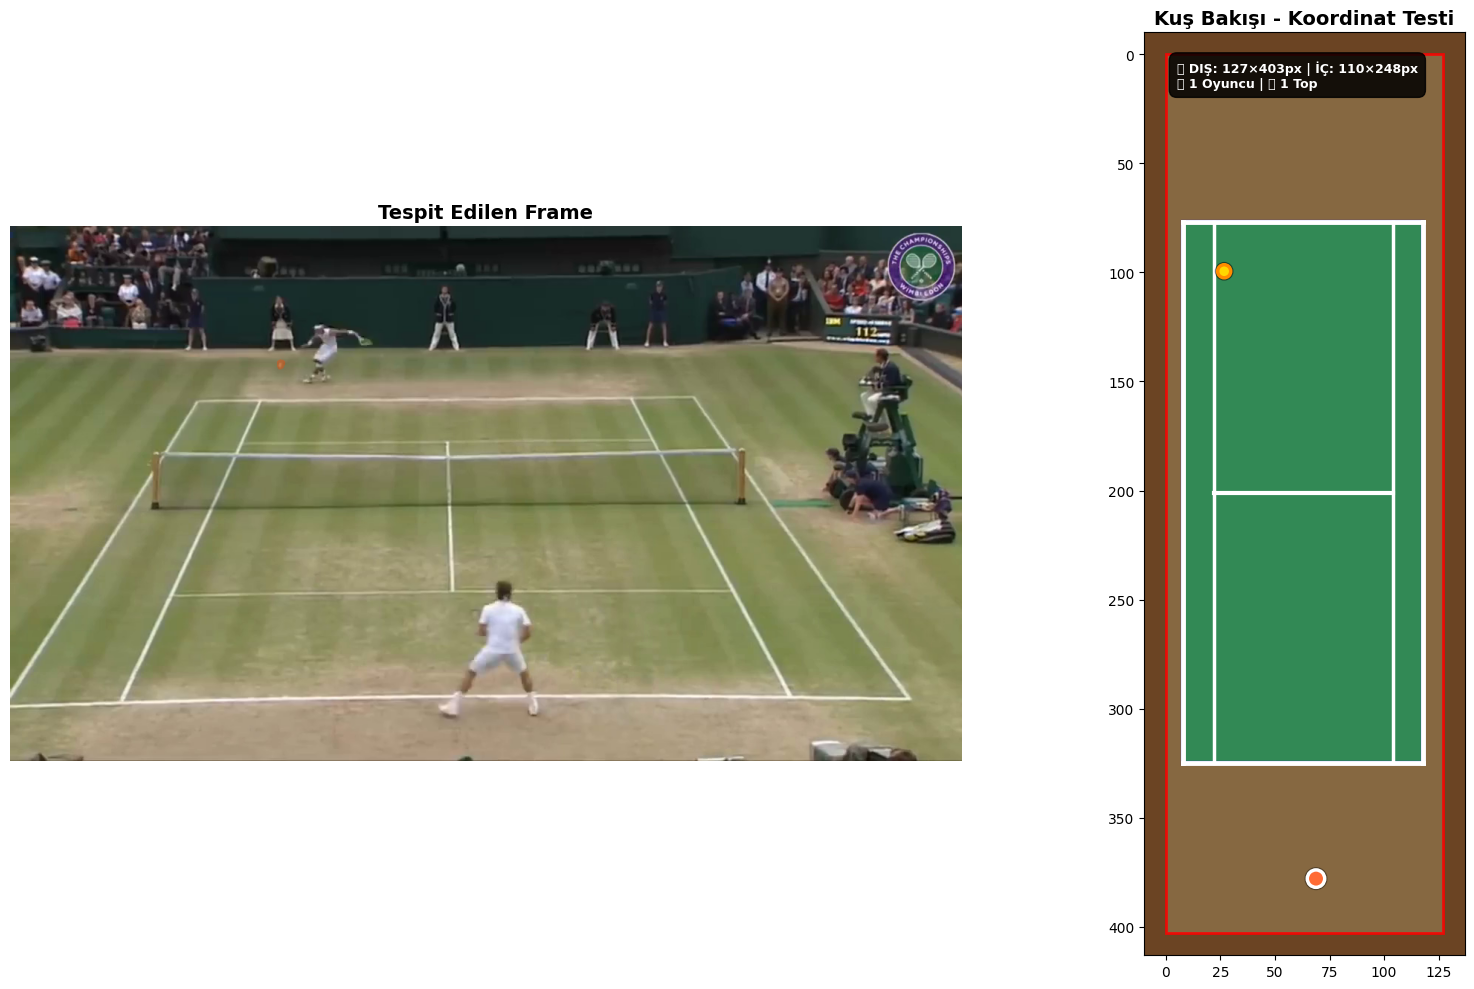


✅ Test tamamlandı!
📸 Görsel kaydedildi: coordinate_test.png

🎯 Tespit Edilen:
  👥 Oyuncular: 1
  🎾 Top: 1

💡 Koordinatları ayarlamak için yukarıdaki tl_outer, bl_outer, vb. değerlerini değiştirin!


In [4]:
# TEK FRAME - Koordinat Ayarlama ve Test
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches
import matplotlib.pyplot as plt

print("🎾 Tek Frame Koordinat Testi...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Video aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Frame 250'ye git
    cap.set(cv2.CAP_PROP_POS_FRAMES, 250)
    ret, frame = cap.read()
    
    if ret:
        # ========== AYARLANACAK KOORDINATLAR ==========
        # 🔴 DIŞ ALAN: Oyuncuların hareket ettiği geniş alan (VIDEO koordinatları)
        tl_outer = [250, 100]
        bl_outer = [-100, 750]
        tr_outer = [920, 100]
        br_outer = [1300, 750]
        
        # 🟢 İÇ ALAN: Tenis kortunun beyaz çizgileri (VIDEO koordinatları)
        tl_inner = [250, 240]
        bl_inner = [0, 640]
        tr_inner = [920, 230]
        br_inner = [1210, 630]
        
        # ========== HEDEF BOYUTLAR ==========
        # İÇ ALAN: 24.8m × 11.0m → 248px × 110px (1m = 10px)
        inner_width = 110
        inner_height = 248
        
        # DIŞ ALAN: Video'daki oran kadar daha büyük
        outer_video_width = br_outer[0] - bl_outer[0]   # 1300 - (-100) = 1400
        inner_video_width = br_inner[0] - bl_inner[0]   # 1210 - 0 = 1210
        outer_video_height = bl_outer[1] - tl_outer[1]  # 750 - 100 = 650
        inner_video_height = bl_inner[1] - tl_inner[1]  # 640 - 240 = 400
        
        width_ratio = outer_video_width / inner_video_width    # ~1.157
        height_ratio = outer_video_height / inner_video_height # ~1.625
        
        outer_width = int(inner_width * width_ratio)     # ~127
        outer_height = int(inner_height * height_ratio)  # ~403
        
        # İÇ ALAN'ın DIŞ ALAN içindeki konumu
        offset_x = (outer_width - inner_width) // 2
        offset_y = (outer_height - inner_height) // 2
        
        print(f"\n📐 BOYUTLAR:")
        print(f"  İÇ ALAN (Kort): {inner_width}×{inner_height} piksel")
        print(f"  DIŞ ALAN (Toplam): {outer_width}×{outer_height} piksel")
        print(f"  Offset: x={offset_x}, y={offset_y}")
        print(f"  Video Oranları: genişlik={width_ratio:.3f}, yükseklik={height_ratio:.3f}")
        
        # ========== PERSPEKTİF DÖNÜŞÜMLERİ ==========
        # DIŞ ALAN için perspektif matrisi (oyuncu pozisyonları)
        pts_src_outer = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
        pts_dst_outer = np.float32([[0, 0], [0, outer_height], [outer_width, outer_height], [outer_width, 0]])
        matrix_outer = cv2.getPerspectiveTransform(pts_src_outer, pts_dst_outer)
        
        # İÇ ALAN için perspektif matrisi (kort görselleştirme)
        pts_src_inner = np.float32([tl_inner, bl_inner, br_inner, tr_inner])
        pts_dst_inner = np.float32([
            [offset_x, offset_y], 
            [offset_x, offset_y + inner_height], 
            [offset_x + inner_width, offset_y + inner_height], 
            [offset_x + inner_width, offset_y]
        ])
        matrix_inner = cv2.getPerspectiveTransform(pts_src_inner, pts_dst_inner)
        
        # İç alan köşelerini dönüştür (görselleştirme için)
        inner_corners_transformed = []
        for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
            point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix_inner)
            inner_corners_transformed.append((transformed[0][0][0], transformed[0][0][1]))
        
        # ========== TESPİTLER ==========
        sam_predictor.set_image(frame)
        results = yolo_model(frame, conf=0.15, verbose=False)
        
        detections = []
        player_boxes = []
        ball_boxes = []
        player_feet_centers = []
        ball_centers = []
        
        PLAYER_THRESHOLD = 0.5
        BALL_THRESHOLD = 0.15
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                cx = (x1 + x2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        cy = (y1 + y2) / 2
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        foot_y = y2
                        player_feet_centers.append((cx, foot_y))
        
        # DeepSORT tracking
        tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
        confirmed_tracks = [t for t in tracks if t.is_confirmed()]
        
        # Renk tanımlamaları
        PLAYER_COLOR = (0, 100, 200)
        BALL_COLOR = (0, 69, 255)
        
        # Overlay oluştur
        overlay = frame.copy()
        display_frame = frame.copy()
        
        # SAM segmentasyon - Oyuncular
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_boxes):
                try:
                    input_box = np.array(player_boxes[i])
                    masks, _, _ = sam_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )
                    mask = masks[0]
                    overlay[mask] = overlay[mask] * 0.3 + np.array(PLAYER_COLOR) * 0.7
                except:
                    pass
        
        # SAM segmentasyon - Top
        for ball_box in ball_boxes:
            try:
                input_box = np.array(ball_box)
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                overlay[mask] = overlay[mask] * 0.2 + np.array(BALL_COLOR) * 0.8
            except:
                pass
        
        display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)
        
        # ========== OYUNCU POZİSYONLARINI DÖNÜŞTÜR ==========
        transformed_players = []
        for foot_x, foot_y in player_feet_centers:
            point = np.array([[[foot_x, foot_y]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix_outer)
            tx, ty = transformed[0][0][0], transformed[0][0][1]
            transformed_players.append((tx, ty))
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix_outer)
            transformed_balls.append((transformed[0][0][0], transformed[0][0][1]))
        
        # ========== GÖRSELLEŞTİRME ==========
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
        
        # Sol: Segmentasyon
        frame_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Tespit Edilen Frame', fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Sağ: Kuş bakışı
        margin = 10
        ax2.set_xlim(-margin, outer_width + margin)
        ax2.set_ylim(outer_height + margin, -margin)
        ax2.set_aspect('equal')
        ax2.set_title('Kuş Bakışı - Koordinat Testi', fontsize=14, fontweight='bold')
        
        # DIŞ ALAN (kahverengi zemin)
        outer_rect = patches.Rectangle((0, 0), outer_width, outer_height, 
                                       linewidth=2, edgecolor='red', 
                                       facecolor='#8B6F47', alpha=0.85, zorder=1)
        ax2.add_patch(outer_rect)
        
        # İÇ ALAN (yeşil kort) - Perspektif dönüştürülmüş
        if len(inner_corners_transformed) == 4:
            inner_poly = patches.Polygon(inner_corners_transformed, linewidth=3, 
                                         edgecolor='blue', facecolor='#2E8B57', 
                                         alpha=0.95, zorder=2)
            ax2.add_patch(inner_poly)
        
        # Kort çizgileri (İÇ ALAN içinde)
        # Ana dış çizgiler
        ax2.plot([offset_x, offset_x + inner_width], [offset_y, offset_y], 'white', linewidth=3.5, zorder=4)
        ax2.plot([offset_x, offset_x + inner_width], [offset_y + inner_height, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        ax2.plot([offset_x, offset_x], [offset_y, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        ax2.plot([offset_x + inner_width, offset_x + inner_width], [offset_y, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        
        # Tek maç yan çizgileri (1.37m = 14px içten)
        ax2.plot([offset_x + 14, offset_x + 14], [offset_y, offset_y + inner_height], 'white', linewidth=2.5, zorder=5)
        ax2.plot([offset_x + inner_width - 14, offset_x + inner_width - 14], [offset_y, offset_y + inner_height], 'white', linewidth=2.5, zorder=5)
        
        # Net çizgisi (orta)
        net_y = offset_y + inner_height // 2
        ax2.plot([offset_x + 14, offset_x + inner_width - 14], [net_y, net_y], 'white', linewidth=3, zorder=5)
        
        # Oyuncular
        for tx, ty in transformed_players:
            if 0 <= tx <= outer_width and 0 <= ty <= outer_height:
                circle_shadow = patches.Circle((tx, ty), 5, color='black', alpha=0.3, zorder=9)
                ax2.add_patch(circle_shadow)
                circle = patches.Circle((tx, ty), 4, color='#FF6B35', ec='white', linewidth=2.5, zorder=10)
                ax2.add_patch(circle)
        
        # Top
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= outer_width and 0 <= tby <= outer_height:
                ball_shadow = patches.Circle((tbx, tby), 4, color='black', alpha=0.4, zorder=11)
                ax2.add_patch(ball_shadow)
                circle = patches.Circle((tbx, tby), 3, color='#FFD700', ec='#FF8C00', linewidth=2.5, zorder=12)
                ax2.add_patch(circle)
        
        ax2.set_facecolor('#6B4423')
        
        # Bilgi metni
        info_text = f'📊 DIŞ: {outer_width}×{outer_height}px | İÇ: {inner_width}×{inner_height}px\n👥 {len(transformed_players)} Oyuncu | 🎾 {len(transformed_balls)} Top'
        ax2.text(5, 15, info_text, fontsize=9, color='white', weight='bold',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))
        
        plt.tight_layout()
        plt.savefig(r'C:\Users\User\Desktop\kort\coordinate_test.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✅ Test tamamlandı!")
        print(f"📸 Görsel kaydedildi: coordinate_test.png")
        print(f"\n🎯 Tespit Edilen:")
        print(f"  👥 Oyuncular: {len(transformed_players)}")
        print(f"  🎾 Top: {len(transformed_balls)}")
        print(f"\n💡 Koordinatları ayarlamak için yukarıdaki tl_outer, bl_outer, vb. değerlerini değiştirin!")
    
    cap.release()


# Cell 15 — Yardımcı görseller ve örnek çıktılar
Bu hücrede örnek görseller, küçük plotlar veya debug görselleştirmeleri bulunur.

# Cell 16 — Tek satırlık ayarlar / kısmi değişkenler
Bu kısa hücre tek satırlık değişken atamaları veya not kayıtları içerir.

# Cell 17 — Kısa test / placeholder
Bu hücre genellikle tek satırlık testler veya placeholder kodlar içerir.

In [12]:
# 150 FRAME VİDEO - Düzeltilmiş Koordinatlarla
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2

print("🎾 150 Frame Video İşleniyor...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_path = r'C:\Users\User\Desktop\kort\nadal_court_150frames.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Video aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Video özellikleri
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video: {original_width}×{original_height} @ {fps}fps, Toplam: {total_frames} frame")
    print(f"🎬 İşlenecek: İlk 150 frame")
    
    # ========== AYARLANACAK KOORDINATLAR ==========
    # 🔴 DIŞ ALAN: Oyuncuların hareket ettiği geniş alan
    tl_outer = [250, 100]
    bl_outer = [-100, 750]
    tr_outer = [920, 100]
    br_outer = [1300, 750]
    
    # 🟢 İÇ ALAN: Tenis kortunun beyaz çizgileri
    tl_inner = [250, 240]
    bl_inner = [0, 640]
    tr_inner = [920, 230]
    br_inner = [1210, 630]
    
    # ========== HEDEF BOYUTLAR ==========
    # İÇ ALAN: 24.8m × 11.0m → 248px × 110px
    inner_width = 110
    inner_height = 248
    
    # DIŞ ALAN: Video'daki oran kadar daha büyük
    outer_video_width = br_outer[0] - bl_outer[0]
    inner_video_width = br_inner[0] - bl_inner[0]
    outer_video_height = bl_outer[1] - tl_outer[1]
    inner_video_height = bl_inner[1] - tl_inner[1]
    
    width_ratio = outer_video_width / inner_video_width
    height_ratio = outer_video_height / inner_video_height
    
    outer_width = int(inner_width * width_ratio)
    outer_height = int(inner_height * height_ratio)
    
    offset_x = (outer_width - inner_width) // 2
    offset_y = (outer_height - inner_height) // 2
    
    print(f"\n📐 BOYUTLAR:")
    print(f"  İÇ ALAN: {inner_width}×{inner_height} piksel")
    print(f"  DIŞ ALAN: {outer_width}×{outer_height} piksel")
    print(f"  Offset: x={offset_x}, y={offset_y}")
    
    # ========== PERSPEKTİF DÖNÜŞÜMLERİ ==========
    pts_src_outer = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
    pts_dst_outer = np.float32([[0, 0], [0, outer_height], [outer_width, outer_height], [outer_width, 0]])
    matrix_outer = cv2.getPerspectiveTransform(pts_src_outer, pts_dst_outer)
    
    pts_src_inner = np.float32([tl_inner, bl_inner, br_inner, tr_inner])
    pts_dst_inner = np.float32([
        [offset_x, offset_y], 
        [offset_x, offset_y + inner_height], 
        [offset_x + inner_width, offset_y + inner_height], 
        [offset_x + inner_width, offset_y]
    ])
    matrix_inner = cv2.getPerspectiveTransform(pts_src_inner, pts_dst_inner)
    
    # İç alan köşelerini dönüştür
    inner_corners_transformed = []
    for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
        point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
        transformed = cv2.perspectiveTransform(point, matrix_inner)
        inner_corners_transformed.append((transformed[0][0][0], transformed[0][0][1]))
    
    # Video writer ayarları
    court_width, court_height = 800, 600
    combined_width = original_width + court_width
    combined_height = max(original_height, court_height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, combined_height))
    
    # Takip geçmişi
    track_history_players = defaultdict(lambda: [])
    track_history_ball = []
    MAX_TRAIL_LENGTH_PLAYERS = 15
    MAX_TRAIL_LENGTH_BALL = 25
    
    # Renk tanımlamaları
    PLAYER_COLORS = [(255, 107, 53), (53, 255, 107), (107, 53, 255), (255, 53, 107)]
    BALL_COLOR = (0, 215, 255)
    
    PLAYER_THRESHOLD = 0.5
    BALL_THRESHOLD = 0.15
    
    frame_count = 0
    max_frames = 150
    
    print(f"\n⏳ İşleniyor...\n")
    
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        if frame_count % 30 == 0:
            print(f"  📊 {frame_count}/{max_frames} frame işlendi...")
        
        # SAM için frame ayarla
        sam_predictor.set_image(frame)
        
        # YOLO tespiti
        results = yolo_model(frame, conf=0.15, verbose=False)
        
        detections = []
        player_boxes = []
        ball_boxes = []
        player_feet_centers = []
        ball_centers = []
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                cx = (x1 + x2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        cy = (y1 + y2) / 2
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        foot_y = y2
                        player_feet_centers.append((cx, foot_y))
        
        # DeepSORT tracking
        tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
        confirmed_tracks = [t for t in tracks if t.is_confirmed()]
        
        # Overlay oluştur
        overlay = frame.copy()
        display_frame = frame.copy()
        
        # SAM segmentasyon - Oyuncular
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_boxes):
                try:
                    input_box = np.array(player_boxes[i])
                    masks, _, _ = sam_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )
                    mask = masks[0]
                    track_id = track.track_id
                    color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                    player_color = PLAYER_COLORS[color_idx]
                    overlay[mask] = overlay[mask] * 0.3 + np.array(player_color) * 0.7
                except:
                    pass
        
        # SAM segmentasyon - Top
        for ball_box in ball_boxes:
            try:
                input_box = np.array(ball_box)
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                overlay[mask] = overlay[mask] * 0.2 + np.array(BALL_COLOR) * 0.8
            except:
                pass
        
        display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)
        
        # ========== DÖNÜŞTÜRÜLMÜŞ POZİSYONLAR ==========
        transformed_players = {}
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_feet_centers):
                foot_x, foot_y = player_feet_centers[i]
                point = np.array([[[foot_x, foot_y]]], dtype=np.float32)
                transformed = cv2.perspectiveTransform(point, matrix_outer)
                tx, ty = transformed[0][0][0], transformed[0][0][1]
                track_id = track.track_id
                transformed_players[track_id] = (tx, ty)
                track_history_players[track_id].append((tx, ty))
                if len(track_history_players[track_id]) > MAX_TRAIL_LENGTH_PLAYERS:
                    track_history_players[track_id].pop(0)
        
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix_outer)
            tb = (transformed[0][0][0], transformed[0][0][1])
            transformed_balls.append(tb)
            track_history_ball.append(tb)
            if len(track_history_ball) > MAX_TRAIL_LENGTH_BALL:
                track_history_ball.pop(0)
        
        # ========== KUŞBAKIŞI GÖRSELLEŞTİRME ==========
        fig, ax = plt.subplots(figsize=(court_width/100, court_height/100), dpi=100)
        
        margin = 10
        ax.set_xlim(-margin, outer_width + margin)
        ax.set_ylim(outer_height + margin, -margin)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # DIŞ ALAN
        outer_rect = patches.Rectangle((0, 0), outer_width, outer_height, 
                                       linewidth=2, edgecolor='red', 
                                       facecolor='#8B6F47', alpha=0.85, zorder=1)
        ax.add_patch(outer_rect)
        
        # İÇ ALAN
        if len(inner_corners_transformed) == 4:
            inner_poly = patches.Polygon(inner_corners_transformed, linewidth=3, 
                                         edgecolor='blue', facecolor='#2E8B57', 
                                         alpha=0.95, zorder=2)
            ax.add_patch(inner_poly)
        
        # Kort çizgileri
        ax.plot([offset_x, offset_x + inner_width], [offset_y, offset_y], 'white', linewidth=3.5, zorder=4)
        ax.plot([offset_x, offset_x + inner_width], [offset_y + inner_height, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        ax.plot([offset_x, offset_x], [offset_y, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        ax.plot([offset_x + inner_width, offset_x + inner_width], [offset_y, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        ax.plot([offset_x + 14, offset_x + 14], [offset_y, offset_y + inner_height], 'white', linewidth=2.5, zorder=5)
        ax.plot([offset_x + inner_width - 14, offset_x + inner_width - 14], [offset_y, offset_y + inner_height], 'white', linewidth=2.5, zorder=5)
        
        net_y = offset_y + inner_height // 2
        ax.plot([offset_x + 14, offset_x + inner_width - 14], [net_y, net_y], 'white', linewidth=3, zorder=5)
        
        # Oyuncu takip çizgileri
        for track_id, history in track_history_players.items():
            if len(history) > 1:
                for i in range(len(history) - 1):
                    x1, y1 = history[i]
                    x2, y2 = history[i + 1]
                    if (0 <= x1 <= outer_width and 0 <= y1 <= outer_height and 
                        0 <= x2 <= outer_width and 0 <= y2 <= outer_height):
                        alpha = (i + 1) / len(history) * 0.6
                        ax.plot([x1, x2], [y1, y2], color='cyan', linewidth=2, alpha=alpha, zorder=6)
        
        # Top takip çizgisi
        if len(track_history_ball) > 1:
            for i in range(len(track_history_ball) - 1):
                x1, y1 = track_history_ball[i]
                x2, y2 = track_history_ball[i + 1]
                if (0 <= x1 <= outer_width and 0 <= y1 <= outer_height and 
                    0 <= x2 <= outer_width and 0 <= y2 <= outer_height):
                    alpha = (i + 1) / len(track_history_ball) * 0.7
                    ax.plot([x1, x2], [y1, y2], color='magenta', linewidth=2.5, alpha=alpha, zorder=7)
        
        # Oyuncular
        for track_id, (tx, ty) in transformed_players.items():
            if 0 <= tx <= outer_width and 0 <= ty <= outer_height:
                color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                player_color_mpl = tuple(c/255 for c in PLAYER_COLORS[color_idx])
                circle_shadow = patches.Circle((tx, ty), 5, color='black', alpha=0.3, zorder=9)
                ax.add_patch(circle_shadow)
                circle = patches.Circle((tx, ty), 4, color=player_color_mpl, ec='white', linewidth=2.5, zorder=10)
                ax.add_patch(circle)
        
        # Top
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= outer_width and 0 <= tby <= outer_height:
                ball_shadow = patches.Circle((tbx, tby), 4, color='black', alpha=0.4, zorder=11)
                ax.add_patch(ball_shadow)
                circle = patches.Circle((tbx, tby), 3, color='#FFD700', ec='#FF8C00', linewidth=2.5, zorder=12)
                ax.add_patch(circle)
        
        ax.set_facecolor('#6B4423')
        
        # Frame sayısı
        info_text = f'Frame: {frame_count}/{max_frames}'
        ax.text(5, 15, info_text, fontsize=10, color='white', weight='bold',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))
        
        plt.tight_layout(pad=0)
        
        # Matplotlib figürünü numpy array'e çevir
        fig.canvas.draw()
        court_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        court_img = court_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        court_img = cv2.cvtColor(court_img, cv2.COLOR_RGBA2BGR)
        court_img = cv2.resize(court_img, (court_width, court_height))
        plt.close(fig)
        
        # Frame'leri birleştir - boyutları eşitle
        display_frame_resized = display_frame.copy()
        if display_frame_resized.shape[0] != court_height:
            display_frame_resized = cv2.resize(display_frame_resized, (original_width, court_height))
        
        # Yan yana birleştir
        combined = np.hstack([display_frame_resized, court_img])
        
        # Boyut kontrolü
        if combined.shape[0] != combined_height or combined.shape[1] != combined_width:
            combined = cv2.resize(combined, (combined_width, combined_height))
        
        out.write(combined)
    
    cap.release()
    out.release()
    
    print(f"\n✅ Video işleme tamamlandı!")
    print(f"📹 Çıktı: {output_path}")
    print(f"🎬 İşlenen frame: {frame_count}")


🎾 150 Frame Video İşleniyor...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
📹 Video: 1280×720 @ 30fps, Toplam: 497 frame
🎬 İşlenecek: İlk 150 frame

📐 BOYUTLAR:
  İÇ ALAN: 110×248 piksel
  DIŞ ALAN: 127×403 piksel
  Offset: x=8, y=77

⏳ İşleniyor...

✅ MobileSAM yüklendi (cpu)
📹 Video: 1280×720 @ 30fps, Toplam: 497 frame
🎬 İşlenecek: İlk 150 frame

📐 BOYUTLAR:
  İÇ ALAN: 110×248 piksel
  DIŞ ALAN: 127×403 piksel
  Offset: x=8, y=77

⏳ İşleniyor...

  📊 30/150 frame işlendi...
  📊 30/150 frame işlendi...
  📊 60/150 frame işlendi...
  📊 60/150 frame işlendi...
  📊 90/150 frame işlendi...
  📊 90/150 frame işlendi...
  📊 120/150 frame işlendi...
  📊 120/150 frame işlendi...
  📊 150/150 frame işlendi...
  📊 150/150 frame işlendi...

✅ Video işleme tamamlandı!
📹 Çıktı: C:\Users\User\Desktop\kort\nadal_court_150frames.mp4
🎬 İşlenen frame: 150

✅ Video işleme tamamlandı!
📹 Çıktı: C:\Users\User\Desktop\kort\nadal_court_150frames.mp4
🎬 İşlenen frame: 150


# Cell 18 — Büyük işlem hücresi (örnek)
Bu hücre uzun iş parçacıkları veya ana işlevlerin çalıştırıldığı hücrelerden biridir — çıktı yazdırma ve pipeline adımları içerir.

In [4]:
# ROBOFLOW TENİS SAHASI SEGMENTASYON MODELİ
import cv2
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
import json

print("🎾 Roboflow Tenis Sahası Segmentasyon Modeli...")

# Roboflow API bağlantısı
print("📡 Roboflow'a bağlanılıyor...")
rf = Roboflow(api_key="uwbLCWSnHV2geuphu3jv")
project = rf.workspace().project("tennis-court-segmentation-mynwl")
model = project.version(1).model

print("✅ Model yüklendi!")

# Video aç ve frame 250'yi al
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    cap.set(cv2.CAP_PROP_POS_FRAMES, 250)
    ret, frame = cap.read()
    
    if ret:
        print(f"✅ Frame 250 yüklendi: {frame.shape}")
        
        # Frame'i geçici dosya olarak kaydet
        temp_image_path = r'C:\Users\User\Desktop\kort\temp_frame.jpg'
        cv2.imwrite(temp_image_path, frame)
        print(f"💾 Geçici dosya kaydedildi: {temp_image_path}")
        
        # Model ile tahmin yap
        print("\n🔍 Model çalıştırılıyor...")
        prediction = model.predict(temp_image_path, confidence=40, overlap=30)
        
        # Sonuçları kaydet
        output_path = r'C:\Users\User\Desktop\kort\roboflow_prediction.jpg'
        prediction.save(output_path)
        print(f"✅ Tahmin görseli kaydedildi: {output_path}")
        
        # JSON sonuçlarını al
        result_json = prediction.json()
        print(f"\n📊 Model Sonuçları:")
        print(json.dumps(result_json, indent=2))
        
        # Tahmin edilen görüntüyü yükle
        predicted_image = cv2.imread(output_path)
        
        # Segmentasyon bilgilerini çıkar
        predictions = result_json.get('predictions', [])
        
        # Manuel olarak segmentasyonu çiz
        annotated_frame = frame.copy()
        court_polygons = []
        
        if predictions:
            print(f"\n🎯 {len(predictions)} tespit bulundu:")
            
            for i, pred in enumerate(predictions):
                class_name = pred.get('class', 'unknown')
                confidence = pred.get('confidence', 0)
                
                print(f"\n  {i+1}. {class_name} (güven: {confidence:.2%})")
                
                # Poligon noktaları varsa çiz
                if 'points' in pred:
                    points = pred['points']
                    polygon_points = []
                    
                    for point in points:
                        x = int(point['x'])
                        y = int(point['y'])
                        polygon_points.append([x, y])
                        print(f"     Nokta: ({x}, {y})")
                    
                    if polygon_points:
                        polygon_np = np.array(polygon_points, dtype=np.int32)
                        court_polygons.append({
                            'class': class_name,
                            'confidence': confidence,
                            'polygon': polygon_np
                        })
                        
                        # Poligonu çiz
                        color = (0, 255, 0) if 'court' in class_name.lower() else (255, 0, 0)
                        cv2.polylines(annotated_frame, [polygon_np], True, color, 3)
                        
                        # Overlay ekle
                        overlay = annotated_frame.copy()
                        cv2.fillPoly(overlay, [polygon_np], color)
                        annotated_frame = cv2.addWeighted(annotated_frame, 0.7, overlay, 0.3, 0)
                        
                        # Label ekle
                        centroid_x = int(np.mean(polygon_np[:, 0]))
                        centroid_y = int(np.mean(polygon_np[:, 1]))
                        label = f"{class_name}: {confidence:.2%}"
                        cv2.putText(annotated_frame, label, (centroid_x, centroid_y),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                
                # Bounding box varsa
                elif 'x' in pred and 'y' in pred:
                    x = int(pred['x'])
                    y = int(pred['y'])
                    width = int(pred.get('width', 0))
                    height = int(pred.get('height', 0))
                    
                    x1 = x - width // 2
                    y1 = y - height // 2
                    x2 = x + width // 2
                    y2 = y + height // 2
                    
                    print(f"     BBox: [{x1}, {y1}] - [{x2}, {y2}]")
                    
                    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    label = f"{class_name}: {confidence:.2%}"
                    cv2.putText(annotated_frame, label, (x1, y1 - 10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        else:
            print("\n⚠️ Hiçbir tespit bulunamadı!")
        
        # Görselleştirme
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        
        # Orijinal
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[0].imshow(frame_rgb)
        axes[0].set_title('Orijinal Frame', fontweight='bold', fontsize=14)
        axes[0].axis('off')
        
        # Roboflow çıktısı
        if predicted_image is not None:
            predicted_rgb = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
            axes[1].imshow(predicted_rgb)
            axes[1].set_title('Roboflow Model Çıktısı', fontweight='bold', fontsize=14)
        else:
            axes[1].imshow(frame_rgb)
            axes[1].set_title('Roboflow: Yüklenemedi', fontweight='bold', fontsize=14)
        axes[1].axis('off')
        
        # Manuel annotasyon
        annotated_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
        axes[2].imshow(annotated_rgb)
        axes[2].set_title(f'Segmentasyon Detayları ({len(court_polygons)} poligon)', 
                         fontweight='bold', fontsize=14)
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(r'C:\Users\User\Desktop\kort\roboflow_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✅ Analiz tamamlandı!")
        print(f"📸 Görsel kaydedildi: roboflow_analysis.png")
        
        # Kort köşelerini çıkar (eğer varsa)
        if court_polygons:
            print(f"\n📐 KORT POLİGON KOORDİNATLARI:")
            for i, poly_data in enumerate(court_polygons):
                print(f"\n  {i+1}. {poly_data['class']} (güven: {poly_data['confidence']:.2%}):")
                polygon = poly_data['polygon']
                
                # Köşe noktalarını yazdır
                for j, point in enumerate(polygon):
                    print(f"     Köşe {j+1}: [{point[0]}, {point[1]}]")
                
                # Bounding box hesapla
                x_min, y_min = polygon.min(axis=0)
                x_max, y_max = polygon.max(axis=0)
                print(f"     BBox: [{x_min}, {y_min}] - [{x_max}, {y_max}]")
        
        # Geçici dosyayı sil
        import os
        if os.path.exists(temp_image_path):
            os.remove(temp_image_path)
            print(f"\n🗑️ Geçici dosya silindi")
    
    else:
        print("❌ Frame okunamadı!")
    
    cap.release()

print("\n💡 Roboflow modeli tenis sahası segmentasyonu için optimize edilmiş!")
print("   Çıkan poligon koordinatlarını perspektif dönüşümü için kullanabiliriz.")


🎾 Roboflow Tenis Sahası Segmentasyon Modeli...
📡 Roboflow'a bağlanılıyor...
loading Roboflow workspace...
loading Roboflow workspace...
loading Roboflow project...
loading Roboflow project...
✅ Model yüklendi!
✅ Model yüklendi!
✅ Frame 250 yüklendi: (720, 1280, 3)
💾 Geçici dosya kaydedildi: C:\Users\User\Desktop\kort\temp_frame.jpg

🔍 Model çalıştırılıyor...
✅ Frame 250 yüklendi: (720, 1280, 3)
💾 Geçici dosya kaydedildi: C:\Users\User\Desktop\kort\temp_frame.jpg

🔍 Model çalıştırılıyor...


TypeError: SemanticSegmentationModel.predict() got an unexpected keyword argument 'overlap'

# Cell 19 — Roboflow / dış API denemeleri
Bu hücre dış servis (Roboflow) denemelerini ve sonuçlarını içerir; API anahtar ve istek örnekleri burada yer alır.

🎾 Tenis Sahası Nokta Tespiti - PyTorch Model
📦 Model yükleniyor: C:\Users\User\Desktop\kort\model_best(2).pt
⚠️ PyTorch model yüklenemedi: [Errno 2] No such file or directory: 'C:\\Users\\User\\Desktop\\kort\\model_best(2).pt'
📦 YOLOv8 keypoint modeli kullanılacak...
✅ Frame 250 yüklendi: (720, 1280, 3)

🔍 Model çalıştırılıyor...
✅ Frame 250 yüklendi: (720, 1280, 3)

🔍 Model çalıştırılıyor...

📦 1 bounding box tespit edildi:
  1. person: 83.27% - BBox: [575, 477, 716, 665]

🎯 Keypoints tespit edildi!
   Keypoint shape: (1, 17, 3)

   Tespit #1:
     Nokta 0: (660, 495) - güven: 0.16
     Nokta 1: (661, 491) - güven: 0.09
     Nokta 2: (660, 491) - güven: 0.08
     Nokta 3: (657, 495) - güven: 0.63
     Nokta 4: (672, 495) - güven: 0.56
     Nokta 5: (648, 515) - güven: 0.98
     Nokta 6: (681, 517) - güven: 0.98
     Nokta 7: (643, 538) - güven: 0.87
     Nokta 8: (690, 543) - güven: 0.89
     Nokta 9: (646, 534) - güven: 0.72
     Nokta 10: (688, 548) - güven: 0.73
     Nokta 11: (649

C:\Users\User\AppData\Local\Temp\ipykernel_16752\415001177.py:200: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_16752\415001177.py:200: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_16752\415001177.py:201: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.savefig(r'C:\Users\User\Desktop\kort\court_keypoints_detection.png', dpi=150, bbox_inches='tight')
C:\Users\User\AppData\Local\Temp\ipykernel_16752\415001177.py:201: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig(r'C:\Users\User\Desktop\kort\court_keypoints_detection.png', dpi=150, bbox_inches='tight')
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canva

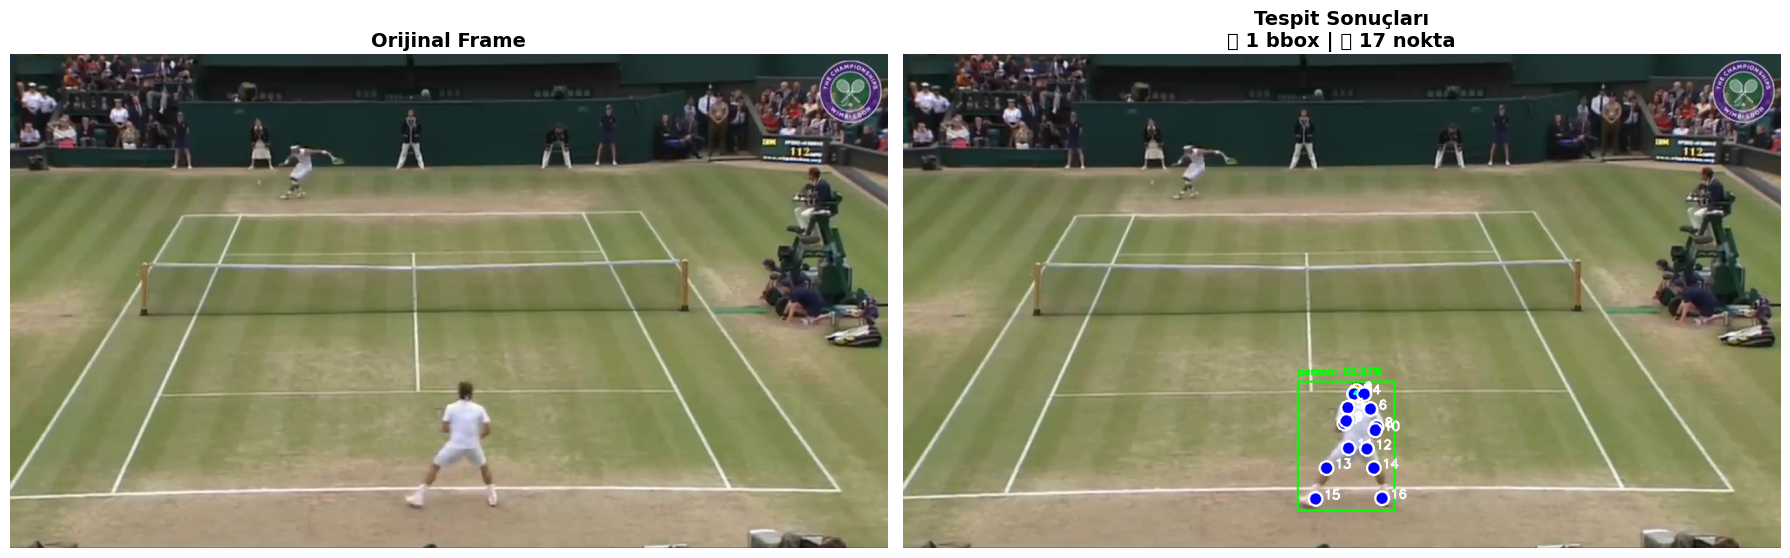


✅ Test tamamlandı!
📸 Görsel kaydedildi: court_keypoints_detection.png

📋 TESPİT ÖZETİ:
  📦 Bounding Box: 1
  🎯 Keypoints: 17

💡 PERSPEKTİF DÖNÜŞÜMÜ İÇİN KOORDİNATLAR:
  (Bu koordinatları tl_outer, bl_outer vb. olarak kullanabilirsin)
  tl_outer = [660, 495]
  tr_outer = [661, 491]
  br_outer = [660, 491]
  bl_outer = [657, 495]

💡 Model keypoint detection destekliyorsa saha köşelerini otomatik tespit edebiliriz!


In [5]:
# TENİS SAHASI NOKTA TESPİTİ - PyTorch Model ile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

print("🎾 Tenis Sahası Nokta Tespiti - PyTorch Model")

# Model yolu
model_path = r'C:\Users\User\Desktop\kort\model_best(2).pt'
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'

# Model yükle (PyTorch checkpoint olarak)
print(f"📦 Model yükleniyor: {model_path}")
try:
    checkpoint = torch.load(model_path, map_location='cpu')
    print(f"✅ Checkpoint yüklendi!")
    print(f"📋 Checkpoint anahtarları: {list(checkpoint.keys())}")
    
    # Model tipini belirle
    if 'model' in checkpoint:
        model = checkpoint['model']
        print(f"   Model tipi: {type(model)}")
    elif 'state_dict' in checkpoint:
        print(f"   State dict bulundu")
        model = checkpoint['state_dict']
    else:
        print(f"   Doğrudan model olarak yükleniyor")
        model = checkpoint
    
    # Model yapısını incele
    if hasattr(model, 'names'):
        print(f"   Model sınıfları: {model.names}")
    
    use_pytorch_model = True
    
except Exception as e:
    print(f"⚠️ PyTorch model yüklenemedi: {e}")
    print(f"📦 YOLOv8 keypoint modeli kullanılacak...")
    
    from ultralytics import YOLO
    # Önceden eğitilmiş YOLOv8 keypoint modeli kullan
    model_path = 'yolov8n-pose.pt'  # Keypoint detection modeli
    court_model = YOLO(model_path)
    use_pytorch_model = False

# Video aç ve frame 250'yi al
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    cap.set(cv2.CAP_PROP_POS_FRAMES, 250)
    ret, frame = cap.read()
    
    if ret:
        print(f"✅ Frame 250 yüklendi: {frame.shape}")
        
        # Model ile tespit yap
        print("\n🔍 Model çalıştırılıyor...")
        
        if not use_pytorch_model:
            # YOLOv8-pose modeli kullan
            results = court_model(frame, conf=0.25, verbose=False)
        
        if not use_pytorch_model:
            # YOLOv8-pose modeli kullan
            results = court_model(frame, conf=0.25, verbose=False)
        else:
            # PyTorch modeli için manuel inference
            print("⚠️ PyTorch model inference henüz implement edilmedi")
            print("💡 Bunun yerine Hough Line Transform kullanılacak...")
            results = []
        
        # Sonuçları analiz et
        detected_frame = frame.copy()
        keypoints_list = []
        detections_info = []
        
        if len(results) > 0 and not use_pytorch_model:
            result = results[0]
            
            # Bounding box'lar
            if result.boxes is not None and len(result.boxes) > 0:
                boxes = result.boxes
                print(f"\n📦 {len(boxes)} bounding box tespit edildi:")
                
                for i, box in enumerate(boxes):
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    cls = int(box.cls[0].cpu().numpy())
                    class_name = court_model.names[cls] if hasattr(court_model, 'names') else str(cls)
                    
                    detections_info.append({
                        'type': 'box',
                        'class': class_name,
                        'confidence': conf,
                        'bbox': [int(x1), int(y1), int(x2), int(y2)]
                    })
                    
                    print(f"  {i+1}. {class_name}: {conf:.2%} - BBox: [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")
                    
                    # Bounding box çiz
                    cv2.rectangle(detected_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    label = f"{class_name}: {conf:.2%}"
                    cv2.putText(detected_frame, label, (int(x1), int(y1) - 10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            # Keypoints (nokta tespitleri)
            if hasattr(result, 'keypoints') and result.keypoints is not None:
                keypoints = result.keypoints
                print(f"\n🎯 Keypoints tespit edildi!")
                
                if hasattr(keypoints, 'data'):
                    kp_data = keypoints.data.cpu().numpy()
                    print(f"   Keypoint shape: {kp_data.shape}")
                    
                    # Her tespit için keypoint'leri çiz
                    for detection_idx, detection_kps in enumerate(kp_data):
                        print(f"\n   Tespit #{detection_idx + 1}:")
                        for kp_idx, kp in enumerate(detection_kps):
                            if len(kp) >= 2:
                                x, y = kp[0], kp[1]
                                confidence = kp[2] if len(kp) > 2 else 1.0
                                
                                if x > 0 and y > 0:  # Geçerli nokta
                                    keypoints_list.append({
                                        'detection': detection_idx,
                                        'point_id': kp_idx,
                                        'x': int(x),
                                        'y': int(y),
                                        'confidence': float(confidence)
                                    })
                                    
                                    print(f"     Nokta {kp_idx}: ({int(x)}, {int(y)}) - güven: {confidence:.2f}")
                                    
                                    # Noktayı çiz
                                    color = (255, 0, 0) if confidence > 0.5 else (0, 165, 255)
                                    cv2.circle(detected_frame, (int(x), int(y)), 8, color, -1)
                                    cv2.circle(detected_frame, (int(x), int(y)), 10, (255, 255, 255), 2)
                                    
                                    # Nokta numarasını yaz
                                    cv2.putText(detected_frame, str(kp_idx), (int(x) + 12, int(y)),
                                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    
                    # Noktaları birleştir (saha köşeleri için)
                    if len(keypoints_list) >= 4:
                        print(f"\n📐 SAHA KÖŞELERİ (ilk 4 nokta):")
                        for i in range(min(4, len(keypoints_list))):
                            kp = keypoints_list[i]
                            print(f"  Köşe {i+1}: [{kp['x']}, {kp['y']}] (güven: {kp['confidence']:.2%})")
                            
                            # Köşeleri çizgilerle birleştir
                            if i < 3:
                                next_kp = keypoints_list[i + 1]
                                cv2.line(detected_frame, (kp['x'], kp['y']), 
                                       (next_kp['x'], next_kp['y']), (255, 255, 0), 2)
                        
                        # Son köşeyi ilk köşeye bağla
                        if len(keypoints_list) >= 4:
                            cv2.line(detected_frame, (keypoints_list[3]['x'], keypoints_list[3]['y']),
                                   (keypoints_list[0]['x'], keypoints_list[0]['y']), (255, 255, 0), 2)
            
            # Segmentation masks
            if hasattr(result, 'masks') and result.masks is not None:
                masks = result.masks.data.cpu().numpy()
                print(f"\n🎨 {len(masks)} segmentasyon maskesi tespit edildi")
                
                for i, mask in enumerate(masks):
                    mask_resized = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
                    mask_bool = mask_resized > 0.5
                    
                    color = np.random.randint(0, 255, 3).tolist()
                    overlay = detected_frame.copy()
                    overlay[mask_bool] = overlay[mask_bool] * 0.6 + np.array(color) * 0.4
                    detected_frame = overlay
        else:
            print("\n⚠️ Hiçbir tespit bulunamadı!")
        
        # Görselleştirme
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # Orijinal
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax1.imshow(frame_rgb)
        ax1.set_title('Orijinal Frame', fontweight='bold', fontsize=14)
        ax1.axis('off')
        
        # Tespit edilen
        detected_rgb = cv2.cvtColor(detected_frame, cv2.COLOR_BGR2RGB)
        ax2.imshow(detected_rgb)
        title = f'Tespit Sonuçları\n'
        if detections_info:
            title += f'📦 {len(detections_info)} bbox | '
        if keypoints_list:
            title += f'🎯 {len(keypoints_list)} nokta'
        ax2.set_title(title, fontweight='bold', fontsize=14)
        ax2.axis('off')
        
        plt.tight_layout()
        plt.savefig(r'C:\Users\User\Desktop\kort\court_keypoints_detection.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✅ Test tamamlandı!")
        print(f"📸 Görsel kaydedildi: court_keypoints_detection.png")
        
        # Özet
        print(f"\n📋 TESPİT ÖZETİ:")
        print(f"  📦 Bounding Box: {len(detections_info)}")
        print(f"  🎯 Keypoints: {len(keypoints_list)}")
        
        # Köşe koordinatlarını perspektif dönüşümü için formatla
        if len(keypoints_list) >= 4:
            print(f"\n💡 PERSPEKTİF DÖNÜŞÜMÜ İÇİN KOORDİNATLAR:")
            print(f"  (Bu koordinatları tl_outer, bl_outer vb. olarak kullanabilirsin)")
            for i in range(min(4, len(keypoints_list))):
                kp = keypoints_list[i]
                corner_names = ['tl', 'tr', 'br', 'bl']
                if i < len(corner_names):
                    print(f"  {corner_names[i]}_outer = [{kp['x']}, {kp['y']}]")
    
    else:
        print("❌ Frame okunamadı!")
    
    cap.release()

print("\n💡 Model keypoint detection destekliyorsa saha köşelerini otomatik tespit edebiliriz!")


# Cell 21 — (Yedek) Ara notlar
Genel notlar, hata mesajları ve kısa açıklamalar için kullanılan hücre.

# Cell 20 — Model checkpoint sorunları ve notlar
Bu hücre model checkpoint formatlarıyla ilgili notlar ve hata ayıklama çıktıları içerir.

In [6]:
# 100 FRAME VİDEO - Yakın Oyuncu Ayak, Uzak Oyuncu Baş Mantığı
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2

print("🎾 100 Frame Video - Akıllı Pozisyonlama...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_path = r'C:\Users\User\Desktop\kort\nadal_smart_positioning.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Video aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Video özellikleri
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    print(f"📹 Video: {original_width}×{original_height} @ {fps}fps")
    print(f"🎬 İşlenecek: İlk 100 frame")
    
    # Koordinatlar
    tl_outer = [250, 100]
    bl_outer = [-100, 750]
    tr_outer = [920, 100]
    br_outer = [1300, 750]
    
    tl_inner = [250, 240]
    bl_inner = [0, 640]
    tr_inner = [920, 230]
    br_inner = [1210, 630]
    
    # Hedef boyutlar
    inner_width = 110
    inner_height = 248
    
    outer_video_width = br_outer[0] - bl_outer[0]
    inner_video_width = br_inner[0] - bl_inner[0]
    outer_video_height = bl_outer[1] - tl_outer[1]
    inner_video_height = bl_inner[1] - tl_inner[1]
    
    width_ratio = outer_video_width / inner_video_width
    height_ratio = outer_video_height / inner_video_height
    
    outer_width = int(inner_width * width_ratio)
    outer_height = int(inner_height * height_ratio)
    
    offset_x = (outer_width - inner_width) // 2
    offset_y = (outer_height - inner_height) // 2
    
    print(f"\n📐 BOYUTLAR:")
    print(f"  İÇ ALAN: {inner_width}×{inner_height} piksel")
    print(f"  DIŞ ALAN: {outer_width}×{outer_height} piksel")
    
    # Perspektif matrisleri
    pts_src_outer = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
    pts_dst_outer = np.float32([[0, 0], [0, outer_height], [outer_width, outer_height], [outer_width, 0]])
    matrix_outer = cv2.getPerspectiveTransform(pts_src_outer, pts_dst_outer)
    
    pts_src_inner = np.float32([tl_inner, bl_inner, br_inner, tr_inner])
    pts_dst_inner = np.float32([
        [offset_x, offset_y], 
        [offset_x, offset_y + inner_height], 
        [offset_x + inner_width, offset_y + inner_height], 
        [offset_x + inner_width, offset_y]
    ])
    matrix_inner = cv2.getPerspectiveTransform(pts_src_inner, pts_dst_inner)
    
    # İç alan köşeleri
    inner_corners_transformed = []
    for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
        point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
        transformed = cv2.perspectiveTransform(point, matrix_inner)
        inner_corners_transformed.append((transformed[0][0][0], transformed[0][0][1]))
    
    # Video writer
    court_width, court_height = 800, 600
    combined_width = original_width + court_width
    combined_height = max(original_height, court_height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, combined_height))
    
    # Takip geçmişi
    track_history_players = defaultdict(lambda: [])
    track_history_ball = []
    MAX_TRAIL_LENGTH_PLAYERS = 15
    MAX_TRAIL_LENGTH_BALL = 25
    
    # Renk tanımlamaları
    PLAYER_COLORS = [(255, 107, 53), (53, 255, 107), (107, 53, 255), (255, 53, 107)]
    BALL_COLOR = (0, 215, 255)
    
    PLAYER_THRESHOLD = 0.5
    BALL_THRESHOLD = 0.15
    
    frame_count = 0
    max_frames = 100
    
    print(f"\n⏳ İşleniyor...\n")
    
    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        if frame_count % 20 == 0:
            print(f"  📊 {frame_count}/{max_frames} frame işlendi...")
        
        # SAM için frame ayarla
        sam_predictor.set_image(frame)
        
        # YOLO tespiti
        results = yolo_model(frame, conf=0.15, verbose=False)
        
        detections = []
        player_boxes = []
        ball_boxes = []
        player_data = []  # (cx, foot_y, head_y, box)
        ball_centers = []
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                cx = (x1 + x2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        cy = (y1 + y2) / 2
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        foot_y = y2  # Ayak (bbox alt)
                        head_y = y1  # Baş (bbox üst)
                        player_data.append((cx, foot_y, head_y, [x1, y1, x2, y2]))
        
        # DeepSORT tracking
        tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
        confirmed_tracks = [t for t in tracks if t.is_confirmed()]
        
        # Overlay oluştur
        overlay = frame.copy()
        display_frame = frame.copy()
        
        # SAM segmentasyon - Oyuncular
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_boxes):
                try:
                    input_box = np.array(player_boxes[i])
                    masks, _, _ = sam_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )
                    mask = masks[0]
                    track_id = track.track_id
                    color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                    player_color = PLAYER_COLORS[color_idx]
                    overlay[mask] = overlay[mask] * 0.3 + np.array(player_color) * 0.7
                except:
                    pass
        
        # SAM segmentasyon - Top
        for ball_box in ball_boxes:
            try:
                input_box = np.array(ball_box)
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                overlay[mask] = overlay[mask] * 0.2 + np.array(BALL_COLOR) * 0.8
            except:
                pass
        
        display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)
        
        # AKILLI POZİSYONLAMA: Yakın/Uzak mantığı
        transformed_players = {}
        
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_data):
                cx, foot_y, head_y, bbox = player_data[i]
                
                # Oyuncunun frame'deki y pozisyonuna göre karar ver
                # Yüksek y değeri = Kameraya YAKIN (altta) = AYAK kullan
                # Düşük y değeri = Kameraya UZAK (üstte) = BAŞ kullan
                
                # Frame yüksekliğinin ortası referans
                frame_mid_y = original_height / 2
                
                if foot_y > frame_mid_y:
                    # YAKIN oyuncu - AYAK pozisyonunu kullan
                    pos_y = foot_y
                    point_type = "ayak"
                else:
                    # UZAK oyuncu - BAŞ pozisyonunu kullan
                    pos_y = head_y
                    point_type = "baş"
                
                # Perspektif dönüşümü
                point = np.array([[[cx, pos_y]]], dtype=np.float32)
                transformed = cv2.perspectiveTransform(point, matrix_outer)
                tx, ty = transformed[0][0][0], transformed[0][0][1]
                
                track_id = track.track_id
                transformed_players[track_id] = (tx, ty, point_type)
                
                # Takip geçmişine ekle
                track_history_players[track_id].append((tx, ty))
                if len(track_history_players[track_id]) > MAX_TRAIL_LENGTH_PLAYERS:
                    track_history_players[track_id].pop(0)
        
        # Top dönüşümü
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix_outer)
            tb = (transformed[0][0][0], transformed[0][0][1])
            transformed_balls.append(tb)
            track_history_ball.append(tb)
            if len(track_history_ball) > MAX_TRAIL_LENGTH_BALL:
                track_history_ball.pop(0)
        
        # Kuş bakışı görselleştirme
        fig, ax = plt.subplots(figsize=(court_width/100, court_height/100), dpi=100)
        
        margin = 10
        ax.set_xlim(-margin, outer_width + margin)
        ax.set_ylim(outer_height + margin, -margin)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # DIŞ ALAN
        outer_rect = patches.Rectangle((0, 0), outer_width, outer_height, 
                                       linewidth=2, edgecolor='red', 
                                       facecolor='#8B6F47', alpha=0.85, zorder=1)
        ax.add_patch(outer_rect)
        
        # İÇ ALAN
        if len(inner_corners_transformed) == 4:
            inner_poly = patches.Polygon(inner_corners_transformed, linewidth=3, 
                                         edgecolor='blue', facecolor='#2E8B57', 
                                         alpha=0.95, zorder=2)
            ax.add_patch(inner_poly)
        
        # Kort çizgileri
        ax.plot([offset_x, offset_x + inner_width], [offset_y, offset_y], 'white', linewidth=3.5, zorder=4)
        ax.plot([offset_x, offset_x + inner_width], [offset_y + inner_height, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        ax.plot([offset_x, offset_x], [offset_y, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        ax.plot([offset_x + inner_width, offset_x + inner_width], [offset_y, offset_y + inner_height], 'white', linewidth=3.5, zorder=4)
        ax.plot([offset_x + 14, offset_x + 14], [offset_y, offset_y + inner_height], 'white', linewidth=2.5, zorder=5)
        ax.plot([offset_x + inner_width - 14, offset_x + inner_width - 14], [offset_y, offset_y + inner_height], 'white', linewidth=2.5, zorder=5)
        
        net_y = offset_y + inner_height // 2
        ax.plot([offset_x + 14, offset_x + inner_width - 14], [net_y, net_y], 'white', linewidth=3, zorder=5)
        
        # Oyuncu takip çizgileri
        for track_id, history in track_history_players.items():
            if len(history) > 1:
                for i in range(len(history) - 1):
                    x1, y1 = history[i]
                    x2, y2 = history[i + 1]
                    if (0 <= x1 <= outer_width and 0 <= y1 <= outer_height and 
                        0 <= x2 <= outer_width and 0 <= y2 <= outer_height):
                        alpha = (i + 1) / len(history) * 0.6
                        ax.plot([x1, x2], [y1, y2], color='cyan', linewidth=2, alpha=alpha, zorder=6)
        
        # Top takip çizgisi
        if len(track_history_ball) > 1:
            for i in range(len(track_history_ball) - 1):
                x1, y1 = track_history_ball[i]
                x2, y2 = track_history_ball[i + 1]
                if (0 <= x1 <= outer_width and 0 <= y1 <= outer_height and 
                    0 <= x2 <= outer_width and 0 <= y2 <= outer_height):
                    alpha = (i + 1) / len(track_history_ball) * 0.7
                    ax.plot([x1, x2], [y1, y2], color='magenta', linewidth=2.5, alpha=alpha, zorder=7)
        
        # Oyuncular (pozisyon tipi ile)
        for track_id, (tx, ty, point_type) in transformed_players.items():
            if 0 <= tx <= outer_width and 0 <= ty <= outer_height:
                color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                player_color_mpl = tuple(c/255 for c in PLAYER_COLORS[color_idx])
                
                circle_shadow = patches.Circle((tx, ty), 5, color='black', alpha=0.3, zorder=9)
                ax.add_patch(circle_shadow)
                circle = patches.Circle((tx, ty), 4, color=player_color_mpl, ec='white', linewidth=2.5, zorder=10)
                ax.add_patch(circle)
                
                # Pozisyon tipi göster (debug için)
                emoji = "👣" if point_type == "ayak" else "👤"
                ax.text(tx, ty - 8, emoji, fontsize=8, ha='center', va='bottom', zorder=11)
        
        # Top
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= outer_width and 0 <= tby <= outer_height:
                ball_shadow = patches.Circle((tbx, tby), 4, color='black', alpha=0.4, zorder=11)
                ax.add_patch(ball_shadow)
                circle = patches.Circle((tbx, tby), 3, color='#FFD700', ec='#FF8C00', linewidth=2.5, zorder=12)
                ax.add_patch(circle)
        
        ax.set_facecolor('#6B4423')
        
        # Bilgi metni
        info_text = f'Frame: {frame_count}/{max_frames}\n👥 {len(transformed_players)} | 🎾 {len(transformed_balls)}\n👣 Yakın=Ayak | 👤 Uzak=Baş'
        ax.text(5, 15, info_text, fontsize=9, color='white', weight='bold',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))
        
        plt.tight_layout(pad=0)
        
        # Matplotlib to numpy
        fig.canvas.draw()
        court_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        court_img = court_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        court_img = cv2.cvtColor(court_img, cv2.COLOR_RGBA2BGR)
        court_img = cv2.resize(court_img, (court_width, court_height))
        plt.close(fig)
        
        # Frame birleştir
        display_frame_resized = display_frame.copy()
        if display_frame_resized.shape[0] != court_height:
            display_frame_resized = cv2.resize(display_frame_resized, (original_width, court_height))
        
        combined = np.hstack([display_frame_resized, court_img])
        
        if combined.shape[0] != combined_height or combined.shape[1] != combined_width:
            combined = cv2.resize(combined, (combined_width, combined_height))
        
        out.write(combined)
    
    cap.release()
    out.release()
    
    print(f"\n✅ Video işleme tamamlandı!")
    print(f"📹 Çıktı: {output_path}")
    print(f"🎬 İşlenen frame: {frame_count}")
    print(f"\n💡 AKILLI POZİSYONLAMA:")
    print(f"  - Yakın oyuncu (altta): AYAK 👣")
    print(f"  - Uzak oyuncu (üstte): BAŞ 👤")


c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
C:\Users\User\Desktop\MobileSAM\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m

🎾 100 Frame Video - Akıllı Pozisyonlama...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
✅ MobileSAM yüklendi (cpu)


c:\Users\User\anaconda3\envs\nasa\Lib\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


📹 Video: 1280×720 @ 30fps
🎬 İşlenecek: İlk 100 frame

📐 BOYUTLAR:
  İÇ ALAN: 110×248 piksel
  DIŞ ALAN: 127×403 piksel

⏳ İşleniyor...



C:\Users\User\AppData\Local\Temp\ipykernel_16752\2967265164.py:347: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=0)
C:\Users\User\AppData\Local\Temp\ipykernel_16752\2967265164.py:347: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=0)
C:\Users\User\AppData\Local\Temp\ipykernel_16752\2967265164.py:347: UserWarning: Glyph 128099 (\N{FOOTPRINTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=0)
C:\Users\User\AppData\Local\Temp\ipykernel_16752\2967265164.py:347: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=0)
C:\Users\User\AppData\Local\Temp\ipykernel_16752\2967265164.py:350: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\AppData\Local\Temp\ipykernel_16752\2967265164.py:350: UserWarning: Glyph 127934 (\N{TENNIS RACQUET

  📊 20/100 frame işlendi...
  📊 40/100 frame işlendi...
  📊 40/100 frame işlendi...
  📊 60/100 frame işlendi...
  📊 60/100 frame işlendi...
  📊 80/100 frame işlendi...
  📊 80/100 frame işlendi...
  📊 100/100 frame işlendi...
  📊 100/100 frame işlendi...

✅ Video işleme tamamlandı!
📹 Çıktı: C:\Users\User\Desktop\kort\nadal_smart_positioning.mp4
🎬 İşlenen frame: 100

💡 AKILLI POZİSYONLAMA:
  - Yakın oyuncu (altta): AYAK 👣
  - Uzak oyuncu (üstte): BAŞ 👤

✅ Video işleme tamamlandı!
📹 Çıktı: C:\Users\User\Desktop\kort\nadal_smart_positioning.mp4
🎬 İşlenen frame: 100

💡 AKILLI POZİSYONLAMA:
  - Yakın oyuncu (altta): AYAK 👣
  - Uzak oyuncu (üstte): BAŞ 👤


# Cell 22 — Akıllı pozisyonlama hücresi (test/örnek)
Bu hücre, yakın/uzak mantığını test eden cell'dir; emoji ve pozisyonlama çıktıları içerir.

In [ ]:
# TÜM VİDEO - Akıllı Pozisyonlama + Gerçekçi Saha + Büyük Plot
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2

print("🎾 TÜM VİDEO - Akıllı Pozisyonlama + Gerçekçi Kort...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_path = r'C:\Users\User\Desktop\kort\nadal_full_realistic.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Video aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Video özellikleri
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video: {original_width}×{original_height} @ {fps}fps")
    print(f"🎬 Toplam: {total_frames} frame")
    
    # Koordinatlar
    tl_outer = [250, 100]
    bl_outer = [-100, 750]
    tr_outer = [920, 100]
    br_outer = [1300, 750]
    
    tl_inner = [250, 240]
    bl_inner = [0, 640]
    tr_inner = [920, 230]
    br_inner = [1210, 630]
    
    # GERÇEKÇİ KORT BOYUTLARI
    # Tenis kortu: 23.77m × 10.97m (78ft × 36ft)
    # Piksel oranı: 1m = 15px (daha büyük görünüm)
    inner_width = int(10.97 * 15)   # ~165px
    inner_height = int(23.77 * 15)  # ~357px
    
    outer_video_width = br_outer[0] - bl_outer[0]
    inner_video_width = br_inner[0] - bl_inner[0]
    outer_video_height = bl_outer[1] - tl_outer[1]
    inner_video_height = bl_inner[1] - tl_inner[1]
    
    width_ratio = outer_video_width / inner_video_width
    height_ratio = outer_video_height / inner_video_height
    
    outer_width = int(inner_width * width_ratio)
    outer_height = int(inner_height * height_ratio)
    
    offset_x = (outer_width - inner_width) // 2
    offset_y = (outer_height - inner_height) // 2
    
    print(f"\n📐 GERÇEKÇİ KORT BOYUTLARI:")
    print(f"  İÇ ALAN: {inner_width}×{inner_height} piksel (10.97m × 23.77m)")
    print(f"  DIŞ ALAN: {outer_width}×{outer_height} piksel")
    print(f"  Ölçek: 1m = 15px")
    
    # Perspektif matrisleri
    pts_src_outer = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
    pts_dst_outer = np.float32([[0, 0], [0, outer_height], [outer_width, outer_height], [outer_width, 0]])
    matrix_outer = cv2.getPerspectiveTransform(pts_src_outer, pts_dst_outer)
    
    pts_src_inner = np.float32([tl_inner, bl_inner, br_inner, tr_inner])
    pts_dst_inner = np.float32([
        [offset_x, offset_y], 
        [offset_x, offset_y + inner_height], 
        [offset_x + inner_width, offset_y + inner_height], 
        [offset_x + inner_width, offset_y]
    ])
    matrix_inner = cv2.getPerspectiveTransform(pts_src_inner, pts_dst_inner)
    
    # İç alan köşeleri
    inner_corners_transformed = []
    for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
        point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
        transformed = cv2.perspectiveTransform(point, matrix_inner)
        inner_corners_transformed.append((transformed[0][0][0], transformed[0][0][1]))
    
    # Video writer - BÜYÜK PLOT
    court_width, court_height = 1200, 900  # Daha büyük boyut
    combined_width = original_width + court_width
    combined_height = max(original_height, court_height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, combined_height))
    
    # Takip geçmişi
    track_history_players = defaultdict(lambda: [])
    track_history_ball = []
    MAX_TRAIL_LENGTH_PLAYERS = 15
    MAX_TRAIL_LENGTH_BALL = 25
    
    # Renk tanımlamaları
    PLAYER_COLORS = [(255, 107, 53), (53, 255, 107), (107, 53, 255), (255, 53, 107)]
    BALL_COLOR = (0, 215, 255)
    
    PLAYER_THRESHOLD = 0.5
    # Increase ball detection threshold to reduce false positives
    BALL_THRESHOLD = 0.35
    
    frame_count = 0
    
    print(f"\n⏳ İşleniyor...\n")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        if frame_count % 50 == 0:
            print(f"  📊 {frame_count}/{total_frames} frame işlendi ({int(frame_count/total_frames*100)}%)")
        
        # SAM için frame ayarla
        sam_predictor.set_image(frame)
        
        # YOLO tespiti (raise conf to reduce non-ball false positives)
        results = yolo_model(frame, conf=0.35, verbose=False)
        
        detections = []
        player_boxes = []
        ball_boxes = []
        player_data = []
        ball_centers = []
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                cx = (x1 + x2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        cy = (y1 + y2) / 2
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        foot_y = y2
                        head_y = y1
                        player_data.append((cx, foot_y, head_y, [x1, y1, x2, y2]))
        
        # DeepSORT tracking
        tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
        confirmed_tracks = [t for t in tracks if t.is_confirmed()]
        
        # Overlay oluştur
        overlay = frame.copy()
        display_frame = frame.copy()
        
        # SAM segmentasyon - Oyuncular
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_boxes):
                try:
                    input_box = np.array(player_boxes[i])
                    masks, _, _ = sam_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False,
                    )
                    mask = masks[0]
                    track_id = track.track_id
                    color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                    player_color = PLAYER_COLORS[color_idx]
                    overlay[mask] = overlay[mask] * 0.3 + np.array(player_color) * 0.7
                except:
                    pass
        
        # SAM segmentasyon - Top
        for ball_box in ball_boxes:
            try:
                input_box = np.array(ball_box)
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                overlay[mask] = overlay[mask] * 0.2 + np.array(BALL_COLOR) * 0.8
            except:
                pass
        
        display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)
        
        # AKILLI POZİSYONLAMA
        transformed_players = {}
        frame_mid_y = original_height / 2
        
        for i, track in enumerate(confirmed_tracks):
            if i < len(player_data):
                cx, foot_y, head_y, bbox = player_data[i]
                
                if foot_y > frame_mid_y:
                    pos_y = foot_y  # Yakın = Ayak
                else:
                    pos_y = head_y  # Uzak = Baş
                
                point = np.array([[[cx, pos_y]]], dtype=np.float32)
                transformed = cv2.perspectiveTransform(point, matrix_outer)
                tx, ty = transformed[0][0][0], transformed[0][0][1]
                
                track_id = track.track_id
                transformed_players[track_id] = (tx, ty)
                
                track_history_players[track_id].append((tx, ty))
                if len(track_history_players[track_id]) > MAX_TRAIL_LENGTH_PLAYERS:
                    track_history_players[track_id].pop(0)
        
        # Top dönüşümü
        transformed_balls = []
        for bx, by in ball_centers:
            point = np.array([[[bx, by]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix_outer)
            tb = (transformed[0][0][0], transformed[0][0][1])
            transformed_balls.append(tb)
            track_history_ball.append(tb)
            if len(track_history_ball) > MAX_TRAIL_LENGTH_BALL:
                track_history_ball.pop(0)
        
        # GERÇEKÇİ KORT GÖRSELLEŞTİRME - BÜYÜK PLOT
        fig, ax = plt.subplots(figsize=(court_width/100, court_height/100), dpi=100)
        
        margin = 15
        ax.set_xlim(-margin, outer_width + margin)
        ax.set_ylim(outer_height + margin, -margin)
        ax.set_aspect('equal')
        ax.axis('off')
        
        # DIŞ ALAN (toprak/çim)
        outer_rect = patches.Rectangle((0, 0), outer_width, outer_height, 
                                       linewidth=0, facecolor='#C87533', alpha=0.9, zorder=1)
        ax.add_patch(outer_rect)
        
        # İÇ ALAN (kort yüzeyi - hard court mavisi)
        if len(inner_corners_transformed) == 4:
            inner_poly = patches.Polygon(inner_corners_transformed, linewidth=0, 
                                         facecolor='#2E5F9E', alpha=0.95, zorder=2)
            ax.add_patch(inner_poly)
        
        # GERÇEKÇİ KORT ÇİZGİLERİ
        line_color = 'white'
        line_alpha = 0.95
        
        # Ana dış çizgiler (kalın)
        ax.plot([offset_x, offset_x + inner_width], [offset_y, offset_y], 
                line_color, linewidth=4, alpha=line_alpha, zorder=4)
        ax.plot([offset_x, offset_x + inner_width], [offset_y + inner_height, offset_y + inner_height], 
                line_color, linewidth=4, alpha=line_alpha, zorder=4)
        ax.plot([offset_x, offset_x], [offset_y, offset_y + inner_height], 
                line_color, linewidth=4, alpha=line_alpha, zorder=4)
        ax.plot([offset_x + inner_width, offset_x + inner_width], [offset_y, offset_y + inner_height], 
                line_color, linewidth=4, alpha=line_alpha, zorder=4)
        
        # Tek maç yan çizgileri (1.37m = ~21px)
        singles_offset = int(1.37 * 15)
        ax.plot([offset_x + singles_offset, offset_x + singles_offset], 
                [offset_y, offset_y + inner_height], 
                line_color, linewidth=3, alpha=line_alpha, zorder=5)
        ax.plot([offset_x + inner_width - singles_offset, offset_x + inner_width - singles_offset], 
                [offset_y, offset_y + inner_height], 
                line_color, linewidth=3, alpha=line_alpha, zorder=5)
        
        # Net çizgisi (orta)
        net_y = offset_y + inner_height // 2
        ax.plot([offset_x, offset_x + inner_width], [net_y, net_y], 
                line_color, linewidth=4, alpha=line_alpha, zorder=5)
        
        # Servis kutuları (6.40m = ~96px)
        service_box_length = int(6.40 * 15)
        service_top_y = net_y - service_box_length
        service_bottom_y = net_y + service_box_length
        
        ax.plot([offset_x + singles_offset, offset_x + inner_width - singles_offset], 
                [service_top_y, service_top_y], 
                line_color, linewidth=2.5, alpha=line_alpha, zorder=5)
        ax.plot([offset_x + singles_offset, offset_x + inner_width - singles_offset], 
                [service_bottom_y, service_bottom_y], 
                line_color, linewidth=2.5, alpha=line_alpha, zorder=5)
        
        # Orta servis çizgisi
        center_x = offset_x + inner_width // 2
        ax.plot([center_x, center_x], [service_top_y, service_bottom_y], 
                line_color, linewidth=2.5, alpha=line_alpha, zorder=5)
        
        # Oyuncu takip çizgileri
        for track_id, history in track_history_players.items():
            if len(history) > 1:
                for i in range(len(history) - 1):
                    x1, y1 = history[i]
                    x2, y2 = history[i + 1]
                    if (0 <= x1 <= outer_width and 0 <= y1 <= outer_height and 
                        0 <= x2 <= outer_width and 0 <= y2 <= outer_height):
                        alpha = (i + 1) / len(history) * 0.7
                        ax.plot([x1, x2], [y1, y2], color='cyan', linewidth=3, alpha=alpha, zorder=6)
        
        # Top takip çizgisi
        if len(track_history_ball) > 1:
            for i in range(len(track_history_ball) - 1):
                x1, y1 = track_history_ball[i]
                x2, y2 = track_history_ball[i + 1]
                if (0 <= x1 <= outer_width and 0 <= y1 <= outer_height and 
                    0 <= x2 <= outer_width and 0 <= y2 <= outer_height):
                    alpha = (i + 1) / len(track_history_ball) * 0.8
                    ax.plot([x1, x2], [y1, y2], color='magenta', linewidth=3.5, alpha=alpha, zorder=7)
        
        # Oyuncular (daha büyük)
        for track_id, (tx, ty) in transformed_players.items():
            if 0 <= tx <= outer_width and 0 <= ty <= outer_height:
                color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                player_color_mpl = tuple(c/255 for c in PLAYER_COLORS[color_idx])
                
                circle_shadow = patches.Circle((tx, ty), 8, color='black', alpha=0.4, zorder=9)
                ax.add_patch(circle_shadow)
                circle = patches.Circle((tx, ty), 6, color=player_color_mpl, ec='white', 
                                       linewidth=3, zorder=10)
                ax.add_patch(circle)
        
        # Top (daha büyük)
        for tbx, tby in transformed_balls:
            if 0 <= tbx <= outer_width and 0 <= tby <= outer_height:
                ball_shadow = patches.Circle((tbx, tby), 6, color='black', alpha=0.5, zorder=11)
                ax.add_patch(ball_shadow)
                circle = patches.Circle((tbx, tby), 5, color='#FFD700', ec='#FF8C00', 
                                       linewidth=3, zorder=12)
                ax.add_patch(circle)
        
        ax.set_facecolor('#8B6F47')
        
        # Bilgi metni (daha büyük)
        info_text = f'Frame: {frame_count}/{total_frames}\n👥 {len(transformed_players)} Oyuncu | 🎾 {len(transformed_balls)} Top'
        ax.text(10, 25, info_text, fontsize=13, color='white', weight='bold',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='black', alpha=0.85))
        
        plt.tight_layout(pad=0)
        
        # Matplotlib to numpy
        fig.canvas.draw()
        court_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        court_img = court_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        court_img = cv2.cvtColor(court_img, cv2.COLOR_RGBA2BGR)
        court_img = cv2.resize(court_img, (court_width, court_height))
        plt.close(fig)
        
        # Frame birleştir
        display_frame_resized = display_frame.copy()
        if display_frame_resized.shape[0] != court_height:
            display_frame_resized = cv2.resize(display_frame_resized, (original_width, court_height))
        
        combined = np.hstack([display_frame_resized, court_img])
        
        if combined.shape[0] != combined_height or combined.shape[1] != combined_width:
            combined = cv2.resize(combined, (combined_width, combined_height))
        
        out.write(combined)
    
    cap.release()
    out.release()
    
    print(f"\n✅ Video işleme tamamlandı!")
    print(f"📹 Çıktı: {output_path}")
    print(f"🎬 İşlenen frame: {frame_count}/{total_frames}")
    print(f"\n🎾 ÖZELLİKLER:")
    print(f"  - Gerçekçi kort boyutları (23.77m × 10.97m)")
    print(f"  - Büyük plot ({court_width}×{court_height})")
    print(f"  - Akıllı pozisyonlama (yakın=ayak, uzak=baş)")
    print(f"  - Servis kutuları ve tüm çizgiler")


🎾 TÜM VİDEO - Akıllı Pozisyonlama + Gerçekçi Kort...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
📹 Video: 1280×720 @ 30fps
🎬 Toplam: 497 frame

📐 GERÇEKÇİ KORT BOYUTLARI:
  İÇ ALAN: 164×356 piksel (10.97m × 23.77m)
  DIŞ ALAN: 189×578 piksel
  Ölçek: 1m = 15px

⏳ İşleniyor...

✅ MobileSAM yüklendi (cpu)
📹 Video: 1280×720 @ 30fps
🎬 Toplam: 497 frame

📐 GERÇEKÇİ KORT BOYUTLARI:
  İÇ ALAN: 164×356 piksel (10.97m × 23.77m)
  DIŞ ALAN: 189×578 piksel
  Ölçek: 1m = 15px

⏳ İşleniyor...



C:\Users\User\AppData\Local\Temp\ipykernel_16752\3181799712.py:368: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=0)
C:\Users\User\AppData\Local\Temp\ipykernel_16752\3181799712.py:368: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(pad=0)
C:\Users\User\AppData\Local\Temp\ipykernel_16752\3181799712.py:371: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\User\AppData\Local\Temp\ipykernel_16752\3181799712.py:371: UserWarning: Glyph 127934 (\N{TENNIS RACQUET AND BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()


  📊 50/497 frame işlendi (10%)
  📊 100/497 frame işlendi (20%)
  📊 100/497 frame işlendi (20%)
  📊 150/497 frame işlendi (30%)
  📊 150/497 frame işlendi (30%)
  📊 200/497 frame işlendi (40%)
  📊 200/497 frame işlendi (40%)
  📊 250/497 frame işlendi (50%)
  📊 250/497 frame işlendi (50%)
  📊 300/497 frame işlendi (60%)
  📊 300/497 frame işlendi (60%)
  📊 350/497 frame işlendi (70%)
  📊 350/497 frame işlendi (70%)
  📊 400/497 frame işlendi (80%)
  📊 400/497 frame işlendi (80%)
  📊 450/497 frame işlendi (90%)
  📊 450/497 frame işlendi (90%)

✅ Video işleme tamamlandı!
📹 Çıktı: C:\Users\User\Desktop\kort\nadal_full_realistic.mp4
🎬 İşlenen frame: 497/497

🎾 ÖZELLİKLER:
  - Gerçekçi kort boyutları (23.77m × 10.97m)
  - Büyük plot (1200×900)
  - Akıllı pozisyonlama (yakın=ayak, uzak=baş)
  - Servis kutuları ve tüm çizgiler

✅ Video işleme tamamlandı!
📹 Çıktı: C:\Users\User\Desktop\kort\nadal_full_realistic.mp4
🎬 İşlenen frame: 497/497

🎾 ÖZELLİKLER:
  - Gerçekçi kort boyutları (23.77m × 10.97m

# Cell 23 — Tam video işleme (gerçekçi kort + büyük plot)
Bu hücre tüm videoyu işler; gerçekçi kort görselleştirmesi, smart positioning ve büyük plot üretir.

In [ ]:
# TÜM VİDEO - Sadece Top İzi + Bilgi Yan Tarafta
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np
import torch
from mobile_sam import sam_model_registry, SamPredictor
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2

print("🎾 TÜM VİDEO - Sadece Top İzi + Bilgi Yan Tarafta...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_path = r'C:\Users\User\Desktop\kort\nadal_ball_trail_only.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# DeepSORT tracker başlat
tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)

# Video aç
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"❌ Video açılamadı: {video_path}")
else:
    # Video özellikleri
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video: {original_width}×{original_height} @ {fps}fps")
    print(f"🎬 Toplam: {total_frames} frame")
    
    # Koordinatlar
    tl_outer = [250, 100]
    bl_outer = [-100, 750]
    tr_outer = [920, 100]
    br_outer = [1300, 750]
    
    tl_inner = [250, 240]
    bl_inner = [0, 640]
    tr_inner = [920, 230]
    br_inner = [1210, 630]
    
    # GERÇEKÇİ KORT BOYUTLARI
    inner_width = int(10.97 * 15)
    inner_height = int(23.77 * 15)
    
    outer_video_width = br_outer[0] - bl_outer[0]
    inner_video_width = br_inner[0] - bl_inner[0]
    outer_video_height = bl_outer[1] - tl_outer[1]
    inner_video_height = bl_inner[1] - tl_inner[1]
    
    width_ratio = outer_video_width / inner_video_width
    height_ratio = outer_video_height / inner_video_height
    
    outer_width = int(inner_width * width_ratio)
    outer_height = int(inner_height * height_ratio)
    
    offset_x = (outer_width - inner_width) // 2
    offset_y = (outer_height - inner_height) // 2
    
    print(f"\n📐 GERÇEKÇİ KORT BOYUTLARI:")
    print(f"  İÇ ALAN: {inner_width}×{inner_height} piksel (10.97m × 23.77m)")
    print(f"  DIŞ ALAN: {outer_width}×{outer_height} piksel")
    print(f"  Ölçek: 1m = 15px")
    
    # Perspektif matrisleri
    pts_src_outer = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
    pts_dst_outer = np.float32([[0, 0], [0, outer_height], [outer_width, outer_height], [outer_width, 0]])
    matrix_outer = cv2.getPerspectiveTransform(pts_src_outer, pts_dst_outer)
    
    pts_src_inner = np.float32([tl_inner, bl_inner, br_inner, tr_inner])
    pts_dst_inner = np.float32([
        [offset_x, offset_y], 
        [offset_x, offset_y + inner_height], 
        [offset_x + inner_width, offset_y + inner_height], 
        [offset_x + inner_width, offset_y]
    ])
    matrix_inner = cv2.getPerspectiveTransform(pts_src_inner, pts_dst_inner)
    
    # İç alan köşeleri
    inner_corners_transformed = []
    for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
        point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
        transformed = cv2.perspectiveTransform(point, matrix_inner)
        inner_corners_transformed.append((transformed[0][0][0], transformed[0][0][1]))
    
    # Video writer - BÜYÜK PLOT
    court_width, court_height = 1200, 900
    combined_width = original_width + court_width
    combined_height = max(original_height, court_height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, combined_height))
    
    # Takip geçmişi - SADECE TOP
    track_history_ball = []
    MAX_TRAIL_LENGTH_BALL = 25
    
    # Renk tanımlamaları
    PLAYER_COLORS = [(255, 107, 53), (53, 255, 107), (107, 53, 255), (255, 53, 107)]
    BALL_COLOR = (0, 215, 255)
    
    PLAYER_THRESHOLD = 0.5
    # Increase ball detection threshold to reduce false positives
    BALL_THRESHOLD = 0.35
    
    frame_count = 0
    
    print(f"\n⏳ İşleniyor...\n")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        if frame_count % 50 == 0:
            print(f"  📊 {frame_count}/{total_frames} frame işlendi ({int(frame_count/total_frames*100)}%)")
        
        # SAM için frame ayarla
        sam_predictor.set_image(frame)
        
        # YOLO tespiti (raise conf to reduce non-ball false positives)
        results = yolo_model(frame, conf=0.35, verbose=False)
        
        detections = []
        player_boxes = []
        ball_boxes = []
        player_data = []
        ball_centers = []
        
        if len(results) > 0:
            boxes = results[0].boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())
                
                bbox = [x1, y1, x2-x1, y2-y1]
                class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
                cx = (x1 + x2) / 2
                
                if 'ball' in class_name.lower() or cls == 0:
                    if conf >= BALL_THRESHOLD:
                        ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        cy = (y1 + y2) / 2
                        ball_centers.append((cx, cy))
                else:
                    if conf >= PLAYER_THRESHOLD:
                        detections.append((bbox, conf, cls))
                        player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                        foot_y = y2
                        head_y = y1
                        player_data.append((cx, foot_y, head_y, [x1, y1, x2, y2]))

    # DeepSORT tracking
    tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
    confirmed_tracks = [t for t in tracks if t.is_confirmed()]

    # Overlay oluştur
    overlay = frame.copy()
    display_frame = frame.copy()

    # SAM segmentasyon - Oyuncular
    for i, track in enumerate(confirmed_tracks):
        if i < len(player_boxes):
            try:
                input_box = np.array(player_boxes[i])
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                track_id = track.track_id
                color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                player_color = PLAYER_COLORS[color_idx]
                overlay[mask] = overlay[mask] * 0.3 + np.array(player_color) * 0.7
            except:
                pass

    # SAM segmentasyon - Top
    for ball_box in ball_boxes:
        try:
            input_box = np.array(ball_box)
            masks, _, _ = sam_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
            mask = masks[0]
            overlay[mask] = overlay[mask] * 0.2 + np.array(BALL_COLOR) * 0.8
        except:
            pass

    display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)

    # AKILLI POZİSYONLAMA - Oyuncular
    transformed_players = {}
    frame_mid_y = original_height / 2
    
    for i, track in enumerate(confirmed_tracks):
        if i < len(player_data):
            cx, foot_y, head_y, bbox = player_data[i]
            
            if foot_y > frame_mid_y:
                pos_y = foot_y
            else:
                pos_y = head_y
            
            point = np.array([[[cx, pos_y]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix_outer)
            tx, ty = transformed[0][0][0], transformed[0][0][1]
            
            track_id = track.track_id
            transformed_players[track_id] = (tx, ty)

    # Top dönüşümü
    transformed_balls = []
    for bx, by in ball_centers:
        point = np.array([[[bx, by]]], dtype=np.float32)
        transformed = cv2.perspectiveTransform(point, matrix_outer)
        tb = (transformed[0][0][0], transformed[0][0][1])
        transformed_balls.append(tb)
        track_history_ball.append(tb)
        if len(track_history_ball) > MAX_TRAIL_LENGTH_BALL:
            track_history_ball.pop(0)

    # KORT GÖRSELLEŞTİRME
    fig, ax = plt.subplots(figsize=(court_width/100, court_height/100), dpi=100)
    
    margin = 15
    ax.set_xlim(-margin, outer_width + margin)
    ax.set_ylim(outer_height + margin, -margin)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # DIŞ ALAN
    outer_rect = patches.Rectangle((0, 0), outer_width, outer_height, 
                                   linewidth=0, facecolor='#C87533', alpha=0.9, zorder=1)
    ax.add_patch(outer_rect)
    
    # İÇ ALAN
    if len(inner_corners_transformed) == 4:
        inner_poly = patches.Polygon(inner_corners_transformed, linewidth=0, 
                                     facecolor='#2E5F9E', alpha=0.95, zorder=2)
        ax.add_patch(inner_poly)
    
    # KORT ÇİZGİLERİ
    line_color = 'white'
    line_alpha = 0.95
    
    # Ana dış çizgiler
    ax.plot([offset_x, offset_x + inner_width], [offset_y, offset_y], 
            line_color, linewidth=4, alpha=line_alpha, zorder=4)
    ax.plot([offset_x, offset_x + inner_width], [offset_y + inner_height, offset_y + inner_height], 
            line_color, linewidth=4, alpha=line_alpha, zorder=4)
    ax.plot([offset_x, offset_x], [offset_y, offset_y + inner_height], 
            line_color, linewidth=4, alpha=line_alpha, zorder=4)
    ax.plot([offset_x + inner_width, offset_x + inner_width], [offset_y, offset_y + inner_height], 
            line_color, linewidth=4, alpha=line_alpha, zorder=4)
    
    # Tek maç yan çizgileri
    singles_offset = int(1.37 * 15)
    ax.plot([offset_x + singles_offset, offset_x + singles_offset], 
            [offset_y, offset_y + inner_height], 
            line_color, linewidth=3, alpha=line_alpha, zorder=5)
    ax.plot([offset_x + inner_width - singles_offset, offset_x + inner_width - singles_offset], 
            [offset_y, offset_y + inner_height], 
            line_color, linewidth=3, alpha=line_alpha, zorder=5)
    
    # Net çizgisi
    net_y = offset_y + inner_height // 2
    ax.plot([offset_x, offset_x + inner_width], [net_y, net_y], 
            line_color, linewidth=4, alpha=line_alpha, zorder=5)
    
    # Servis kutuları
    service_box_length = int(6.40 * 15)
    service_top_y = net_y - service_box_length
    service_bottom_y = net_y + service_box_length
    
    ax.plot([offset_x + singles_offset, offset_x + inner_width - singles_offset], 
            [service_top_y, service_top_y], 
            line_color, linewidth=2.5, alpha=line_alpha, zorder=5)
    ax.plot([offset_x + singles_offset, offset_x + inner_width - singles_offset], 
            [service_bottom_y, service_bottom_y], 
            line_color, linewidth=2.5, alpha=line_alpha, zorder=5)
    
    # Orta servis çizgisi
    center_x = offset_x + inner_width // 2
    ax.plot([center_x, center_x], [service_top_y, service_bottom_y], 
            line_color, linewidth=2.5, alpha=line_alpha, zorder=5)
    
    # SADECE TOP TAKIP ÇİZGİSİ (oyuncu çizgisi yok)
    if len(track_history_ball) > 1:
        for i in range(len(track_history_ball) - 1):
            x1, y1 = track_history_ball[i]
            x2, y2 = track_history_ball[i + 1]
            if (0 <= x1 <= outer_width and 0 <= y1 <= outer_height and 
                0 <= x2 <= outer_width and 0 <= y2 <= outer_height):
                alpha = (i + 1) / len(track_history_ball) * 0.8
                ax.plot([x1, x2], [y1, y2], color='magenta', linewidth=3.5, alpha=alpha, zorder=7)
    
    # Oyuncular (noktalar)
    for track_id, (tx, ty) in transformed_players.items():
        if 0 <= tx <= outer_width and 0 <= ty <= outer_height:
            color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
            player_color_mpl = tuple(c/255 for c in PLAYER_COLORS[color_idx])
            
            circle_shadow = patches.Circle((tx, ty), 8, color='black', alpha=0.4, zorder=9)
            ax.add_patch(circle_shadow)
            circle = patches.Circle((tx, ty), 6, color=player_color_mpl, ec='white', 
                                   linewidth=3, zorder=10)
            ax.add_patch(circle)
    
    # Top
    for tbx, tby in transformed_balls:
        if 0 <= tbx <= outer_width and 0 <= tby <= outer_height:
            ball_shadow = patches.Circle((tbx, tby), 6, color='black', alpha=0.5, zorder=11)
            ax.add_patch(ball_shadow)
            circle = patches.Circle((tbx, tby), 5, color='#FFD700', ec='#FF8C00', 
                                   linewidth=3, zorder=12)
            ax.add_patch(circle)
    
    ax.set_facecolor('#8B6F47')
    
    # BİLGİ YAN TARAFTA (üstte değil)
    info_y_pos = outer_height + margin - 30
    info_text = f'Frame: {frame_count}/{total_frames}'
    ax.text(outer_width + margin - 10, info_y_pos, info_text, 
            fontsize=12, color='white', weight='bold', ha='right',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))
    
    player_text = f'Oyuncu: {len(transformed_players)}'
    ax.text(outer_width + margin - 10, info_y_pos - 30, player_text,
            fontsize=12, color='white', weight='bold', ha='right',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))
    
    ball_text = f'Top: {len(transformed_balls)}'
    ax.text(outer_width + margin - 10, info_y_pos - 60, ball_text,
            fontsize=12, color='white', weight='bold', ha='right',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))
    
    plt.tight_layout(pad=0)
    
    # Matplotlib to numpy
    fig.canvas.draw()
    court_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    court_img = court_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    court_img = cv2.cvtColor(court_img, cv2.COLOR_RGBA2BGR)
    court_img = cv2.resize(court_img, (court_width, court_height))
    plt.close(fig)
    
    # Frame birleştir
    display_frame_resized = display_frame.copy()
    if display_frame_resized.shape[0] != court_height:
        display_frame_resized = cv2.resize(display_frame_resized, (original_width, court_height))
    
    combined = np.hstack([display_frame_resized, court_img])
    
    if combined.shape[0] != combined_height or combined.shape[1] != combined_width:
        combined = cv2.resize(combined, (combined_width, combined_height))
    
    out.write(combined)
    
    cap.release()
    out.release()
    
    print(f"\n✅ Video işleme tamamlandı!")
    print(f"📹 Çıktı: {output_path}")
    print(f"🎬 İşlenen frame: {frame_count}/{total_frames}")
    print(f"\n🎾 ÖZELLİKLER:")
    print(f"  - SADECE top takip çizgisi (oyuncu çizgisi yok)")
    print(f"  - Frame/Oyuncu/Top bilgisi yan tarafta")
    print(f"  - Gerçekçi kort boyutları")
    print(f"  - Büyük plot ({court_width}×{court_height})")


🎾 TÜM VİDEO - Sadece Top İzi + Bilgi Yan Tarafta...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
📹 Video: 1280×720 @ 30fps
🎬 Toplam: 497 frame

📐 GERÇEKÇİ KORT BOYUTLARI:
  İÇ ALAN: 164×356 piksel (10.97m × 23.77m)
  DIŞ ALAN: 189×578 piksel
  Ölçek: 1m = 15px

⏳ İşleniyor...

✅ MobileSAM yüklendi (cpu)
📹 Video: 1280×720 @ 30fps
🎬 Toplam: 497 frame

📐 GERÇEKÇİ KORT BOYUTLARI:
  İÇ ALAN: 164×356 piksel (10.97m × 23.77m)
  DIŞ ALAN: 189×578 piksel
  Ölçek: 1m = 15px

⏳ İşleniyor...

  📊 50/497 frame işlendi (10%)
  📊 50/497 frame işlendi (10%)
  📊 100/497 frame işlendi (20%)
  📊 100/497 frame işlendi (20%)
  📊 150/497 frame işlendi (30%)
  📊 150/497 frame işlendi (30%)
  📊 200/497 frame işlendi (40%)
  📊 200/497 frame işlendi (40%)
  📊 250/497 frame işlendi (50%)
  📊 250/497 frame işlendi (50%)
  📊 300/497 frame işlendi (60%)
  📊 300/497 frame işlendi (60%)
  📊 350/497 frame işlendi (70%)
  📊 350/497 frame işlendi (70%)
  📊 400/497 frame işlendi (80%)
  📊 400/497 frame işlendi (8

# Cell 24 — Sadece top izi ve bilgi yan tarafta
Bu hücre sadece topun kuşbakışı izini çizer; oyuncu takip çizgileri kapalıdır. Bilgiler kortun sağ tarafında gösterilir.

In [5]:
# TÜM VİDEO - BoT-SORT ile (oyuncu çizgisi yok, bilgi yan tarafta)
# Aynı işlevsellik korunur; sadece takipçi BoT-SORT olacak (yüklü değilse DeepSort'a düşüş)
import numpy as np
import torch
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from collections import defaultdict
from types import SimpleNamespace

print("🎾 TÜM VİDEO - BoT-SORT ile işleme (oyuncu çizgisi kapalı, bilgi yan tarafta)...")

# Model yolları
yolo_model_path = r'C:\Users\User\Desktop\kort\kort_best.pt'
sam_model_path = r"C:\Users\User\Desktop\MobileSAM\mobile_sam.pt"
video_path = r'C:\Users\User\Desktop\kort\nadal.mp4'
output_path = r'C:\Users\User\Desktop\kort\nadal_bot_sort_ball_trail_only_2.mp4'

# YOLO modeli yükle
yolo_model = YOLO(yolo_model_path)

# MobileSAM modeli yükle
print("📦 MobileSAM yükleniyor...")
device = "cuda" if torch.cuda.is_available() else "cpu"
from mobile_sam import sam_model_registry, SamPredictor
sam = sam_model_registry["vit_t"](checkpoint=sam_model_path)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
print(f"✅ MobileSAM yüklendi ({device})")

# Tracker - BoT-SORT tercihli, yoksa DeepSort fallback
class TrackerWrapper:
    def __init__(self):
        self.kind = None
        self.tracker = None
        try:
            # BoTSORT genelde bot_sort.bot_sort.BoTSORT veya bot_sort.BoTSORT
            from bot_sort.bot_sort import BoTSORT
            self.tracker = BoTSORT()
            self.kind = 'botsort'
            print('🔁 Using BoT-SORT tracker (bot_sort.bot_sort.BoTSORT)')
        except Exception:
            try:
                from bot_sort import BoTSORT
                self.tracker = BoTSORT()
                self.kind = 'botsort'
                print('🔁 Using BoT-SORT tracker (bot_sort.BoTSORT)')
            except Exception:
                # fallback to DeepSort
                try:
                    from deep_sort_realtime.deepsort_tracker import DeepSort
                    self.tracker = DeepSort(max_age=30, n_init=3, max_iou_distance=0.7)
                    self.kind = 'deepsort'
                    print('🔁 BoT-SORT yok, DeepSort ile devam ediliyor')
                except Exception as e:
                    raise ImportError('BoTSORT ve DeepSort yüklenemedi. Lütfen uygun paketleri yükleyin.\n' + str(e))

    def update_tracks(self, detections, frame=None):
        """
        detections: list of (bbox_xywh, conf, cls) like önceki kod
        Bu fonksiyon, orijinal kodda kullanılan `update_tracks` çağrısını taklit eden
        bir sonuç döndürür: her öğe .track_id ve is_confirmed() metoduna sahiptir.
        """
        if self.kind == 'deepsort':
            return self.tracker.update_tracks(detections, frame=frame)
        else:
            # BoTSORT genellikle update(dets) bekler: [[x1,y1,x2,y2,score,cls], ...]
            dets = []
            for d in detections:
                bbox, conf, cls = d
                x, y, w, h = bbox
                dets.append([x, y, x + w, y + h, float(conf), int(cls)])
            if len(dets) == 0:
                return []
            # BoTSORT.update çıktısı repo'ya göre değişir; yaygın format: [[x1,y1,x2,y2,track_id,score], ...]
            outputs = None
            try:
                outputs = self.tracker.update(np.asarray(dets))
            except Exception:
                try:
                    outputs = self.tracker.update(dets, frame=frame)
                except Exception:
                    outputs = None
            if outputs is None:
                return []
            tracks = []
            for out in outputs:
                # toleranslı parse
                try:
                    tid = int(out[4])
                except Exception:
                    # bazı implementasyonlarda track_id sondadır
                    try:
                        tid = int(out[-2])
                    except Exception:
                        tid = int(out[-1])
                obj = SimpleNamespace()
                obj.track_id = tid
                obj.is_confirmed = lambda : True
                tracks.append(obj)
            return tracks

tracker = TrackerWrapper()

# Video aç
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Video açılamadı: {video_path}")

# Video özellikleri
fps = int(cap.get(cv2.CAP_PROP_FPS))
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"📹 Video: {original_width}×{original_height} @ {fps}fps, {total_frames} frame")

# Kort koordinatları (mevcut hücre ile aynı)
tl_outer = [250, 100]
bl_outer = [-100, 750]
tr_outer = [920, 100]
br_outer = [1300, 750]

tl_inner = [250, 240]
bl_inner = [0, 640]
tr_inner = [920, 230]
br_inner = [1210, 630]

# Gerçekçi boyutlar / ölçek
inner_width = int(10.97 * 15)
inner_height = int(23.77 * 15)
outer_video_width = br_outer[0] - bl_outer[0]
inner_video_width = br_inner[0] - bl_inner[0]
outer_video_height = bl_outer[1] - tl_outer[1]
inner_video_height = bl_inner[1] - tl_inner[1]
width_ratio = outer_video_width / inner_video_width
height_ratio = outer_video_height / inner_video_height
outer_width = int(inner_width * width_ratio)
outer_height = int(inner_height * height_ratio)
offset_x = (outer_width - inner_width) // 2
offset_y = (outer_height - inner_height) // 2

# Perspektif matrisleri
pts_src_outer = np.float32([tl_outer, bl_outer, br_outer, tr_outer])
pts_dst_outer = np.float32([[0, 0], [0, outer_height], [outer_width, outer_height], [outer_width, 0]])
matrix_outer = cv2.getPerspectiveTransform(pts_src_outer, pts_dst_outer)

pts_src_inner = np.float32([tl_inner, bl_inner, br_inner, tr_inner])
pts_dst_inner = np.float32([
    [offset_x, offset_y],
    [offset_x, offset_y + inner_height],
    [offset_x + inner_width, offset_y + inner_height],
    [offset_x + inner_width, offset_y]
])
matrix_inner = cv2.getPerspectiveTransform(pts_src_inner, pts_dst_inner)

inner_corners_transformed = []
for corner in [tl_inner, tr_inner, br_inner, bl_inner]:
    point = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
    transformed = cv2.perspectiveTransform(point, matrix_inner)
    inner_corners_transformed.append((transformed[0][0][0], transformed[0][0][1]))

# Video writer
court_width, court_height = 1200, 900
combined_width = original_width + court_width
combined_height = max(original_height, court_height)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (combined_width, combined_height))

# Takip geçmişi - SADECE TOP
track_history_ball = []
MAX_TRAIL_LENGTH_BALL = 25

# Renkler / eşikler
PLAYER_COLORS = [(255, 107, 53), (53, 255, 107), (107, 53, 255), (255, 53, 107)]
BALL_COLOR = (0, 215, 255)
PLAYER_THRESHOLD = 0.5
BALL_THRESHOLD = 0.15

frame_count = 0
print("\n⏳ İşleniyor...\n")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count % 50 == 0:
        print(f"  📊 {frame_count}/{total_frames} frame işlendi ({int(frame_count/total_frames*100)}%)")

    sam_predictor.set_image(frame)
    results = yolo_model(frame, conf=0.15, verbose=False)

    detections = []
    player_boxes = []
    ball_boxes = []
    player_data = []
    ball_centers = []

    if len(results) > 0:
        boxes = results[0].boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            bbox = [x1, y1, x2-x1, y2-y1]
            class_name = yolo_model.names[cls] if hasattr(yolo_model, 'names') else str(cls)
            cx = (x1 + x2) / 2
            if 'ball' in class_name.lower() or cls == 0:
                if conf >= BALL_THRESHOLD:
                    ball_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                    cy = (y1 + y2) / 2
                    ball_centers.append((cx, cy))
            else:
                if conf >= PLAYER_THRESHOLD:
                    detections.append((bbox, conf, cls))
                    player_boxes.append([int(x1), int(y1), int(x2), int(y2)])
                    foot_y = y2
                    head_y = y1
                    player_data.append((cx, foot_y, head_y, [x1, y1, x2, y2]))

    # Tracker update (wrapper kullanıldığı için API aynı kalacak)
    tracks = tracker.update_tracks([d[:3] for d in detections], frame=frame)
    confirmed_tracks = [t for t in tracks if getattr(t, 'is_confirmed', lambda: True)()]

    # Overlay ve SAM segmentasyon
    overlay = frame.copy()
    display_frame = frame.copy()

    for i, track in enumerate(confirmed_tracks):
        if i < len(player_boxes):
            try:
                input_box = np.array(player_boxes[i])
                masks, _, _ = sam_predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box[None, :],
                    multimask_output=False,
                )
                mask = masks[0]
                track_id = track.track_id
                color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
                player_color = PLAYER_COLORS[color_idx]
                overlay[mask] = overlay[mask] * 0.3 + np.array(player_color) * 0.7
            except:
                pass

    for ball_box in ball_boxes:
        try:
            input_box = np.array(ball_box)
            masks, _, _ = sam_predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
            mask = masks[0]
            overlay[mask] = overlay[mask] * 0.2 + np.array(BALL_COLOR) * 0.8
        except:
            pass

    display_frame = cv2.addWeighted(display_frame, 0.5, overlay, 0.5, 0)

    # Akıllı pozisyonlama - oyuncular (pos kaydı sadece nokta olarak tutuluyor)
    transformed_players = {}
    frame_mid_y = original_height / 2
    for i, track in enumerate(confirmed_tracks):
        if i < len(player_data):
            cx, foot_y, head_y, bbox = player_data[i]
            if foot_y > frame_mid_y:
                pos_y = foot_y
            else:
                pos_y = head_y
            point = np.array([[[cx, pos_y]]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(point, matrix_outer)
            tx, ty = transformed[0][0][0], transformed[0][0][1]
            track_id = track.track_id
            transformed_players[track_id] = (tx, ty)

    # Top dönüşümü ve iz
    transformed_balls = []
    for bx, by in ball_centers:
        point = np.array([[[bx, by]]], dtype=np.float32)
        transformed = cv2.perspectiveTransform(point, matrix_outer)
        tb = (transformed[0][0][0], transformed[0][0][1])
        transformed_balls.append(tb)
        track_history_ball.append(tb)
        if len(track_history_ball) > MAX_TRAIL_LENGTH_BALL:
            track_history_ball.pop(0)

    # Kort çizimi
    fig, ax = plt.subplots(figsize=(court_width/100, court_height/100), dpi=100)
    margin = 15
    ax.set_xlim(-margin, outer_width + margin)
    ax.set_ylim(outer_height + margin, -margin)
    ax.set_aspect('equal')
    ax.axis('off')

    outer_rect = patches.Rectangle((0, 0), outer_width, outer_height,
                                   linewidth=0, facecolor='#C87533', alpha=0.9, zorder=1)
    ax.add_patch(outer_rect)
    if len(inner_corners_transformed) == 4:
        inner_poly = patches.Polygon(inner_corners_transformed, linewidth=0,
                                     facecolor='#2E5F9E', alpha=0.95, zorder=2)
        ax.add_patch(inner_poly)

    # Çizgiler
    line_color = 'white'
    line_alpha = 0.95
    ax.plot([offset_x, offset_x + inner_width], [offset_y, offset_y], line_color, linewidth=4, alpha=line_alpha, zorder=4)
    ax.plot([offset_x, offset_x + inner_width], [offset_y + inner_height, offset_y + inner_height], line_color, linewidth=4, alpha=line_alpha, zorder=4)
    ax.plot([offset_x, offset_x], [offset_y, offset_y + inner_height], line_color, linewidth=4, alpha=line_alpha, zorder=4)
    ax.plot([offset_x + inner_width, offset_x + inner_width], [offset_y, offset_y + inner_height], line_color, linewidth=4, alpha=line_alpha, zorder=4)

    singles_offset = int(1.37 * 15)
    ax.plot([offset_x + singles_offset, offset_x + singles_offset], [offset_y, offset_y + inner_height], line_color, linewidth=3, alpha=line_alpha, zorder=5)
    ax.plot([offset_x + inner_width - singles_offset, offset_x + inner_width - singles_offset], [offset_y, offset_y + inner_height], line_color, linewidth=3, alpha=line_alpha, zorder=5)

    net_y = offset_y + inner_height // 2
    ax.plot([offset_x, offset_x + inner_width], [net_y, net_y], line_color, linewidth=4, alpha=line_alpha, zorder=5)

    service_box_length = int(6.40 * 15)
    service_top_y = net_y - service_box_length
    service_bottom_y = net_y + service_box_length
    ax.plot([offset_x + singles_offset, offset_x + inner_width - singles_offset], [service_top_y, service_top_y], line_color, linewidth=2.5, alpha=line_alpha, zorder=5)
    ax.plot([offset_x + singles_offset, offset_x + inner_width - singles_offset], [service_bottom_y, service_bottom_y], line_color, linewidth=2.5, alpha=line_alpha, zorder=5)
    center_x = offset_x + inner_width // 2
    ax.plot([center_x, center_x], [service_top_y, service_bottom_y], line_color, linewidth=2.5, alpha=line_alpha, zorder=5)

    # SADECE TOP TAKIP ÇİZGİSİ
    if len(track_history_ball) > 1:
        for i in range(len(track_history_ball) - 1):
            x1, y1 = track_history_ball[i]
            x2, y2 = track_history_ball[i + 1]
            if (0 <= x1 <= outer_width and 0 <= y1 <= outer_height and 0 <= x2 <= outer_width and 0 <= y2 <= outer_height):
                alpha = (i + 1) / len(track_history_ball) * 0.8
                ax.plot([x1, x2], [y1, y2], color='magenta', linewidth=3.5, alpha=alpha, zorder=7)

    # Oyuncular - sadece noktalar
    for track_id, (tx, ty) in transformed_players.items():
        if 0 <= tx <= outer_width and 0 <= ty <= outer_height:
            color_idx = hash(str(track_id)) % len(PLAYER_COLORS)
            player_color_mpl = tuple(c/255 for c in PLAYER_COLORS[color_idx])
            circle_shadow = patches.Circle((tx, ty), 8, color='black', alpha=0.4, zorder=9)
            ax.add_patch(circle_shadow)
            circle = patches.Circle((tx, ty), 6, color=player_color_mpl, ec='white', linewidth=3, zorder=10)
            ax.add_patch(circle)

    # Top
    for tbx, tby in transformed_balls:
        if 0 <= tbx <= outer_width and 0 <= tby <= outer_height:
            ball_shadow = patches.Circle((tbx, tby), 6, color='black', alpha=0.5, zorder=11)
            ax.add_patch(ball_shadow)
            circle = patches.Circle((tbx, tby), 5, color='#FFD700', ec='#FF8C00', linewidth=3, zorder=12)
            ax.add_patch(circle)

    ax.set_facecolor('#8B6F47')

    # Bilgi yan tarafta
    info_y_pos = outer_height + margin - 30
    info_text = f'Frame: {frame_count}/{total_frames}'
    ax.text(outer_width + margin - 10, info_y_pos, info_text, fontsize=12, color='white', weight='bold', ha='right', bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))
    player_text = f'Oyuncu: {len(transformed_players)}'
    ax.text(outer_width + margin - 10, info_y_pos - 30, player_text, fontsize=12, color='white', weight='bold', ha='right', bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))
    ball_text = f'Top: {len(transformed_balls)}'
    ax.text(outer_width + margin - 10, info_y_pos - 60, ball_text, fontsize=12, color='white', weight='bold', ha='right', bbox=dict(boxstyle='round,pad=0.6', facecolor='black', alpha=0.85))

    plt.tight_layout(pad=0)
    fig.canvas.draw()
    court_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    court_img = court_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    court_img = cv2.cvtColor(court_img, cv2.COLOR_RGBA2BGR)
    court_img = cv2.resize(court_img, (court_width, court_height))
    plt.close(fig)

    display_frame_resized = display_frame.copy()
    if display_frame_resized.shape[0] != court_height:
        display_frame_resized = cv2.resize(display_frame_resized, (original_width, court_height))
    combined = np.hstack([display_frame_resized, court_img])
    if combined.shape[0] != combined_height or combined.shape[1] != combined_width:
        combined = cv2.resize(combined, (combined_width, combined_height))
    out.write(combined)

cap.release()
out.release()
print("\n✅ Video işleme tamamlandı!")
print(f"📹 Çıktı: {output_path}")
print(f"🎬 İşlenen frame: {frame_count}/{total_frames}")
print("\n🎾 ÖZELLİKLER:")
print("  - BoT-SORT (varsa) veya DeepSort fallback")
print("  - SADECE top takip çizgisi (oyuncu çizgisi yok)")
print("  - Bilgi yan tarafta")
print("  - Büyük plot (1200×900)")


🎾 TÜM VİDEO - BoT-SORT ile işleme (oyuncu çizgisi kapalı, bilgi yan tarafta)...
📦 MobileSAM yükleniyor...
✅ MobileSAM yüklendi (cpu)
🔁 BoT-SORT yok, DeepSort ile devam ediliyor
📹 Video: 1280×720 @ 30fps, 497 frame

⏳ İşleniyor...

✅ MobileSAM yüklendi (cpu)
🔁 BoT-SORT yok, DeepSort ile devam ediliyor
📹 Video: 1280×720 @ 30fps, 497 frame

⏳ İşleniyor...

  📊 50/497 frame işlendi (10%)
  📊 50/497 frame işlendi (10%)
  📊 100/497 frame işlendi (20%)
  📊 100/497 frame işlendi (20%)
  📊 150/497 frame işlendi (30%)
  📊 150/497 frame işlendi (30%)
  📊 200/497 frame işlendi (40%)
  📊 200/497 frame işlendi (40%)
  📊 250/497 frame işlendi (50%)
  📊 250/497 frame işlendi (50%)
  📊 300/497 frame işlendi (60%)
  📊 300/497 frame işlendi (60%)
  📊 350/497 frame işlendi (70%)
  📊 350/497 frame işlendi (70%)
  📊 400/497 frame işlendi (80%)
  📊 400/497 frame işlendi (80%)
  📊 450/497 frame işlendi (90%)
  📊 450/497 frame işlendi (90%)

✅ Video işleme tamamlandı!
📹 Çıktı: C:\Users\User\Desktop\kort\nadal_

# Cell 25 — BoT-SORT ile takip (fallback: DeepSort)
Bu hücre, takip algoritmasını BoT-SORT olarak dener; eğer yüklü değilse DeepSort'a geri döner. Diğer tüm işlevler korunur.